# Word Level Federated Text Generation: Comparison of deeper vs fatter Neural Networks

## Using a 2-stacked LSTM with 256 neurons each as compared to the baseline with 1 LSTM layer with 256 neurons

- Arjun Singh
- 02-22-20

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
from src import dataset, metrics, model, validation, federated, generate_text

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [5]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [6]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU

In [7]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

### The major change with this notebook is the use of two stacked LSTMs with 128 RNN units each rather than a single LSTM layer with 256 units. The purpose is to compare the results based on making the network deeper (an additional layer) and reducing the width

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 500

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS_1 = 256
RNN_UNITS_2 = 256

### Load and Preprocess Word Level Datasets

In [10]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Retrieve the Dataset Vocab

#### Here the vocab remains the same for both the pre-training and fine-tuning since we're leveraging the same dataset

In [11]:
vocab = dataset.get_vocab(VOCAB_SIZE)

In [12]:
len(vocab)

10000

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = dataset.get_special_tokens(VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [18]:
EXTENDED_VOCAB_SIZE

10004

In [19]:
word2idx['pad']

0

### Load or Build the Model and Try Generating Some Text

In [20]:
embedding_matrix='uniform'

In [21]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS_1,
                                stacked_lstm=True,
                                rnn_units_2=RNN_UNITS_2
                               )

In [22]:
generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

'how are you today feel charts recipe longitude spatial monitored later dfs dual innertext mapview comprehensive differing velocity contacted di customers ability doe pre protocol security touch shape slower avail win32 unsafe spending subtype cleaning pairs getactivity invite weather repositories queued refer alt haskell kicking organized from onpause animate textfields repetitive origin polls collapses'

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [23]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [24]:
#keras_model = build_model()
evaluation_metrics = validation.get_metrics(VOCAB_SIZE)
model.compile_model(keras_model, evaluation_metrics)

In [25]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
model2_lstm (LSTM)           (None, None, 256)         525312    
_________________________________________________________________
dense (Dense)                (None, None, 100)         25700     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       1010404   
Total params: 2,927,384
Trainable params: 2,927,384
Non-trainable params: 0
___________________________________________________

In [26]:
keras_model.evaluate(val_data)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 6.8632 - num_tokens: 142843.0000 - num_tokens_no_oov: 137746.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.8003e-05 - accuracy_no_oov: 2.9039e-05 - accuracy_no_oov_no_eos: 3.0474e-05


[6.863218717575073,
 142843,
 137746,
 100,
 10000,
 2.8002773e-05,
 2.9038956e-05,
 3.0473868e-05]

### Initialize Train and Validation Model Trackers to be Used Below

In [27]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

### Set the Default Executor

In [28]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [29]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS_1,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch,
                        stacked_lstm=True,
                        rnn_units_2=RNN_UNITS_2),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Following is the step where the transfer learning actually takes place

In [30]:
server_state = iterative_process.initialize()

In [31]:
NUM_ROUNDS

500

In [32]:
from tqdm import tqdm

### Next we perform the actual FL based fine-tuning, following which we compare the results (loss and accuracy) from this pretraining/fine-tuning based approach to the earlier approach of only performing FL based training without any form of pre-training

In [33]:
SAVE_DIR = 'results_fatter_vs_deeper_NNs/'

In [34]:
train_metrics_tracker = validation.model_history_tracker(evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(evaluation_metric_names)

In [ ]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):
        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        validation.keras_evaluate(state=server_state,
                          val_dataset=val_data,
                          extended_vocab_size=EXTENDED_VOCAB_SIZE,
                          vocab_size=VOCAB_SIZE,
                          embedding_dim=EMBEDDING_DIM,
                          embedding_matrix=embedding_matrix,
                          rnn_units=RNN_UNITS_1,
                          metrics_tracker=val_metrics_tracker,
                          stacked_lstm=True,
                          rnn_units_2=RNN_UNITS_2)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        #train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        np.save(SAVE_DIR + 'train_accuracy_stackedLSTMs256.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save(SAVE_DIR + 'val_accuracy_stackedLSTMs256.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        np.save(SAVE_DIR + 'train_loss_stackedLSTMs256.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAVE_DIR + 'val_loss_stackedLSTMs256.npy', val_metrics_tracker.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs for Stacked LSTMs with 256 neurons each', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig(SAVE_DIR + 'Loss_with_Epochs_stackedLSTMs256.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs for Stacked LSTMs with 256 neurons each', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig(SAVE_DIR + 'Accuracy_with_Epochs_stackedLSTMs256.jpg')
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating before training round #0 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 6.3366 - num_tokens: 130361.0000 - num_tokens_no_oov: 126448.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.1507e-04 - accuracy_no_oov: 1.1072e-04 - accuracy_no_oov_no_eos: 1.1773e-04
Sampling 10 new clients.


  0%|          | 1/500 [01:10<9:44:24,  0.01it/s]

Round: 0
   Loss: 7.43390179
   num_batches: 188
   num_examples: 2929
   num_tokens: 39566
   num_tokens_no_oov: 38526
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #1 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 307ms/step - loss: 6.2888 - num_tokens: 129410.0000 - num_tokens_no_oov: 125463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  0%|          | 2/500 [02:26<10:06:11,  0.01it/s]

Round: 1
   Loss: 6.88326740
   num_batches: 209
   num_examples: 3270
   num_tokens: 46569
   num_tokens_no_oov: 45546
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #2 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 6.5324 - num_tokens: 135009.0000 - num_tokens_no_oov: 130971.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 3/500 [03:33<9:49:45,  0.01it/s] 

Round: 2
   Loss: 7.26460505
   num_batches: 171
   num_examples: 2665
   num_tokens: 36283
   num_tokens_no_oov: 35088
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #3 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 310ms/step - loss: 6.5402 - num_tokens: 135215.0000 - num_tokens_no_oov: 130771.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 4/500 [04:48<9:55:13,  0.01it/s]

Round: 3
   Loss: 5.96327972
   num_batches: 303
   num_examples: 4761
   num_tokens: 65660
   num_tokens_no_oov: 63756
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 6.4952 - num_tokens: 134465.0000 - num_tokens_no_oov: 130117.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 5/500 [05:55<9:46:56,  0.01it/s]

Round: 4
   Loss: 5.85322332
   num_batches: 247
   num_examples: 3851
   num_tokens: 47409
   num_tokens_no_oov: 46216
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #5 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 6.5311 - num_tokens: 135803.0000 - num_tokens_no_oov: 131771.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 6/500 [07:12<9:52:51,  0.01it/s]

Round: 5
   Loss: 5.67174292
   num_batches: 317
   num_examples: 5004
   num_tokens: 68565
   num_tokens_no_oov: 66555
   accuracy: 0.00022
   accuracy_no_oov: 0.00023
Evaluating before training round #6 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 6.2603 - num_tokens: 131193.0000 - num_tokens_no_oov: 127313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|▏         | 7/500 [08:19<9:46:10,  0.01it/s]

Round: 6
   Loss: 5.75246525
   num_batches: 212
   num_examples: 3311
   num_tokens: 43389
   num_tokens_no_oov: 42313
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #7 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 297ms/step - loss: 6.1610 - num_tokens: 133548.0000 - num_tokens_no_oov: 129815.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 8/500 [09:27<9:41:47,  0.01it/s]

Round: 7
   Loss: 5.75542688
   num_batches: 208
   num_examples: 3228
   num_tokens: 45213
   num_tokens_no_oov: 43768
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #8 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 6.0534 - num_tokens: 137068.0000 - num_tokens_no_oov: 133235.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 9/500 [10:47<9:48:34,  0.01it/s]

Round: 8
   Loss: 5.15700054
   num_batches: 379
   num_examples: 5985
   num_tokens: 79837
   num_tokens_no_oov: 77105
   accuracy: 0.00048
   accuracy_no_oov: 0.00049
Evaluating before training round #9 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 5.8257 - num_tokens: 137004.0000 - num_tokens_no_oov: 132178.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 10/500 [11:51<9:41:04,  0.01it/s]

Round: 9
   Loss: 5.59900713
   num_batches: 115
   num_examples: 1792
   num_tokens: 23292
   num_tokens_no_oov: 22667
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #10 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 5.5804 - num_tokens: 135860.0000 - num_tokens_no_oov: 131617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 11/500 [12:55<9:34:14,  0.01it/s]

Round: 10
   Loss: 5.41805124
   num_batches: 107
   num_examples: 1619
   num_tokens: 21348
   num_tokens_no_oov: 20642
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #11 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 5.4730 - num_tokens: 138002.0000 - num_tokens_no_oov: 133894.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 12/500 [14:02<9:30:46,  0.01it/s]

Round: 11
   Loss: 5.03189802
   num_batches: 179
   num_examples: 2760
   num_tokens: 35789
   num_tokens_no_oov: 34881
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #12 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 5.1620 - num_tokens: 133132.0000 - num_tokens_no_oov: 129281.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 13/500 [15:08<9:27:25,  0.01it/s]

Round: 12
   Loss: 4.81200266
   num_batches: 230
   num_examples: 3596
   num_tokens: 44395
   num_tokens_no_oov: 42880
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #13 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 4.8996 - num_tokens: 128677.0000 - num_tokens_no_oov: 124861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 14/500 [16:15<9:24:19,  0.01it/s]

Round: 13
   Loss: 5.26653194
   num_batches: 137
   num_examples: 2108
   num_tokens: 28906
   num_tokens_no_oov: 27937
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #14 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 337ms/step - loss: 5.0176 - num_tokens: 134219.0000 - num_tokens_no_oov: 129798.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 15/500 [17:21<9:21:22,  0.01it/s]

Round: 14
   Loss: 5.09083843
   num_batches: 106
   num_examples: 1623
   num_tokens: 21359
   num_tokens_no_oov: 20717
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #15 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 5.0293 - num_tokens: 135853.0000 - num_tokens_no_oov: 132471.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 16/500 [18:52<9:30:55,  0.01it/s]

Round: 15
   Loss: 4.76783991
   num_batches: 653
   num_examples: 10355
   num_tokens: 149301
   num_tokens_no_oov: 144068
   accuracy: 0.01063
   accuracy_no_oov: 0.01062
Evaluating before training round #16 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 4.8481 - num_tokens: 131300.0000 - num_tokens_no_oov: 127684.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 17/500 [20:01<9:28:48,  0.01it/s]

Round: 16
   Loss: 5.05980635
   num_batches: 160
   num_examples: 2495
   num_tokens: 34130
   num_tokens_no_oov: 33052
   accuracy: 0.00003
   accuracy_no_oov: 0.00003
Evaluating before training round #17 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 4.9030 - num_tokens: 132403.0000 - num_tokens_no_oov: 128437.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▎         | 18/500 [21:02<9:23:14,  0.01it/s]

Round: 17
   Loss: 5.04649305
   num_batches: 132
   num_examples: 2055
   num_tokens: 27949
   num_tokens_no_oov: 27059
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #18 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 5.0914 - num_tokens: 137175.0000 - num_tokens_no_oov: 133323.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 19/500 [22:16<9:23:58,  0.01it/s]

Round: 18
   Loss: 4.72039557
   num_batches: 253
   num_examples: 3962
   num_tokens: 52911
   num_tokens_no_oov: 51783
   accuracy: 0.00161
   accuracy_no_oov: 0.00164
Evaluating before training round #19 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 4.8360 - num_tokens: 129386.0000 - num_tokens_no_oov: 125270.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 20/500 [23:26<9:22:37,  0.01it/s]

Round: 19
   Loss: 4.98168278
   num_batches: 213
   num_examples: 3305
   num_tokens: 46204
   num_tokens_no_oov: 44593
   accuracy: 0.00078
   accuracy_no_oov: 0.00081
Evaluating before training round #20 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 4.8002 - num_tokens: 129418.0000 - num_tokens_no_oov: 125173.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 21/500 [24:41<9:23:11,  0.01it/s]

Round: 20
   Loss: 4.23460150
   num_batches: 286
   num_examples: 4498
   num_tokens: 57961
   num_tokens_no_oov: 56489
   accuracy: 0.03171
   accuracy_no_oov: 0.03254
Evaluating before training round #21 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 355ms/step - loss: 5.0829 - num_tokens: 135986.0000 - num_tokens_no_oov: 131471.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 22/500 [26:06<9:27:15,  0.01it/s]

Round: 21
   Loss: 4.67021084
   num_batches: 355
   num_examples: 5621
   num_tokens: 80978
   num_tokens_no_oov: 78853
   accuracy: 0.01704
   accuracy_no_oov: 0.01576
Evaluating before training round #22 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 5.1049 - num_tokens: 137421.0000 - num_tokens_no_oov: 133258.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 23/500 [27:19<9:26:33,  0.01it/s]

Round: 22
   Loss: 4.54543972
   num_batches: 259
   num_examples: 4060
   num_tokens: 52840
   num_tokens_no_oov: 51615
   accuracy: 0.00526
   accuracy_no_oov: 0.00539
Evaluating before training round #23 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.8945 - num_tokens: 131176.0000 - num_tokens_no_oov: 126963.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 24/500 [28:23<9:23:15,  0.01it/s]

Round: 23
   Loss: 4.89344740
   num_batches: 194
   num_examples: 3034
   num_tokens: 41159
   num_tokens_no_oov: 39752
   accuracy: 0.00119
   accuracy_no_oov: 0.00123
Evaluating before training round #24 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 4.7727 - num_tokens: 129578.0000 - num_tokens_no_oov: 125311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 25/500 [29:34<9:21:46,  0.01it/s]

Round: 24
   Loss: 4.35687542
   num_batches: 161
   num_examples: 2515
   num_tokens: 30688
   num_tokens_no_oov: 29807
   accuracy: 0.00538
   accuracy_no_oov: 0.00554
Evaluating before training round #25 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 303ms/step - loss: 4.9333 - num_tokens: 133457.0000 - num_tokens_no_oov: 129327.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 26/500 [30:49<9:22:05,  0.01it/s]

Round: 25
   Loss: 4.37639189
   num_batches: 320
   num_examples: 5045
   num_tokens: 63610
   num_tokens_no_oov: 60659
   accuracy: 0.00813
   accuracy_no_oov: 0.00729
Evaluating before training round #26 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 5.0341 - num_tokens: 136468.0000 - num_tokens_no_oov: 132165.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 27/500 [32:09<9:23:17,  0.01it/s]

Round: 26
   Loss: 4.54199934
   num_batches: 231
   num_examples: 3622
   num_tokens: 49242
   num_tokens_no_oov: 48140
   accuracy: 0.02157
   accuracy_no_oov: 0.02206
Evaluating before training round #27 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 4.7368 - num_tokens: 129013.0000 - num_tokens_no_oov: 125116.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 28/500 [33:14<9:20:16,  0.01it/s]

Round: 27
   Loss: 4.67922115
   num_batches: 170
   num_examples: 2635
   num_tokens: 33843
   num_tokens_no_oov: 32849
   accuracy: 0.00062
   accuracy_no_oov: 0.00064
Evaluating before training round #28 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 4.8286 - num_tokens: 131071.0000 - num_tokens_no_oov: 126835.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 29/500 [34:29<9:20:09,  0.01it/s]

Round: 28
   Loss: 4.66289902
   num_batches: 191
   num_examples: 2993
   num_tokens: 39734
   num_tokens_no_oov: 38573
   accuracy: 0.00370
   accuracy_no_oov: 0.00381
Evaluating before training round #29 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 4.4348 - num_tokens: 121581.0000 - num_tokens_no_oov: 117067.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 30/500 [35:35<9:17:33,  0.01it/s]

Round: 29
   Loss: 4.66514254
   num_batches: 117
   num_examples: 1790
   num_tokens: 23197
   num_tokens_no_oov: 22344
   accuracy: 0.00427
   accuracy_no_oov: 0.00443
Evaluating before training round #30 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 4.8996 - num_tokens: 132823.0000 - num_tokens_no_oov: 128964.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 31/500 [36:47<9:16:38,  0.01it/s]

Round: 30
   Loss: 4.01780272
   num_batches: 163
   num_examples: 2520
   num_tokens: 29010
   num_tokens_no_oov: 28175
   accuracy: 0.00779
   accuracy_no_oov: 0.00802
Evaluating before training round #31 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 5.3090 - num_tokens: 143711.0000 - num_tokens_no_oov: 138204.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▋         | 32/500 [37:50<9:13:30,  0.01it/s]

Round: 31
   Loss: 4.89171600
   num_batches: 144
   num_examples: 2246
   num_tokens: 31346
   num_tokens_no_oov: 30266
   accuracy: 0.00329
   accuracy_no_oov: 0.00340
Evaluating before training round #32 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.9443 - num_tokens: 134522.0000 - num_tokens_no_oov: 128904.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 33/500 [38:58<9:11:32,  0.01it/s]

Round: 32
   Loss: 4.16215897
   num_batches: 184
   num_examples: 2884
   num_tokens: 35131
   num_tokens_no_oov: 34333
   accuracy: 0.01252
   accuracy_no_oov: 0.01282
Evaluating before training round #33 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 4.6520 - num_tokens: 127222.0000 - num_tokens_no_oov: 123088.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 34/500 [40:11<9:10:48,  0.01it/s]

Round: 33
   Loss: 4.47982311
   num_batches: 103
   num_examples: 1586
   num_tokens: 19567
   num_tokens_no_oov: 19008
   accuracy: 0.00020
   accuracy_no_oov: 0.00021
Evaluating before training round #34 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 305ms/step - loss: 4.7801 - num_tokens: 130667.0000 - num_tokens_no_oov: 126977.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 35/500 [41:21<9:09:33,  0.01it/s]

Round: 34
   Loss: 4.51355124
   num_batches: 245
   num_examples: 3850
   num_tokens: 49690
   num_tokens_no_oov: 48084
   accuracy: 0.00227
   accuracy_no_oov: 0.00235
Evaluating before training round #35 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 4.8255 - num_tokens: 131721.0000 - num_tokens_no_oov: 127631.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 36/500 [42:36<9:09:14,  0.01it/s]

Round: 35
   Loss: 4.74812984
   num_batches: 184
   num_examples: 2901
   num_tokens: 38334
   num_tokens_no_oov: 37200
   accuracy: 0.00190
   accuracy_no_oov: 0.00196
Evaluating before training round #36 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.8668 - num_tokens: 132770.0000 - num_tokens_no_oov: 128391.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 37/500 [43:59<9:10:32,  0.01it/s]

Round: 36
   Loss: 4.63147545
   num_batches: 379
   num_examples: 5989
   num_tokens: 89970
   num_tokens_no_oov: 86449
   accuracy: 0.06305
   accuracy_no_oov: 0.05899
Evaluating before training round #37 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 4.3826 - num_tokens: 120809.0000 - num_tokens_no_oov: 117257.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 38/500 [45:05<9:08:16,  0.01it/s]

Round: 37
   Loss: 4.51160240
   num_batches: 186
   num_examples: 2884
   num_tokens: 37616
   num_tokens_no_oov: 36532
   accuracy: 0.00723
   accuracy_no_oov: 0.00745
Evaluating before training round #38 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 42s 421ms/step - loss: 4.8385 - num_tokens: 131497.0000 - num_tokens_no_oov: 127369.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 39/500 [46:25<9:08:41,  0.01it/s]

Round: 38
   Loss: 4.52165461
   num_batches: 196
   num_examples: 3066
   num_tokens: 40001
   num_tokens_no_oov: 39060
   accuracy: 0.01005
   accuracy_no_oov: 0.01029
Evaluating before training round #39 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 4.8102 - num_tokens: 130164.0000 - num_tokens_no_oov: 126126.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 40/500 [47:40<9:08:11,  0.01it/s]

Round: 39
   Loss: 4.67955446
   num_batches: 321
   num_examples: 5058
   num_tokens: 71895
   num_tokens_no_oov: 69823
   accuracy: 0.02652
   accuracy_no_oov: 0.02731
Evaluating before training round #40 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 4.9679 - num_tokens: 134082.0000 - num_tokens_no_oov: 129458.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 41/500 [48:51<9:06:56,  0.01it/s]

Round: 40
   Loss: 4.57201195
   num_batches: 139
   num_examples: 2134
   num_tokens: 27564
   num_tokens_no_oov: 26635
   accuracy: 0.00515
   accuracy_no_oov: 0.00533
Evaluating before training round #41 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.8219 - num_tokens: 129627.0000 - num_tokens_no_oov: 125546.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 42/500 [49:55<9:04:23,  0.01it/s]

Round: 41
   Loss: 4.59561920
   num_batches: 180
   num_examples: 2793
   num_tokens: 37104
   num_tokens_no_oov: 36288
   accuracy: 0.00809
   accuracy_no_oov: 0.00827
Evaluating before training round #42 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 4.9488 - num_tokens: 131486.0000 - num_tokens_no_oov: 127581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▊         | 43/500 [51:01<9:02:12,  0.01it/s]

Round: 42
   Loss: 4.56064987
   num_batches: 184
   num_examples: 2856
   num_tokens: 38600
   num_tokens_no_oov: 37436
   accuracy: 0.01495
   accuracy_no_oov: 0.01541
Evaluating before training round #43 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 4.4034 - num_tokens: 117397.0000 - num_tokens_no_oov: 113342.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 44/500 [52:16<9:01:44,  0.01it/s]

Round: 43
   Loss: 4.32631111
   num_batches: 201
   num_examples: 3117
   num_tokens: 38663
   num_tokens_no_oov: 37265
   accuracy: 0.00815
   accuracy_no_oov: 0.00843
Evaluating before training round #44 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 5.0457 - num_tokens: 132788.0000 - num_tokens_no_oov: 128657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 45/500 [53:43<9:03:09,  0.01it/s]

Round: 44
   Loss: 4.06340361
   num_batches: 511
   num_examples: 8094
   num_tokens: 112340
   num_tokens_no_oov: 109865
   accuracy: 0.06845
   accuracy_no_oov: 0.06949
Evaluating before training round #45 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 4.9236 - num_tokens: 127977.0000 - num_tokens_no_oov: 124133.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 46/500 [54:48<9:00:54,  0.01it/s]

Round: 45
   Loss: 4.78374720
   num_batches: 208
   num_examples: 3243
   num_tokens: 46126
   num_tokens_no_oov: 44814
   accuracy: 0.01598
   accuracy_no_oov: 0.01645
Evaluating before training round #46 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 4.9136 - num_tokens: 125358.0000 - num_tokens_no_oov: 121240.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 47/500 [56:08<9:01:01,  0.01it/s]

Round: 46
   Loss: 4.39586163
   num_batches: 406
   num_examples: 6434
   num_tokens: 91974
   num_tokens_no_oov: 89694
   accuracy: 0.05773
   accuracy_no_oov: 0.05920
Evaluating before training round #47 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 5.3514 - num_tokens: 132978.0000 - num_tokens_no_oov: 128813.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|▉         | 48/500 [57:42<9:03:26,  0.01it/s]

Round: 47
   Loss: 4.49948406
   num_batches: 486
   num_examples: 7693
   num_tokens: 111845
   num_tokens_no_oov: 108792
   accuracy: 0.05002
   accuracy_no_oov: 0.05008
Evaluating before training round #48 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 265ms/step - loss: 5.7552 - num_tokens: 139793.0000 - num_tokens_no_oov: 135335.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|▉         | 49/500 [58:42<9:00:17,  0.01it/s]

Round: 48
   Loss: 4.59763813
   num_batches: 113
   num_examples: 1733
   num_tokens: 22910
   num_tokens_no_oov: 22303
   accuracy: 0.01563
   accuracy_no_oov: 0.01605
Evaluating before training round #49 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 5.8943 - num_tokens: 139571.0000 - num_tokens_no_oov: 135183.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 50/500 [59:44<8:57:41,  0.01it/s]

Round: 49
   Loss: 4.37489891
   num_batches: 151
   num_examples: 2352
   num_tokens: 29878
   num_tokens_no_oov: 29151
   accuracy: 0.01924
   accuracy_no_oov: 0.01972
Evaluating before training round #50 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 40s 401ms/step - loss: 5.3289 - num_tokens: 128669.0000 - num_tokens_no_oov: 124063.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 51/500 [1:00:56<8:56:35,  0.01it/s]

Round: 50
   Loss: 4.73250532
   num_batches: 96
   num_examples: 1474
   num_tokens: 19529
   num_tokens_no_oov: 18833
   accuracy: 0.01454
   accuracy_no_oov: 0.01508
Evaluating before training round #51 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 5.3809 - num_tokens: 130394.0000 - num_tokens_no_oov: 126451.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 52/500 [1:02:03<8:54:35,  0.01it/s]

Round: 51
   Loss: 4.66243219
   num_batches: 211
   num_examples: 3299
   num_tokens: 46128
   num_tokens_no_oov: 44820
   accuracy: 0.01849
   accuracy_no_oov: 0.01903
Evaluating before training round #52 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 301ms/step - loss: 5.3680 - num_tokens: 132769.0000 - num_tokens_no_oov: 128548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 53/500 [1:03:20<8:54:10,  0.01it/s]

Round: 52
   Loss: 4.50764465
   num_batches: 317
   num_examples: 5011
   num_tokens: 71999
   num_tokens_no_oov: 69567
   accuracy: 0.05493
   accuracy_no_oov: 0.04988
Evaluating before training round #53 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 5.2271 - num_tokens: 133410.0000 - num_tokens_no_oov: 129200.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 54/500 [1:04:44<8:54:42,  0.01it/s]

Round: 53
   Loss: 4.19861794
   num_batches: 292
   num_examples: 4629
   num_tokens: 61607
   num_tokens_no_oov: 60098
   accuracy: 0.04532
   accuracy_no_oov: 0.04646
Evaluating before training round #54 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 4.8559 - num_tokens: 130127.0000 - num_tokens_no_oov: 125924.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 55/500 [1:06:07<8:55:02,  0.01it/s]

Round: 54
   Loss: 3.47644496
   num_batches: 451
   num_examples: 7132
   num_tokens: 87016
   num_tokens_no_oov: 84450
   accuracy: 0.09763
   accuracy_no_oov: 0.10043
Evaluating before training round #55 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 294ms/step - loss: 4.6337 - num_tokens: 130169.0000 - num_tokens_no_oov: 125705.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0101 - accuracy_no_oov: 0.0104 - accuracy_no_oov_no_eos: 0.0111
Sampling 10 new clients.


 11%|█         | 56/500 [1:07:10<8:52:37,  0.01it/s]

Round: 55
   Loss: 4.10729599
   num_batches: 120
   num_examples: 1846
   num_tokens: 23600
   num_tokens_no_oov: 22732
   accuracy: 0.03216
   accuracy_no_oov: 0.03321
Evaluating before training round #56 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.4822 - num_tokens: 131765.0000 - num_tokens_no_oov: 127261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0116 - accuracy_no_oov: 0.0121 - accuracy_no_oov_no_eos: 0.0128
Sampling 10 new clients.


 11%|█▏        | 57/500 [1:08:13<8:50:11,  0.01it/s]

Round: 56
   Loss: 4.45853472
   num_batches: 161
   num_examples: 2504
   num_tokens: 35118
   num_tokens_no_oov: 34132
   accuracy: 0.04106
   accuracy_no_oov: 0.04225
Evaluating before training round #57 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.4423 - num_tokens: 134405.0000 - num_tokens_no_oov: 130282.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0092 - accuracy_no_oov: 0.0095 - accuracy_no_oov_no_eos: 0.0100
Sampling 10 new clients.


 12%|█▏        | 58/500 [1:09:29<8:49:37,  0.01it/s]

Round: 57
   Loss: 4.45039701
   num_batches: 170
   num_examples: 2612
   num_tokens: 37840
   num_tokens_no_oov: 36835
   accuracy: 0.05048
   accuracy_no_oov: 0.05174
Evaluating before training round #58 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.1818 - num_tokens: 129434.0000 - num_tokens_no_oov: 125261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0090 - accuracy_no_oov: 0.0093 - accuracy_no_oov_no_eos: 0.0099
Sampling 10 new clients.


 12%|█▏        | 59/500 [1:10:34<8:47:28,  0.01it/s]

Round: 58
   Loss: 3.87649512
   num_batches: 148
   num_examples: 2297
   num_tokens: 28913
   num_tokens_no_oov: 28159
   accuracy: 0.05932
   accuracy_no_oov: 0.06090
Evaluating before training round #59 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 4.3429 - num_tokens: 135855.0000 - num_tokens_no_oov: 131443.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0098 - accuracy_no_oov: 0.0101 - accuracy_no_oov_no_eos: 0.0107
Sampling 10 new clients.


 12%|█▏        | 60/500 [1:11:36<8:45:09,  0.01it/s]

Round: 59
   Loss: 4.23336744
   num_batches: 133
   num_examples: 2050
   num_tokens: 28036
   num_tokens_no_oov: 27234
   accuracy: 0.05910
   accuracy_no_oov: 0.06059
Evaluating before training round #60 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 4.0813 - num_tokens: 128478.0000 - num_tokens_no_oov: 124332.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0127 - accuracy_no_oov: 0.0131 - accuracy_no_oov_no_eos: 0.0139
Sampling 10 new clients.


 12%|█▏        | 61/500 [1:12:37<8:42:38,  0.01it/s]

Round: 60
   Loss: 3.76374459
   num_batches: 125
   num_examples: 1933
   num_tokens: 24001
   num_tokens_no_oov: 23139
   accuracy: 0.06137
   accuracy_no_oov: 0.06150
Evaluating before training round #61 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 265ms/step - loss: 4.0835 - num_tokens: 130568.0000 - num_tokens_no_oov: 126468.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0262 - accuracy_no_oov: 0.0270 - accuracy_no_oov_no_eos: 0.0287
Sampling 10 new clients.


 12%|█▏        | 62/500 [1:14:05<8:43:24,  0.01it/s]

Round: 61
   Loss: 3.81238389
   num_batches: 303
   num_examples: 4773
   num_tokens: 61735
   num_tokens_no_oov: 59661
   accuracy: 0.09078
   accuracy_no_oov: 0.08463
Evaluating before training round #62 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 4.1749 - num_tokens: 132419.0000 - num_tokens_no_oov: 128415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0438 - accuracy_no_oov: 0.0452 - accuracy_no_oov_no_eos: 0.0480
Sampling 10 new clients.


 13%|█▎        | 63/500 [1:15:21<8:42:41,  0.01it/s]

Round: 62
   Loss: 4.12914276
   num_batches: 374
   num_examples: 5899
   num_tokens: 86115
   num_tokens_no_oov: 83199
   accuracy: 0.09959
   accuracy_no_oov: 0.09998
Evaluating before training round #63 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 4.0363 - num_tokens: 130831.0000 - num_tokens_no_oov: 126731.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0514 - accuracy_no_oov: 0.0531 - accuracy_no_oov_no_eos: 0.0564
Sampling 10 new clients.


 13%|█▎        | 64/500 [1:16:24<8:40:32,  0.01it/s]

Round: 63
   Loss: 4.03560352
   num_batches: 167
   num_examples: 2617
   num_tokens: 34926
   num_tokens_no_oov: 33905
   accuracy: 0.06414
   accuracy_no_oov: 0.06347
Evaluating before training round #64 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 4.2984 - num_tokens: 138171.0000 - num_tokens_no_oov: 133179.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0578 - accuracy_no_oov: 0.0599 - accuracy_no_oov_no_eos: 0.0633
Sampling 10 new clients.


 13%|█▎        | 65/500 [1:17:37<8:39:28,  0.01it/s]

Round: 64
   Loss: 3.39741826
   num_batches: 351
   num_examples: 5547
   num_tokens: 66676
   num_tokens_no_oov: 64642
   accuracy: 0.10386
   accuracy_no_oov: 0.10654
Evaluating before training round #65 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 285ms/step - loss: 4.1018 - num_tokens: 132359.0000 - num_tokens_no_oov: 128402.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0577 - accuracy_no_oov: 0.0595 - accuracy_no_oov_no_eos: 0.0631
Sampling 10 new clients.


 13%|█▎        | 66/500 [1:18:56<8:39:07,  0.01it/s]

Round: 65
   Loss: 4.14092875
   num_batches: 113
   num_examples: 1733
   num_tokens: 23800
   num_tokens_no_oov: 23089
   accuracy: 0.06076
   accuracy_no_oov: 0.06051
Evaluating before training round #66 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 4.0368 - num_tokens: 130505.0000 - num_tokens_no_oov: 126176.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0531 - accuracy_no_oov: 0.0549 - accuracy_no_oov_no_eos: 0.0584
Sampling 10 new clients.


 13%|█▎        | 67/500 [1:19:58<8:36:49,  0.01it/s]

Round: 66
   Loss: 4.14433432
   num_batches: 138
   num_examples: 2143
   num_tokens: 29684
   num_tokens_no_oov: 28671
   accuracy: 0.07560
   accuracy_no_oov: 0.07530
Evaluating before training round #67 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.0299 - num_tokens: 130357.0000 - num_tokens_no_oov: 126237.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0574 - accuracy_no_oov: 0.0592 - accuracy_no_oov_no_eos: 0.0630
Sampling 10 new clients.


 14%|█▎        | 68/500 [1:20:59<8:34:33,  0.01it/s]

Round: 67
   Loss: 3.94167233
   num_batches: 152
   num_examples: 2357
   num_tokens: 30889
   num_tokens_no_oov: 29818
   accuracy: 0.06896
   accuracy_no_oov: 0.06956
Evaluating before training round #68 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 4.1446 - num_tokens: 133950.0000 - num_tokens_no_oov: 129894.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0584 - accuracy_no_oov: 0.0602 - accuracy_no_oov_no_eos: 0.0638
Sampling 10 new clients.


 14%|█▍        | 69/500 [1:22:01<8:32:23,  0.01it/s]

Round: 68
   Loss: 3.92040968
   num_batches: 129
   num_examples: 2024
   num_tokens: 26435
   num_tokens_no_oov: 25708
   accuracy: 0.08485
   accuracy_no_oov: 0.08721
Evaluating before training round #69 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 4.0779 - num_tokens: 131939.0000 - num_tokens_no_oov: 127792.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0570 - accuracy_no_oov: 0.0588 - accuracy_no_oov_no_eos: 0.0623
Sampling 10 new clients.


 14%|█▍        | 70/500 [1:23:06<8:30:32,  0.01it/s]

Round: 69
   Loss: 3.93593192
   num_batches: 198
   num_examples: 3100
   num_tokens: 41514
   num_tokens_no_oov: 40380
   accuracy: 0.08385
   accuracy_no_oov: 0.08301
Evaluating before training round #70 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 4.0212 - num_tokens: 130213.0000 - num_tokens_no_oov: 126066.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0582 - accuracy_no_oov: 0.0602 - accuracy_no_oov_no_eos: 0.0635
Sampling 10 new clients.


 14%|█▍        | 71/500 [1:24:24<8:29:58,  0.01it/s]

Round: 70
   Loss: 4.17728281
   num_batches: 89
   num_examples: 1332
   num_tokens: 18236
   num_tokens_no_oov: 17738
   accuracy: 0.07507
   accuracy_no_oov: 0.07718
Evaluating before training round #71 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 4.0297 - num_tokens: 131554.0000 - num_tokens_no_oov: 127956.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0620 - accuracy_no_oov: 0.0637 - accuracy_no_oov_no_eos: 0.0651
Sampling 10 new clients.


 14%|█▍        | 72/500 [1:25:26<8:27:55,  0.01it/s]

Round: 71
   Loss: 3.84630609
   num_batches: 133
   num_examples: 2043
   num_tokens: 26494
   num_tokens_no_oov: 25607
   accuracy: 0.08794
   accuracy_no_oov: 0.08787
Evaluating before training round #72 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 4.1021 - num_tokens: 134218.0000 - num_tokens_no_oov: 130424.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0652 - accuracy_no_oov: 0.0671 - accuracy_no_oov_no_eos: 0.0648
Sampling 10 new clients.


 15%|█▍        | 73/500 [1:26:37<8:26:41,  0.01it/s]

Round: 72
   Loss: 4.05923033
   num_batches: 301
   num_examples: 4724
   num_tokens: 66055
   num_tokens_no_oov: 63781
   accuracy: 0.10994
   accuracy_no_oov: 0.11166
Evaluating before training round #73 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.6848 - num_tokens: 118965.0000 - num_tokens_no_oov: 115187.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0651 - accuracy_no_oov: 0.0673 - accuracy_no_oov_no_eos: 0.0594
Sampling 10 new clients.


 15%|█▍        | 74/500 [1:27:44<8:25:04,  0.01it/s]

Round: 73
   Loss: 4.14795923
   num_batches: 214
   num_examples: 3325
   num_tokens: 46387
   num_tokens_no_oov: 45276
   accuracy: 0.09134
   accuracy_no_oov: 0.09159
Evaluating before training round #74 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.9326 - num_tokens: 129875.0000 - num_tokens_no_oov: 125732.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0982 - accuracy_no_oov: 0.1014 - accuracy_no_oov_no_eos: 0.0763
Sampling 10 new clients.


 15%|█▌        | 75/500 [1:28:49<8:23:18,  0.01it/s]

Round: 74
   Loss: 3.72844934
   num_batches: 209
   num_examples: 3253
   num_tokens: 41074
   num_tokens_no_oov: 39802
   accuracy: 0.08955
   accuracy_no_oov: 0.08417
Evaluating before training round #75 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 3.9838 - num_tokens: 130135.0000 - num_tokens_no_oov: 125931.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0998 - accuracy_no_oov: 0.1032 - accuracy_no_oov_no_eos: 0.0733
Sampling 10 new clients.


 15%|█▌        | 76/500 [1:30:14<8:23:28,  0.01it/s]

Round: 75
   Loss: 3.66558194
   num_batches: 198
   num_examples: 3103
   num_tokens: 39544
   num_tokens_no_oov: 38331
   accuracy: 0.10985
   accuracy_no_oov: 0.11064
Evaluating before training round #76 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 4.1247 - num_tokens: 135243.0000 - num_tokens_no_oov: 131202.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1055 - accuracy_no_oov: 0.1087 - accuracy_no_oov_no_eos: 0.0761
Sampling 10 new clients.


 15%|█▌        | 77/500 [1:31:25<8:22:14,  0.01it/s]

Round: 76
   Loss: 3.38301134
   num_batches: 263
   num_examples: 4124
   num_tokens: 49529
   num_tokens_no_oov: 48181
   accuracy: 0.11763
   accuracy_no_oov: 0.11976
Evaluating before training round #77 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 4.0399 - num_tokens: 133647.0000 - num_tokens_no_oov: 129050.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1164 - accuracy_no_oov: 0.1205 - accuracy_no_oov_no_eos: 0.0835
Sampling 10 new clients.


 16%|█▌        | 78/500 [1:32:45<8:21:50,  0.01it/s]

Round: 77
   Loss: 3.77055550
   num_batches: 427
   num_examples: 6747
   num_tokens: 90162
   num_tokens_no_oov: 87819
   accuracy: 0.11139
   accuracy_no_oov: 0.11089
Evaluating before training round #78 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 4.0961 - num_tokens: 134830.0000 - num_tokens_no_oov: 130915.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1153 - accuracy_no_oov: 0.1187 - accuracy_no_oov_no_eos: 0.0823
Sampling 10 new clients.


 16%|█▌        | 79/500 [1:33:59<8:20:54,  0.01it/s]

Round: 78
   Loss: 3.89121795
   num_batches: 156
   num_examples: 2433
   num_tokens: 33324
   num_tokens_no_oov: 31966
   accuracy: 0.11343
   accuracy_no_oov: 0.10302
Evaluating before training round #79 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 4.0944 - num_tokens: 133622.0000 - num_tokens_no_oov: 129729.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1059 - accuracy_no_oov: 0.1091 - accuracy_no_oov_no_eos: 0.0736
Sampling 10 new clients.


 16%|█▌        | 80/500 [1:35:07<8:19:22,  0.01it/s]

Round: 79
   Loss: 3.58544469
   num_batches: 247
   num_examples: 3857
   num_tokens: 48634
   num_tokens_no_oov: 47236
   accuracy: 0.11599
   accuracy_no_oov: 0.11917
Evaluating before training round #80 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.9320 - num_tokens: 129437.0000 - num_tokens_no_oov: 125362.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1154 - accuracy_no_oov: 0.1191 - accuracy_no_oov_no_eos: 0.0804
Sampling 10 new clients.


 16%|█▌        | 81/500 [1:36:31<8:19:17,  0.01it/s]

Round: 80
   Loss: 3.52662134
   num_batches: 152
   num_examples: 2356
   num_tokens: 28697
   num_tokens_no_oov: 27819
   accuracy: 0.12050
   accuracy_no_oov: 0.12107
Evaluating before training round #81 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.9821 - num_tokens: 131730.0000 - num_tokens_no_oov: 127915.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1196 - accuracy_no_oov: 0.1232 - accuracy_no_oov_no_eos: 0.0827
Sampling 10 new clients.


 16%|█▋        | 82/500 [1:37:34<8:17:24,  0.01it/s]

Round: 81
   Loss: 3.69662714
   num_batches: 128
   num_examples: 1957
   num_tokens: 24527
   num_tokens_no_oov: 23930
   accuracy: 0.10421
   accuracy_no_oov: 0.10347
Evaluating before training round #82 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.9048 - num_tokens: 131087.0000 - num_tokens_no_oov: 126829.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1222 - accuracy_no_oov: 0.1263 - accuracy_no_oov_no_eos: 0.0835
Sampling 10 new clients.


 17%|█▋        | 83/500 [1:38:41<8:15:49,  0.01it/s]

Round: 82
   Loss: 3.59218478
   num_batches: 222
   num_examples: 3464
   num_tokens: 45066
   num_tokens_no_oov: 44037
   accuracy: 0.13873
   accuracy_no_oov: 0.14197
Evaluating before training round #83 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.9059 - num_tokens: 129121.0000 - num_tokens_no_oov: 125231.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1204 - accuracy_no_oov: 0.1241 - accuracy_no_oov_no_eos: 0.0833
Sampling 10 new clients.


 17%|█▋        | 84/500 [1:39:47<8:14:12,  0.01it/s]

Round: 83
   Loss: 3.95528865
   num_batches: 228
   num_examples: 3576
   num_tokens: 49416
   num_tokens_no_oov: 48259
   accuracy: 0.12111
   accuracy_no_oov: 0.12267
Evaluating before training round #84 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 4.1820 - num_tokens: 138022.0000 - num_tokens_no_oov: 132968.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1191 - accuracy_no_oov: 0.1237 - accuracy_no_oov_no_eos: 0.0840
Sampling 10 new clients.


 17%|█▋        | 85/500 [1:40:57<8:12:56,  0.01it/s]

Round: 84
   Loss: 3.57566690
   num_batches: 275
   num_examples: 4325
   num_tokens: 55744
   num_tokens_no_oov: 54047
   accuracy: 0.13788
   accuracy_no_oov: 0.13807
Evaluating before training round #85 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 4.1065 - num_tokens: 136033.0000 - num_tokens_no_oov: 132058.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1205 - accuracy_no_oov: 0.1242 - accuracy_no_oov_no_eos: 0.0844
Sampling 10 new clients.


 17%|█▋        | 86/500 [1:42:27<8:13:11,  0.01it/s]

Round: 85
   Loss: 4.24020433
   num_batches: 217
   num_examples: 3364
   num_tokens: 49518
   num_tokens_no_oov: 47944
   accuracy: 0.11046
   accuracy_no_oov: 0.10840
Evaluating before training round #86 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 301ms/step - loss: 4.0873 - num_tokens: 135938.0000 - num_tokens_no_oov: 131396.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1197 - accuracy_no_oov: 0.1239 - accuracy_no_oov_no_eos: 0.0838
Sampling 10 new clients.


 17%|█▋        | 87/500 [1:43:34<8:11:39,  0.01it/s]

Round: 86
   Loss: 3.73101878
   num_batches: 187
   num_examples: 2922
   num_tokens: 38018
   num_tokens_no_oov: 37009
   accuracy: 0.12607
   accuracy_no_oov: 0.12937
Evaluating before training round #87 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.9275 - num_tokens: 131647.0000 - num_tokens_no_oov: 127039.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1216 - accuracy_no_oov: 0.1260 - accuracy_no_oov_no_eos: 0.0841
Sampling 10 new clients.


 18%|█▊        | 88/500 [1:44:40<8:10:02,  0.01it/s]

Round: 87
   Loss: 3.75071955
   num_batches: 225
   num_examples: 3499
   num_tokens: 45441
   num_tokens_no_oov: 43868
   accuracy: 0.12313
   accuracy_no_oov: 0.11845
Evaluating before training round #88 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 4.1166 - num_tokens: 137015.0000 - num_tokens_no_oov: 132532.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1214 - accuracy_no_oov: 0.1255 - accuracy_no_oov_no_eos: 0.0853
Sampling 10 new clients.


 18%|█▊        | 89/500 [1:45:45<8:08:24,  0.01it/s]

Round: 88
   Loss: 3.97168827
   num_batches: 206
   num_examples: 3201
   num_tokens: 44093
   num_tokens_no_oov: 42641
   accuracy: 0.12546
   accuracy_no_oov: 0.11700
Evaluating before training round #89 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 4.1456 - num_tokens: 137761.0000 - num_tokens_no_oov: 133009.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1156 - accuracy_no_oov: 0.1197 - accuracy_no_oov_no_eos: 0.0795
Sampling 10 new clients.


 18%|█▊        | 90/500 [1:46:51<8:06:46,  0.01it/s]

Round: 89
   Loss: 3.68459916
   num_batches: 220
   num_examples: 3433
   num_tokens: 44573
   num_tokens_no_oov: 43485
   accuracy: 0.12591
   accuracy_no_oov: 0.12639
Evaluating before training round #90 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 4.0051 - num_tokens: 133543.0000 - num_tokens_no_oov: 129411.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1208 - accuracy_no_oov: 0.1247 - accuracy_no_oov_no_eos: 0.0820
Sampling 10 new clients.


 18%|█▊        | 91/500 [1:47:54<8:05:01,  0.01it/s]

Round: 90
   Loss: 3.63734174
   num_batches: 141
   num_examples: 2172
   num_tokens: 27934
   num_tokens_no_oov: 27031
   accuracy: 0.13109
   accuracy_no_oov: 0.13318
Evaluating before training round #91 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.8686 - num_tokens: 130409.0000 - num_tokens_no_oov: 126727.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1255 - accuracy_no_oov: 0.1291 - accuracy_no_oov_no_eos: 0.0827
Sampling 10 new clients.


 18%|█▊        | 92/500 [1:49:21<8:05:01,  0.01it/s]

Round: 91
   Loss: 3.87185955
   num_batches: 197
   num_examples: 3066
   num_tokens: 41051
   num_tokens_no_oov: 39877
   accuracy: 0.11985
   accuracy_no_oov: 0.12092
Evaluating before training round #92 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.6198 - num_tokens: 122745.0000 - num_tokens_no_oov: 119094.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1151 - accuracy_no_oov: 0.1186 - accuracy_no_oov_no_eos: 0.0723
Sampling 10 new clients.


 19%|█▊        | 93/500 [1:50:24<8:03:12,  0.01it/s]

Round: 92
   Loss: 3.54020882
   num_batches: 160
   num_examples: 2495
   num_tokens: 31133
   num_tokens_no_oov: 30320
   accuracy: 0.14004
   accuracy_no_oov: 0.14129
Evaluating before training round #93 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 4.0276 - num_tokens: 135253.0000 - num_tokens_no_oov: 130870.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1159 - accuracy_no_oov: 0.1198 - accuracy_no_oov_no_eos: 0.0791
Sampling 10 new clients.


 19%|█▉        | 94/500 [1:51:26<8:01:21,  0.01it/s]

Round: 93
   Loss: 3.57199335
   num_batches: 144
   num_examples: 2248
   num_tokens: 28357
   num_tokens_no_oov: 27645
   accuracy: 0.13870
   accuracy_no_oov: 0.14118
Evaluating before training round #94 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 263ms/step - loss: 4.0162 - num_tokens: 132882.0000 - num_tokens_no_oov: 129176.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1107 - accuracy_no_oov: 0.1139 - accuracy_no_oov_no_eos: 0.0700
Sampling 10 new clients.


 19%|█▉        | 95/500 [1:52:29<7:59:33,  0.01it/s]

Round: 94
   Loss: 3.75575018
   num_batches: 169
   num_examples: 2629
   num_tokens: 34588
   num_tokens_no_oov: 33554
   accuracy: 0.12753
   accuracy_no_oov: 0.12696
Evaluating before training round #95 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 4.1179 - num_tokens: 138828.0000 - num_tokens_no_oov: 134722.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1267 - accuracy_no_oov: 0.1305 - accuracy_no_oov_no_eos: 0.0863
Sampling 10 new clients.


 19%|█▉        | 96/500 [1:53:34<7:57:55,  0.01it/s]

Round: 95
   Loss: 3.91017079
   num_batches: 194
   num_examples: 3022
   num_tokens: 41394
   num_tokens_no_oov: 40130
   accuracy: 0.12649
   accuracy_no_oov: 0.12612
Evaluating before training round #96 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 265ms/step - loss: 3.9641 - num_tokens: 133369.0000 - num_tokens_no_oov: 129004.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1267 - accuracy_no_oov: 0.1310 - accuracy_no_oov_no_eos: 0.0854
Sampling 10 new clients.


 19%|█▉        | 97/500 [1:54:33<7:55:55,  0.01it/s]

Round: 96
   Loss: 3.81834197
   num_batches: 118
   num_examples: 1847
   num_tokens: 24763
   num_tokens_no_oov: 24076
   accuracy: 0.12886
   accuracy_no_oov: 0.12868
Evaluating before training round #97 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 259ms/step - loss: 3.9554 - num_tokens: 133134.0000 - num_tokens_no_oov: 129408.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1229 - accuracy_no_oov: 0.1265 - accuracy_no_oov_no_eos: 0.0809
Sampling 10 new clients.


 20%|█▉        | 98/500 [1:55:59<7:55:48,  0.01it/s]

Round: 97
   Loss: 3.23288941
   num_batches: 152
   num_examples: 2362
   num_tokens: 27755
   num_tokens_no_oov: 27091
   accuracy: 0.13936
   accuracy_no_oov: 0.14160
Evaluating before training round #98 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.8522 - num_tokens: 130441.0000 - num_tokens_no_oov: 126475.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1326 - accuracy_no_oov: 0.1368 - accuracy_no_oov_no_eos: 0.0904
Sampling 10 new clients.


 20%|█▉        | 99/500 [1:57:20<7:55:16,  0.01it/s]

Round: 98
   Loss: 3.54665399
   num_batches: 438
   num_examples: 6918
   num_tokens: 89395
   num_tokens_no_oov: 87281
   accuracy: 0.13855
   accuracy_no_oov: 0.13927
Evaluating before training round #99 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.7973 - num_tokens: 128112.0000 - num_tokens_no_oov: 123959.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1280 - accuracy_no_oov: 0.1323 - accuracy_no_oov_no_eos: 0.0857
Sampling 10 new clients.


 20%|██        | 100/500 [1:58:24<7:53:39,  0.01it/s]

Round: 99
   Loss: 4.19881105
   num_batches: 185
   num_examples: 2897
   num_tokens: 42310
   num_tokens_no_oov: 41289
   accuracy: 0.12744
   accuracy_no_oov: 0.12749
Evaluating before training round #100 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.8595 - num_tokens: 131395.0000 - num_tokens_no_oov: 127250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1311 - accuracy_no_oov: 0.1354 - accuracy_no_oov_no_eos: 0.0892
Sampling 10 new clients.


 20%|██        | 101/500 [1:59:26<7:51:49,  0.01it/s]

Round: 100
   Loss: 3.65012956
   num_batches: 169
   num_examples: 2633
   num_tokens: 33799
   num_tokens_no_oov: 32859
   accuracy: 0.14249
   accuracy_no_oov: 0.14270
Evaluating before training round #101 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.8863 - num_tokens: 130806.0000 - num_tokens_no_oov: 127238.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1254 - accuracy_no_oov: 0.1289 - accuracy_no_oov_no_eos: 0.0854
Sampling 10 new clients.


 20%|██        | 102/500 [2:00:30<7:50:11,  0.01it/s]

Round: 101
   Loss: 3.76696086
   num_batches: 196
   num_examples: 3074
   num_tokens: 40601
   num_tokens_no_oov: 39371
   accuracy: 0.13812
   accuracy_no_oov: 0.13347
Evaluating before training round #102 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 4.0164 - num_tokens: 134629.0000 - num_tokens_no_oov: 131115.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1256 - accuracy_no_oov: 0.1290 - accuracy_no_oov_no_eos: 0.0880
Sampling 10 new clients.


 21%|██        | 103/500 [2:01:36<7:48:41,  0.01it/s]

Round: 102
   Loss: 3.95591712
   num_batches: 289
   num_examples: 4542
   num_tokens: 62720
   num_tokens_no_oov: 60935
   accuracy: 0.12540
   accuracy_no_oov: 0.12605
Evaluating before training round #103 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.7937 - num_tokens: 129236.0000 - num_tokens_no_oov: 125249.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1326 - accuracy_no_oov: 0.1368 - accuracy_no_oov_no_eos: 0.0912
Sampling 10 new clients.


 21%|██        | 104/500 [2:02:41<7:47:09,  0.01it/s]

Round: 103
   Loss: 4.00595379
   num_batches: 179
   num_examples: 2800
   num_tokens: 39572
   num_tokens_no_oov: 38312
   accuracy: 0.12676
   accuracy_no_oov: 0.12153
Evaluating before training round #104 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.8350 - num_tokens: 131127.0000 - num_tokens_no_oov: 126534.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1316 - accuracy_no_oov: 0.1364 - accuracy_no_oov_no_eos: 0.0902
Sampling 10 new clients.


 21%|██        | 105/500 [2:04:10<7:47:07,  0.01it/s]

Round: 104
   Loss: 3.45105290
   num_batches: 124
   num_examples: 1907
   num_tokens: 23620
   num_tokens_no_oov: 22951
   accuracy: 0.14513
   accuracy_no_oov: 0.14527
Evaluating before training round #105 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.9838 - num_tokens: 134049.0000 - num_tokens_no_oov: 129347.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1280 - accuracy_no_oov: 0.1327 - accuracy_no_oov_no_eos: 0.0910
Sampling 10 new clients.


 21%|██        | 106/500 [2:05:14<7:45:32,  0.01it/s]

Round: 105
   Loss: 3.32975912
   num_batches: 164
   num_examples: 2560
   num_tokens: 30794
   num_tokens_no_oov: 29966
   accuracy: 0.14535
   accuracy_no_oov: 0.14717
Evaluating before training round #106 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 4.0553 - num_tokens: 136286.0000 - num_tokens_no_oov: 130163.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1181 - accuracy_no_oov: 0.1236 - accuracy_no_oov_no_eos: 0.0848
Sampling 10 new clients.


 21%|██▏       | 107/500 [2:06:16<7:43:46,  0.01it/s]

Round: 106
   Loss: 3.87260246
   num_batches: 94
   num_examples: 1447
   num_tokens: 19930
   num_tokens_no_oov: 19227
   accuracy: 0.13151
   accuracy_no_oov: 0.12945
Evaluating before training round #107 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 4.0652 - num_tokens: 135999.0000 - num_tokens_no_oov: 132400.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1143 - accuracy_no_oov: 0.1174 - accuracy_no_oov_no_eos: 0.0747
Sampling 10 new clients.


 22%|██▏       | 108/500 [2:07:31<7:42:52,  0.01it/s]

Round: 107
   Loss: 3.71553946
   num_batches: 348
   num_examples: 5494
   num_tokens: 74955
   num_tokens_no_oov: 72936
   accuracy: 0.13504
   accuracy_no_oov: 0.13421
Evaluating before training round #108 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 4.1455 - num_tokens: 138968.0000 - num_tokens_no_oov: 134677.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1259 - accuracy_no_oov: 0.1298 - accuracy_no_oov_no_eos: 0.0884
Sampling 10 new clients.


 22%|██▏       | 109/500 [2:08:40<7:41:33,  0.01it/s]

Round: 108
   Loss: 3.97591233
   num_batches: 266
   num_examples: 4190
   num_tokens: 59637
   num_tokens_no_oov: 58138
   accuracy: 0.12672
   accuracy_no_oov: 0.12785
Evaluating before training round #109 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.9708 - num_tokens: 134547.0000 - num_tokens_no_oov: 130297.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1311 - accuracy_no_oov: 0.1351 - accuracy_no_oov_no_eos: 0.0918
Sampling 10 new clients.


 22%|██▏       | 110/500 [2:09:43<7:39:56,  0.01it/s]

Round: 109
   Loss: 3.59368443
   num_batches: 170
   num_examples: 2649
   num_tokens: 34222
   num_tokens_no_oov: 33314
   accuracy: 0.14797
   accuracy_no_oov: 0.15090
Evaluating before training round #110 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 307ms/step - loss: 4.0758 - num_tokens: 136747.0000 - num_tokens_no_oov: 131204.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1216 - accuracy_no_oov: 0.1263 - accuracy_no_oov_no_eos: 0.0862
Sampling 10 new clients.


 22%|██▏       | 111/500 [2:10:49<7:38:27,  0.01it/s]

Round: 110
   Loss: 3.72953391
   num_batches: 138
   num_examples: 2141
   num_tokens: 27664
   num_tokens_no_oov: 26600
   accuracy: 0.12453
   accuracy_no_oov: 0.12102
Evaluating before training round #111 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.9119 - num_tokens: 133080.0000 - num_tokens_no_oov: 128809.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1360 - accuracy_no_oov: 0.1399 - accuracy_no_oov_no_eos: 0.0952
Sampling 10 new clients.


 22%|██▏       | 112/500 [2:12:41<7:39:40,  0.01it/s]

Round: 111
   Loss: 3.57845616
   num_batches: 450
   num_examples: 7135
   num_tokens: 93941
   num_tokens_no_oov: 91191
   accuracy: 0.13550
   accuracy_no_oov: 0.13527
Evaluating before training round #112 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.9973 - num_tokens: 135930.0000 - num_tokens_no_oov: 131888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1311 - accuracy_no_oov: 0.1343 - accuracy_no_oov_no_eos: 0.0924
Sampling 10 new clients.


 23%|██▎       | 113/500 [2:13:47<7:38:12,  0.01it/s]

Round: 112
   Loss: 3.73209858
   num_batches: 193
   num_examples: 3002
   num_tokens: 40007
   num_tokens_no_oov: 38944
   accuracy: 0.13903
   accuracy_no_oov: 0.14146
Evaluating before training round #113 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 4.0503 - num_tokens: 136891.0000 - num_tokens_no_oov: 132665.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1268 - accuracy_no_oov: 0.1291 - accuracy_no_oov_no_eos: 0.0886
Sampling 10 new clients.


 23%|██▎       | 114/500 [2:14:49<7:36:30,  0.01it/s]

Round: 113
   Loss: 3.55583620
   num_batches: 107
   num_examples: 1639
   num_tokens: 20634
   num_tokens_no_oov: 20080
   accuracy: 0.14127
   accuracy_no_oov: 0.14288
Evaluating before training round #114 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.7936 - num_tokens: 129495.0000 - num_tokens_no_oov: 126575.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1385 - accuracy_no_oov: 0.1402 - accuracy_no_oov_no_eos: 0.0988
Sampling 10 new clients.


 23%|██▎       | 115/500 [2:15:52<7:34:52,  0.01it/s]

Round: 114
   Loss: 3.80693436
   num_batches: 186
   num_examples: 2875
   num_tokens: 38917
   num_tokens_no_oov: 37878
   accuracy: 0.13737
   accuracy_no_oov: 0.13881
Evaluating before training round #115 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.7914 - num_tokens: 130200.0000 - num_tokens_no_oov: 126036.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1462 - accuracy_no_oov: 0.1481 - accuracy_no_oov_no_eos: 0.1019
Sampling 10 new clients.


 23%|██▎       | 116/500 [2:16:53<7:33:08,  0.01it/s]

Round: 115
   Loss: 3.55348229
   num_batches: 108
   num_examples: 1632
   num_tokens: 20522
   num_tokens_no_oov: 19952
   accuracy: 0.14477
   accuracy_no_oov: 0.14485
Evaluating before training round #116 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.7568 - num_tokens: 128972.0000 - num_tokens_no_oov: 124851.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1370 - accuracy_no_oov: 0.1382 - accuracy_no_oov_no_eos: 0.0960
Sampling 10 new clients.


 23%|██▎       | 117/500 [2:17:57<7:31:37,  0.01it/s]

Round: 116
   Loss: 3.92620564
   num_batches: 156
   num_examples: 2439
   num_tokens: 33300
   num_tokens_no_oov: 32224
   accuracy: 0.12423
   accuracy_no_oov: 0.12062
Evaluating before training round #117 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.9477 - num_tokens: 133597.0000 - num_tokens_no_oov: 129213.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1262 - accuracy_no_oov: 0.1272 - accuracy_no_oov_no_eos: 0.0895
Sampling 10 new clients.


 24%|██▎       | 118/500 [2:19:04<7:30:12,  0.01it/s]

Round: 117
   Loss: 4.02238989
   num_batches: 199
   num_examples: 3104
   num_tokens: 44935
   num_tokens_no_oov: 43848
   accuracy: 0.13248
   accuracy_no_oov: 0.13444
Evaluating before training round #118 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.7453 - num_tokens: 128298.0000 - num_tokens_no_oov: 124295.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1423 - accuracy_no_oov: 0.1432 - accuracy_no_oov_no_eos: 0.0999
Sampling 10 new clients.


 24%|██▍       | 119/500 [2:20:46<7:30:44,  0.01it/s]

Round: 118
   Loss: 3.46916366
   num_batches: 234
   num_examples: 3665
   num_tokens: 47852
   num_tokens_no_oov: 46613
   accuracy: 0.16612
   accuracy_no_oov: 0.16560
Evaluating before training round #119 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.8732 - num_tokens: 131850.0000 - num_tokens_no_oov: 127167.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1370 - accuracy_no_oov: 0.1377 - accuracy_no_oov_no_eos: 0.0935
Sampling 10 new clients.


 24%|██▍       | 120/500 [2:21:55<7:29:25,  0.01it/s]

Round: 119
   Loss: 3.38199234
   num_batches: 203
   num_examples: 3155
   num_tokens: 37619
   num_tokens_no_oov: 36654
   accuracy: 0.12215
   accuracy_no_oov: 0.12356
Evaluating before training round #120 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.5690 - num_tokens: 122545.0000 - num_tokens_no_oov: 118735.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1413 - accuracy_no_oov: 0.1419 - accuracy_no_oov_no_eos: 0.0966
Sampling 10 new clients.


 24%|██▍       | 121/500 [2:23:03<7:28:05,  0.01it/s]

Round: 120
   Loss: 3.90851760
   num_batches: 249
   num_examples: 3908
   num_tokens: 54420
   num_tokens_no_oov: 52477
   accuracy: 0.13287
   accuracy_no_oov: 0.12941
Evaluating before training round #121 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.9269 - num_tokens: 133183.0000 - num_tokens_no_oov: 128813.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1363 - accuracy_no_oov: 0.1364 - accuracy_no_oov_no_eos: 0.0979
Sampling 10 new clients.


 24%|██▍       | 122/500 [2:24:06<7:26:30,  0.01it/s]

Round: 121
   Loss: 3.61644006
   num_batches: 134
   num_examples: 2076
   num_tokens: 26709
   num_tokens_no_oov: 25768
   accuracy: 0.13872
   accuracy_no_oov: 0.13303
Evaluating before training round #122 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.7896 - num_tokens: 131307.0000 - num_tokens_no_oov: 127081.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1461 - accuracy_no_oov: 0.1455 - accuracy_no_oov_no_eos: 0.1017
Sampling 10 new clients.


 25%|██▍       | 123/500 [2:25:10<7:24:56,  0.01it/s]

Round: 122
   Loss: 3.66708255
   num_batches: 132
   num_examples: 2049
   num_tokens: 27000
   num_tokens_no_oov: 26135
   accuracy: 0.14315
   accuracy_no_oov: 0.14425
Evaluating before training round #123 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 4.0651 - num_tokens: 139341.0000 - num_tokens_no_oov: 135416.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1347 - accuracy_no_oov: 0.1339 - accuracy_no_oov_no_eos: 0.0937
Sampling 10 new clients.


 25%|██▍       | 124/500 [2:26:20<7:23:44,  0.01it/s]

Round: 123
   Loss: 3.68888545
   num_batches: 221
   num_examples: 3446
   num_tokens: 45809
   num_tokens_no_oov: 44677
   accuracy: 0.13993
   accuracy_no_oov: 0.13994
Evaluating before training round #124 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.7779 - num_tokens: 129942.0000 - num_tokens_no_oov: 126068.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1438 - accuracy_no_oov: 0.1434 - accuracy_no_oov_no_eos: 0.1000
Sampling 10 new clients.


 25%|██▌       | 125/500 [2:27:22<7:22:08,  0.01it/s]

Round: 124
   Loss: 3.87861681
   num_batches: 125
   num_examples: 1938
   num_tokens: 26560
   num_tokens_no_oov: 25645
   accuracy: 0.14070
   accuracy_no_oov: 0.13519
Evaluating before training round #125 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.8155 - num_tokens: 130943.0000 - num_tokens_no_oov: 126857.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1414 - accuracy_no_oov: 0.1404 - accuracy_no_oov_no_eos: 0.0980
Sampling 10 new clients.


 25%|██▌       | 126/500 [2:28:45<7:21:34,  0.01it/s]

Round: 125
   Loss: 3.35278416
   num_batches: 447
   num_examples: 7092
   num_tokens: 89612
   num_tokens_no_oov: 87295
   accuracy: 0.14789
   accuracy_no_oov: 0.14524
Evaluating before training round #126 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.8469 - num_tokens: 132191.0000 - num_tokens_no_oov: 128441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1402 - accuracy_no_oov: 0.1397 - accuracy_no_oov_no_eos: 0.0969
Sampling 10 new clients.


 25%|██▌       | 127/500 [2:30:27<7:21:52,  0.01it/s]

Round: 126
   Loss: 3.53194213
   num_batches: 172
   num_examples: 2648
   num_tokens: 34081
   num_tokens_no_oov: 33018
   accuracy: 0.15630
   accuracy_no_oov: 0.15207
Evaluating before training round #127 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.7420 - num_tokens: 129088.0000 - num_tokens_no_oov: 124769.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1440 - accuracy_no_oov: 0.1432 - accuracy_no_oov_no_eos: 0.1006
Sampling 10 new clients.


 26%|██▌       | 128/500 [2:31:41<7:20:49,  0.01it/s]

Round: 127
   Loss: 3.41130614
   num_batches: 282
   num_examples: 4421
   num_tokens: 56515
   num_tokens_no_oov: 55003
   accuracy: 0.15665
   accuracy_no_oov: 0.15272
Evaluating before training round #128 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 4.0652 - num_tokens: 138616.0000 - num_tokens_no_oov: 134073.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1378 - accuracy_no_oov: 0.1359 - accuracy_no_oov_no_eos: 0.0953
Sampling 10 new clients.


 26%|██▌       | 129/500 [2:32:46<7:19:22,  0.01it/s]

Round: 128
   Loss: 3.59054828
   num_batches: 193
   num_examples: 3026
   num_tokens: 39660
   num_tokens_no_oov: 38825
   accuracy: 0.15441
   accuracy_no_oov: 0.15529
Evaluating before training round #129 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.7378 - num_tokens: 129715.0000 - num_tokens_no_oov: 125159.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1514 - accuracy_no_oov: 0.1509 - accuracy_no_oov_no_eos: 0.1055
Sampling 10 new clients.


 26%|██▌       | 130/500 [2:33:56<7:18:07,  0.01it/s]

Round: 129
   Loss: 3.98394680
   num_batches: 250
   num_examples: 3933
   num_tokens: 56350
   num_tokens_no_oov: 54401
   accuracy: 0.13780
   accuracy_no_oov: 0.13461
Evaluating before training round #130 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 4.0105 - num_tokens: 136936.0000 - num_tokens_no_oov: 131988.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1383 - accuracy_no_oov: 0.1362 - accuracy_no_oov_no_eos: 0.0958
Sampling 10 new clients.


 26%|██▌       | 131/500 [2:34:58<7:16:31,  0.01it/s]

Round: 130
   Loss: 4.02515411
   num_batches: 111
   num_examples: 1702
   num_tokens: 23789
   num_tokens_no_oov: 23031
   accuracy: 0.13481
   accuracy_no_oov: 0.13143
Evaluating before training round #131 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.8935 - num_tokens: 134122.0000 - num_tokens_no_oov: 129987.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1433 - accuracy_no_oov: 0.1422 - accuracy_no_oov_no_eos: 0.0996
Sampling 10 new clients.


 26%|██▋       | 132/500 [2:36:15<7:15:37,  0.01it/s]

Round: 131
   Loss: 3.56494999
   num_batches: 310
   num_examples: 4903
   num_tokens: 67022
   num_tokens_no_oov: 65258
   accuracy: 0.15517
   accuracy_no_oov: 0.15373
Evaluating before training round #132 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 4.0057 - num_tokens: 137070.0000 - num_tokens_no_oov: 133225.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1394 - accuracy_no_oov: 0.1377 - accuracy_no_oov_no_eos: 0.0980
Sampling 10 new clients.


 27%|██▋       | 133/500 [2:37:19<7:14:08,  0.01it/s]

Round: 132
   Loss: 3.88615489
   num_batches: 171
   num_examples: 2633
   num_tokens: 37079
   num_tokens_no_oov: 36190
   accuracy: 0.14777
   accuracy_no_oov: 0.14874
Evaluating before training round #133 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.9067 - num_tokens: 135727.0000 - num_tokens_no_oov: 131346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1429 - accuracy_no_oov: 0.1414 - accuracy_no_oov_no_eos: 0.1021
Sampling 10 new clients.


 27%|██▋       | 134/500 [2:38:24<7:12:40,  0.01it/s]

Round: 133
   Loss: 3.40582776
   num_batches: 123
   num_examples: 1887
   num_tokens: 23344
   num_tokens_no_oov: 22618
   accuracy: 0.15854
   accuracy_no_oov: 0.15611
Evaluating before training round #134 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.7551 - num_tokens: 130958.0000 - num_tokens_no_oov: 126826.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1478 - accuracy_no_oov: 0.1470 - accuracy_no_oov_no_eos: 0.1025
Sampling 10 new clients.


 27%|██▋       | 135/500 [2:39:52<7:12:15,  0.01it/s]

Round: 134
   Loss: 3.53946042
   num_batches: 468
   num_examples: 7399
   num_tokens: 98454
   num_tokens_no_oov: 96014
   accuracy: 0.15652
   accuracy_no_oov: 0.15170
Evaluating before training round #135 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 65s 651ms/step - loss: 3.3447 - num_tokens: 118450.0000 - num_tokens_no_oov: 115452.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1513 - accuracy_no_oov: 0.1500 - accuracy_no_oov_no_eos: 0.0969
Sampling 10 new clients.


 27%|██▋       | 136/500 [2:41:33<7:12:23,  0.01it/s]

Round: 135
   Loss: 3.68698668
   num_batches: 139
   num_examples: 2132
   num_tokens: 28061
   num_tokens_no_oov: 27107
   accuracy: 0.14390
   accuracy_no_oov: 0.13923
Evaluating before training round #136 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.7422 - num_tokens: 130564.0000 - num_tokens_no_oov: 126074.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1522 - accuracy_no_oov: 0.1499 - accuracy_no_oov_no_eos: 0.1056
Sampling 10 new clients.


 27%|██▋       | 137/500 [2:42:43<7:11:08,  0.01it/s]

Round: 136
   Loss: 3.54571319
   num_batches: 241
   num_examples: 3767
   num_tokens: 48528
   num_tokens_no_oov: 47270
   accuracy: 0.14328
   accuracy_no_oov: 0.14072
Evaluating before training round #137 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.9197 - num_tokens: 134708.0000 - num_tokens_no_oov: 130576.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1414 - accuracy_no_oov: 0.1400 - accuracy_no_oov_no_eos: 0.1000
Sampling 10 new clients.


 28%|██▊       | 138/500 [2:43:46<7:09:35,  0.01it/s]

Round: 137
   Loss: 3.24922633
   num_batches: 122
   num_examples: 1862
   num_tokens: 21718
   num_tokens_no_oov: 21025
   accuracy: 0.14697
   accuracy_no_oov: 0.14326
Evaluating before training round #138 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.7109 - num_tokens: 129856.0000 - num_tokens_no_oov: 125585.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1555 - accuracy_no_oov: 0.1534 - accuracy_no_oov_no_eos: 0.1077
Sampling 10 new clients.


 28%|██▊       | 139/500 [2:44:47<7:07:57,  0.01it/s]

Round: 138
   Loss: 3.57817101
   num_batches: 103
   num_examples: 1579
   num_tokens: 20177
   num_tokens_no_oov: 19507
   accuracy: 0.15319
   accuracy_no_oov: 0.14831
Evaluating before training round #139 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.9229 - num_tokens: 136701.0000 - num_tokens_no_oov: 132554.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1465 - accuracy_no_oov: 0.1435 - accuracy_no_oov_no_eos: 0.1029
Sampling 10 new clients.


 28%|██▊       | 140/500 [2:45:53<7:06:34,  0.01it/s]

Round: 139
   Loss: 3.88174701
   num_batches: 171
   num_examples: 2645
   num_tokens: 36475
   num_tokens_no_oov: 35295
   accuracy: 0.14528
   accuracy_no_oov: 0.13991
Evaluating before training round #140 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.8143 - num_tokens: 133073.0000 - num_tokens_no_oov: 128465.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1513 - accuracy_no_oov: 0.1485 - accuracy_no_oov_no_eos: 0.1070
Sampling 10 new clients.


 28%|██▊       | 141/500 [2:47:01<7:05:16,  0.01it/s]

Round: 140
   Loss: 3.92486262
   num_batches: 217
   num_examples: 3389
   num_tokens: 47857
   num_tokens_no_oov: 46408
   accuracy: 0.13868
   accuracy_no_oov: 0.13377
Evaluating before training round #141 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.8129 - num_tokens: 132636.0000 - num_tokens_no_oov: 128441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1432 - accuracy_no_oov: 0.1398 - accuracy_no_oov_no_eos: 0.0985
Sampling 10 new clients.


 28%|██▊       | 142/500 [2:48:07<7:03:50,  0.01it/s]

Round: 141
   Loss: 3.70219779
   num_batches: 197
   num_examples: 3080
   num_tokens: 41278
   num_tokens_no_oov: 40225
   accuracy: 0.15115
   accuracy_no_oov: 0.14929
Evaluating before training round #142 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 4.0562 - num_tokens: 143028.0000 - num_tokens_no_oov: 137217.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1362 - accuracy_no_oov: 0.1292 - accuracy_no_oov_no_eos: 0.0975
Sampling 10 new clients.


 29%|██▊       | 143/500 [2:49:12<7:02:25,  0.01it/s]

Round: 142
   Loss: 3.55458331
   num_batches: 167
   num_examples: 2597
   num_tokens: 33767
   num_tokens_no_oov: 32722
   accuracy: 0.14215
   accuracy_no_oov: 0.13810
Evaluating before training round #143 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.7612 - num_tokens: 131529.0000 - num_tokens_no_oov: 127181.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1494 - accuracy_no_oov: 0.1460 - accuracy_no_oov_no_eos: 0.1010
Sampling 10 new clients.


 29%|██▉       | 144/500 [2:50:26<7:01:22,  0.01it/s]

Round: 143
   Loss: 3.21857882
   num_batches: 289
   num_examples: 4566
   num_tokens: 55285
   num_tokens_no_oov: 53910
   accuracy: 0.17679
   accuracy_no_oov: 0.17540
Evaluating before training round #144 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 67s 674ms/step - loss: 3.7890 - num_tokens: 132326.0000 - num_tokens_no_oov: 127939.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1429 - accuracy_no_oov: 0.1400 - accuracy_no_oov_no_eos: 0.0967
Sampling 10 new clients.


 29%|██▉       | 145/500 [2:52:17<7:01:48,  0.01it/s]

Round: 144
   Loss: 3.48538566
   num_batches: 279
   num_examples: 4386
   num_tokens: 57238
   num_tokens_no_oov: 55583
   accuracy: 0.14513
   accuracy_no_oov: 0.14107
Evaluating before training round #145 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 285ms/step - loss: 3.8231 - num_tokens: 132994.0000 - num_tokens_no_oov: 128858.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1455 - accuracy_no_oov: 0.1419 - accuracy_no_oov_no_eos: 0.0983
Sampling 10 new clients.


 29%|██▉       | 146/500 [2:53:34<7:00:52,  0.01it/s]

Round: 145
   Loss: 3.68554854
   num_batches: 299
   num_examples: 4714
   num_tokens: 65953
   num_tokens_no_oov: 63273
   accuracy: 0.15704
   accuracy_no_oov: 0.14494
Evaluating before training round #146 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.9113 - num_tokens: 135357.0000 - num_tokens_no_oov: 131422.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1427 - accuracy_no_oov: 0.1390 - accuracy_no_oov_no_eos: 0.0967
Sampling 10 new clients.


 29%|██▉       | 147/500 [2:54:39<6:59:24,  0.01it/s]

Round: 146
   Loss: 3.79315901
   num_batches: 133
   num_examples: 2060
   num_tokens: 28407
   num_tokens_no_oov: 27597
   accuracy: 0.15493
   accuracy_no_oov: 0.15060
Evaluating before training round #147 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.7045 - num_tokens: 129728.0000 - num_tokens_no_oov: 125321.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1477 - accuracy_no_oov: 0.1436 - accuracy_no_oov_no_eos: 0.0969
Sampling 10 new clients.


 30%|██▉       | 148/500 [2:55:42<6:57:55,  0.01it/s]

Round: 147
   Loss: 3.58032179
   num_batches: 152
   num_examples: 2332
   num_tokens: 30337
   num_tokens_no_oov: 29505
   accuracy: 0.15822
   accuracy_no_oov: 0.15492
Evaluating before training round #148 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.7675 - num_tokens: 132173.0000 - num_tokens_no_oov: 127992.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1512 - accuracy_no_oov: 0.1474 - accuracy_no_oov_no_eos: 0.1057
Sampling 10 new clients.


 30%|██▉       | 149/500 [2:56:47<6:56:27,  0.01it/s]

Round: 148
   Loss: 3.29486799
   num_batches: 188
   num_examples: 2923
   num_tokens: 35812
   num_tokens_no_oov: 34689
   accuracy: 0.16885
   accuracy_no_oov: 0.16230
Evaluating before training round #149 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.8524 - num_tokens: 134084.0000 - num_tokens_no_oov: 129850.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1470 - accuracy_no_oov: 0.1427 - accuracy_no_oov_no_eos: 0.0998
Sampling 10 new clients.


 30%|███       | 150/500 [2:57:57<6:55:15,  0.01it/s]

Round: 149
   Loss: 3.50440550
   num_batches: 320
   num_examples: 5046
   num_tokens: 66232
   num_tokens_no_oov: 64631
   accuracy: 0.15496
   accuracy_no_oov: 0.14979
Evaluating before training round #150 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.8499 - num_tokens: 134618.0000 - num_tokens_no_oov: 130171.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1481 - accuracy_no_oov: 0.1433 - accuracy_no_oov_no_eos: 0.1020
Sampling 10 new clients.


 30%|███       | 151/500 [2:59:08<6:54:02,  0.01it/s]

Round: 150
   Loss: 3.64845181
   num_batches: 221
   num_examples: 3457
   num_tokens: 47475
   num_tokens_no_oov: 46151
   accuracy: 0.15290
   accuracy_no_oov: 0.14905
Evaluating before training round #151 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.7244 - num_tokens: 131353.0000 - num_tokens_no_oov: 127356.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1542 - accuracy_no_oov: 0.1498 - accuracy_no_oov_no_eos: 0.1064
Sampling 10 new clients.


 30%|███       | 152/500 [3:00:14<6:52:38,  0.01it/s]

Round: 151
   Loss: 3.61613226
   num_batches: 169
   num_examples: 2634
   num_tokens: 35091
   num_tokens_no_oov: 34116
   accuracy: 0.15842
   accuracy_no_oov: 0.15377
Evaluating before training round #152 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 292ms/step - loss: 3.7008 - num_tokens: 129553.0000 - num_tokens_no_oov: 125476.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1400 - accuracy_no_oov: 0.1362 - accuracy_no_oov_no_eos: 0.0957
Sampling 10 new clients.


 31%|███       | 153/500 [3:01:18<6:51:12,  0.01it/s]

Round: 152
   Loss: 3.32142138
   num_batches: 132
   num_examples: 2036
   num_tokens: 25240
   num_tokens_no_oov: 24682
   accuracy: 0.16149
   accuracy_no_oov: 0.15902
Evaluating before training round #153 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.8131 - num_tokens: 134748.0000 - num_tokens_no_oov: 130434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1546 - accuracy_no_oov: 0.1502 - accuracy_no_oov_no_eos: 0.1102
Sampling 10 new clients.


 31%|███       | 154/500 [3:03:01<6:51:11,  0.01it/s]

Round: 153
   Loss: 3.74690247
   num_batches: 152
   num_examples: 2355
   num_tokens: 32562
   num_tokens_no_oov: 31768
   accuracy: 0.14968
   accuracy_no_oov: 0.14587
Evaluating before training round #154 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.7664 - num_tokens: 133083.0000 - num_tokens_no_oov: 128693.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1519 - accuracy_no_oov: 0.1468 - accuracy_no_oov_no_eos: 0.1062
Sampling 10 new clients.


 31%|███       | 155/500 [3:04:07<6:49:49,  0.01it/s]

Round: 154
   Loss: 3.39646888
   num_batches: 169
   num_examples: 2638
   num_tokens: 33192
   num_tokens_no_oov: 32423
   accuracy: 0.15627
   accuracy_no_oov: 0.15356
Evaluating before training round #155 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.7198 - num_tokens: 131171.0000 - num_tokens_no_oov: 126874.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1525 - accuracy_no_oov: 0.1476 - accuracy_no_oov_no_eos: 0.1056
Sampling 10 new clients.


 31%|███       | 156/500 [3:05:20<6:48:42,  0.01it/s]

Round: 155
   Loss: 3.28094959
   num_batches: 264
   num_examples: 4136
   num_tokens: 51977
   num_tokens_no_oov: 50582
   accuracy: 0.16623
   accuracy_no_oov: 0.16286
Evaluating before training round #156 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.9769 - num_tokens: 137609.0000 - num_tokens_no_oov: 131866.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1646 - accuracy_no_oov: 0.1558 - accuracy_no_oov_no_eos: 0.1109
Sampling 10 new clients.


 31%|███▏      | 157/500 [3:06:34<6:47:35,  0.01it/s]

Round: 156
   Loss: 3.42097211
   num_batches: 300
   num_examples: 4712
   num_tokens: 60791
   num_tokens_no_oov: 59052
   accuracy: 0.15846
   accuracy_no_oov: 0.15410
Evaluating before training round #157 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.9409 - num_tokens: 138609.0000 - num_tokens_no_oov: 134170.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1442 - accuracy_no_oov: 0.1397 - accuracy_no_oov_no_eos: 0.0967
Sampling 10 new clients.


 32%|███▏      | 158/500 [3:07:39<6:46:12,  0.01it/s]

Round: 157
   Loss: 3.49157953
   num_batches: 194
   num_examples: 3021
   num_tokens: 39621
   num_tokens_no_oov: 38611
   accuracy: 0.14995
   accuracy_no_oov: 0.14568
Evaluating before training round #158 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.6434 - num_tokens: 129829.0000 - num_tokens_no_oov: 126094.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1541 - accuracy_no_oov: 0.1498 - accuracy_no_oov_no_eos: 0.1045
Sampling 10 new clients.


 32%|███▏      | 159/500 [3:08:47<6:44:53,  0.01it/s]

Round: 158
   Loss: 3.37236619
   num_batches: 246
   num_examples: 3868
   num_tokens: 49367
   num_tokens_no_oov: 48016
   accuracy: 0.16031
   accuracy_no_oov: 0.15670
Evaluating before training round #159 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.7107 - num_tokens: 130184.0000 - num_tokens_no_oov: 125754.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1465 - accuracy_no_oov: 0.1429 - accuracy_no_oov_no_eos: 0.0987
Sampling 10 new clients.


 32%|███▏      | 160/500 [3:09:59<6:43:43,  0.01it/s]

Round: 159
   Loss: 3.68021584
   num_batches: 328
   num_examples: 5180
   num_tokens: 71103
   num_tokens_no_oov: 68612
   accuracy: 0.16051
   accuracy_no_oov: 0.15252
Evaluating before training round #160 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.6725 - num_tokens: 130906.0000 - num_tokens_no_oov: 126829.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1531 - accuracy_no_oov: 0.1485 - accuracy_no_oov_no_eos: 0.1049
Sampling 10 new clients.


 32%|███▏      | 161/500 [3:11:04<6:42:18,  0.01it/s]

Round: 160
   Loss: 3.94051075
   num_batches: 167
   num_examples: 2600
   num_tokens: 37424
   num_tokens_no_oov: 36512
   accuracy: 0.14437
   accuracy_no_oov: 0.14160
Evaluating before training round #161 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.8063 - num_tokens: 135162.0000 - num_tokens_no_oov: 131194.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1548 - accuracy_no_oov: 0.1509 - accuracy_no_oov_no_eos: 0.1085
Sampling 10 new clients.


 32%|███▏      | 162/500 [3:12:09<6:40:54,  0.01it/s]

Round: 161
   Loss: 3.46347880
   num_batches: 177
   num_examples: 2751
   num_tokens: 35562
   num_tokens_no_oov: 34581
   accuracy: 0.15913
   accuracy_no_oov: 0.15352
Evaluating before training round #162 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.9750 - num_tokens: 138055.0000 - num_tokens_no_oov: 133414.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1417 - accuracy_no_oov: 0.1359 - accuracy_no_oov_no_eos: 0.0954
Sampling 10 new clients.


 33%|███▎      | 163/500 [3:13:20<6:39:43,  0.01it/s]

Round: 162
   Loss: 3.28282523
   num_batches: 342
   num_examples: 5396
   num_tokens: 70738
   num_tokens_no_oov: 67986
   accuracy: 0.20179
   accuracy_no_oov: 0.19073
Evaluating before training round #163 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.5340 - num_tokens: 125972.0000 - num_tokens_no_oov: 122339.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1542 - accuracy_no_oov: 0.1517 - accuracy_no_oov_no_eos: 0.10746525 - num_tokens: 106573.0000 - num_tokens_no_oov: 103564.0000 - num_batches: 82.0000 - num_examples: 8200.0000 - accuracy: 0.1535 - accuracy_no_oov: 0.1504 - accuracy_no
Sampling 10 new clients.


 33%|███▎      | 164/500 [3:15:07<6:39:46,  0.01it/s]

Round: 163
   Loss: 3.46547055
   num_batches: 131
   num_examples: 2020
   num_tokens: 26075
   num_tokens_no_oov: 25299
   accuracy: 0.15647
   accuracy_no_oov: 0.14941
Evaluating before training round #164 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.8056 - num_tokens: 135198.0000 - num_tokens_no_oov: 130873.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1515 - accuracy_no_oov: 0.1467 - accuracy_no_oov_no_eos: 0.1061
Sampling 10 new clients.


 33%|███▎      | 165/500 [3:16:14<6:38:25,  0.01it/s]

Round: 164
   Loss: 3.62234211
   num_batches: 202
   num_examples: 3137
   num_tokens: 42679
   num_tokens_no_oov: 41399
   accuracy: 0.16041
   accuracy_no_oov: 0.15483
Evaluating before training round #165 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.8395 - num_tokens: 137038.0000 - num_tokens_no_oov: 133140.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1510 - accuracy_no_oov: 0.1465 - accuracy_no_oov_no_eos: 0.1070
Sampling 10 new clients.


 33%|███▎      | 166/500 [3:17:25<6:37:12,  0.01it/s]

Round: 165
   Loss: 3.74592257
   num_batches: 279
   num_examples: 4382
   num_tokens: 62080
   num_tokens_no_oov: 60353
   accuracy: 0.16682
   accuracy_no_oov: 0.16062
Evaluating before training round #166 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.6037 - num_tokens: 129336.0000 - num_tokens_no_oov: 125698.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1615 - accuracy_no_oov: 0.1573 - accuracy_no_oov_no_eos: 0.1121
Sampling 10 new clients.


 33%|███▎      | 167/500 [3:18:41<6:36:10,  0.01it/s]

Round: 166
   Loss: 3.04634166
   num_batches: 296
   num_examples: 4659
   num_tokens: 55898
   num_tokens_no_oov: 54139
   accuracy: 0.17745
   accuracy_no_oov: 0.17141
Evaluating before training round #167 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.8276 - num_tokens: 136287.0000 - num_tokens_no_oov: 131409.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1519 - accuracy_no_oov: 0.1459 - accuracy_no_oov_no_eos: 0.1047
Sampling 10 new clients.


 34%|███▎      | 168/500 [3:19:45<6:34:45,  0.01it/s]

Round: 167
   Loss: 3.39801192
   num_batches: 168
   num_examples: 2609
   num_tokens: 33043
   num_tokens_no_oov: 32063
   accuracy: 0.15492
   accuracy_no_oov: 0.14980
Evaluating before training round #168 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.8548 - num_tokens: 138030.0000 - num_tokens_no_oov: 133534.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1512 - accuracy_no_oov: 0.1461 - accuracy_no_oov_no_eos: 0.1080
Sampling 10 new clients.


 34%|███▍      | 169/500 [3:20:52<6:33:24,  0.01it/s]

Round: 168
   Loss: 3.36242175
   num_batches: 188
   num_examples: 2952
   num_tokens: 37436
   num_tokens_no_oov: 36400
   accuracy: 0.15894
   accuracy_no_oov: 0.15423
Evaluating before training round #169 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.6994 - num_tokens: 131725.0000 - num_tokens_no_oov: 128136.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1531 - accuracy_no_oov: 0.1486 - accuracy_no_oov_no_eos: 0.1076
Sampling 10 new clients.


 34%|███▍      | 170/500 [3:22:01<6:32:09,  0.01it/s]

Round: 169
   Loss: 3.44902444
   num_batches: 248
   num_examples: 3895
   num_tokens: 50598
   num_tokens_no_oov: 49175
   accuracy: 0.15862
   accuracy_no_oov: 0.15382
Evaluating before training round #170 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.7858 - num_tokens: 135387.0000 - num_tokens_no_oov: 130575.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1572 - accuracy_no_oov: 0.1525 - accuracy_no_oov_no_eos: 0.1125
Sampling 10 new clients.


 34%|███▍      | 171/500 [3:23:08<6:30:50,  0.01it/s]

Round: 170
   Loss: 3.81512117
   num_batches: 160
   num_examples: 2478
   num_tokens: 34729
   num_tokens_no_oov: 33770
   accuracy: 0.15601
   accuracy_no_oov: 0.15013
Evaluating before training round #171 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.7045 - num_tokens: 132192.0000 - num_tokens_no_oov: 127866.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1598 - accuracy_no_oov: 0.1546 - accuracy_no_oov_no_eos: 0.1114
Sampling 10 new clients.


 34%|███▍      | 172/500 [3:24:17<6:29:34,  0.01it/s]

Round: 171
   Loss: 3.28433037
   num_batches: 202
   num_examples: 3188
   num_tokens: 40277
   num_tokens_no_oov: 39387
   accuracy: 0.16679
   accuracy_no_oov: 0.16450
Evaluating before training round #172 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.4530 - num_tokens: 125788.0000 - num_tokens_no_oov: 122153.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1643 - accuracy_no_oov: 0.1600 - accuracy_no_oov_no_eos: 0.1144
Sampling 10 new clients.


 35%|███▍      | 173/500 [3:25:24<6:28:14,  0.01it/s]

Round: 172
   Loss: 3.32087922
   num_batches: 175
   num_examples: 2717
   num_tokens: 34256
   num_tokens_no_oov: 33233
   accuracy: 0.17054
   accuracy_no_oov: 0.16532
Evaluating before training round #173 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.0358 - num_tokens: 107428.0000 - num_tokens_no_oov: 102820.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1254 - accuracy_no_oov: 0.1219 - accuracy_no_oov_no_eos: 0.0929
Sampling 10 new clients.


 35%|███▍      | 174/500 [3:26:31<6:26:57,  0.01it/s]

Round: 173
   Loss: 3.41059780
   num_batches: 192
   num_examples: 3017
   num_tokens: 38622
   num_tokens_no_oov: 37560
   accuracy: 0.16985
   accuracy_no_oov: 0.16635
Evaluating before training round #174 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.7180 - num_tokens: 133696.0000 - num_tokens_no_oov: 129776.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1574 - accuracy_no_oov: 0.1523 - accuracy_no_oov_no_eos: 0.1096
Sampling 10 new clients.


 35%|███▌      | 175/500 [3:28:41<6:27:34,  0.01it/s]

Round: 174
   Loss: 3.59456635
   num_batches: 519
   num_examples: 8227
   num_tokens: 113224
   num_tokens_no_oov: 110908
   accuracy: 0.15862
   accuracy_no_oov: 0.15683
Evaluating before training round #175 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.7138 - num_tokens: 132895.0000 - num_tokens_no_oov: 128663.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1572 - accuracy_no_oov: 0.1514 - accuracy_no_oov_no_eos: 0.1116
Sampling 10 new clients.


 35%|███▌      | 176/500 [3:29:47<6:26:11,  0.01it/s]

Round: 175
   Loss: 3.43703246
   num_batches: 204
   num_examples: 3171
   num_tokens: 40816
   num_tokens_no_oov: 39605
   accuracy: 0.16430
   accuracy_no_oov: 0.15892
Evaluating before training round #176 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.6800 - num_tokens: 131545.0000 - num_tokens_no_oov: 127677.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1484 - accuracy_no_oov: 0.1440 - accuracy_no_oov_no_eos: 0.0987
Sampling 10 new clients.


 35%|███▌      | 177/500 [3:30:49<6:24:43,  0.01it/s]

Round: 176
   Loss: 3.34167552
   num_batches: 126
   num_examples: 1938
   num_tokens: 23926
   num_tokens_no_oov: 23203
   accuracy: 0.16317
   accuracy_no_oov: 0.15886
Evaluating before training round #177 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.5736 - num_tokens: 128762.0000 - num_tokens_no_oov: 123940.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1586 - accuracy_no_oov: 0.1532 - accuracy_no_oov_no_eos: 0.1084
Sampling 10 new clients.


 36%|███▌      | 178/500 [3:32:17<6:24:01,  0.01it/s]

Round: 177
   Loss: 3.63291597
   num_batches: 433
   num_examples: 6869
   num_tokens: 94733
   num_tokens_no_oov: 92502
   accuracy: 0.15670
   accuracy_no_oov: 0.15227
Evaluating before training round #178 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.8746 - num_tokens: 136131.0000 - num_tokens_no_oov: 132031.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1441 - accuracy_no_oov: 0.1381 - accuracy_no_oov_no_eos: 0.1016
Sampling 10 new clients.


 36%|███▌      | 179/500 [3:33:38<6:23:07,  0.01it/s]

Round: 178
   Loss: 3.22405863
   num_batches: 520
   num_examples: 8233
   num_tokens: 104345
   num_tokens_no_oov: 101419
   accuracy: 0.17497
   accuracy_no_oov: 0.17163
Evaluating before training round #179 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.8688 - num_tokens: 137592.0000 - num_tokens_no_oov: 133812.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1557 - accuracy_no_oov: 0.1503 - accuracy_no_oov_no_eos: 0.1079
Sampling 10 new clients.


 36%|███▌      | 180/500 [3:35:11<6:22:34,  0.01it/s]

Round: 179
   Loss: 3.41588521
   num_batches: 711
   num_examples: 11307
   num_tokens: 149054
   num_tokens_no_oov: 145167
   accuracy: 0.16942
   accuracy_no_oov: 0.16702
Evaluating before training round #180 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 262ms/step - loss: 3.9737 - num_tokens: 141309.0000 - num_tokens_no_oov: 136301.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1535 - accuracy_no_oov: 0.1468 - accuracy_no_oov_no_eos: 0.1082
Sampling 10 new clients.


 36%|███▌      | 181/500 [3:36:28<6:21:31,  0.01it/s]

Round: 180
   Loss: 3.54596853
   num_batches: 426
   num_examples: 6762
   num_tokens: 92781
   num_tokens_no_oov: 90519
   accuracy: 0.17213
   accuracy_no_oov: 0.16835
Evaluating before training round #181 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.6933 - num_tokens: 131923.0000 - num_tokens_no_oov: 127553.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1544 - accuracy_no_oov: 0.1493 - accuracy_no_oov_no_eos: 0.1081
Sampling 10 new clients.


 36%|███▋      | 182/500 [3:37:35<6:20:11,  0.01it/s]

Round: 181
   Loss: 3.68718743
   num_batches: 218
   num_examples: 3436
   num_tokens: 47016
   num_tokens_no_oov: 45734
   accuracy: 0.15595
   accuracy_no_oov: 0.15081
Evaluating before training round #182 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.5786 - num_tokens: 128293.0000 - num_tokens_no_oov: 123690.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1579 - accuracy_no_oov: 0.1512 - accuracy_no_oov_no_eos: 0.1121
Sampling 10 new clients.


 37%|███▋      | 183/500 [3:38:41<6:18:49,  0.01it/s]

Round: 182
   Loss: 3.83853102
   num_batches: 227
   num_examples: 3580
   num_tokens: 52316
   num_tokens_no_oov: 51174
   accuracy: 0.16137
   accuracy_no_oov: 0.15838
Evaluating before training round #183 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.7320 - num_tokens: 134147.0000 - num_tokens_no_oov: 129981.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1613 - accuracy_no_oov: 0.1560 - accuracy_no_oov_no_eos: 0.1149
Sampling 10 new clients.


 37%|███▋      | 184/500 [3:39:50<6:17:33,  0.01it/s]

Round: 183
   Loss: 3.35850954
   num_batches: 271
   num_examples: 4248
   num_tokens: 54315
   num_tokens_no_oov: 53054
   accuracy: 0.16773
   accuracy_no_oov: 0.16525
Evaluating before training round #184 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.6412 - num_tokens: 131502.0000 - num_tokens_no_oov: 127037.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1668 - accuracy_no_oov: 0.1610 - accuracy_no_oov_no_eos: 0.1207
Sampling 10 new clients.


 37%|███▋      | 185/500 [3:40:58<6:16:14,  0.01it/s]

Round: 184
   Loss: 3.47837591
   num_batches: 203
   num_examples: 3171
   num_tokens: 41758
   num_tokens_no_oov: 40474
   accuracy: 0.17874
   accuracy_no_oov: 0.17270
Evaluating before training round #185 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.5771 - num_tokens: 128195.0000 - num_tokens_no_oov: 123693.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1538 - accuracy_no_oov: 0.1489 - accuracy_no_oov_no_eos: 0.1077
Sampling 10 new clients.


 37%|███▋      | 186/500 [3:42:01<6:14:48,  0.01it/s]

Round: 185
   Loss: 3.48510194
   num_batches: 125
   num_examples: 1940
   num_tokens: 25428
   num_tokens_no_oov: 24504
   accuracy: 0.17162
   accuracy_no_oov: 0.16291
Evaluating before training round #186 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 78s 780ms/step - loss: 3.8020 - num_tokens: 136397.0000 - num_tokens_no_oov: 132016.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1595 - accuracy_no_oov: 0.1532 - accuracy_no_oov_no_eos: 0.1132
Sampling 10 new clients.


 37%|███▋      | 187/500 [3:43:53<6:14:44,  0.01it/s]

Round: 186
   Loss: 3.58144736
   num_batches: 113
   num_examples: 1730
   num_tokens: 23267
   num_tokens_no_oov: 22579
   accuracy: 0.16874
   accuracy_no_oov: 0.16143
Evaluating before training round #187 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.7598 - num_tokens: 136429.0000 - num_tokens_no_oov: 132339.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1634 - accuracy_no_oov: 0.1581 - accuracy_no_oov_no_eos: 0.1174
Sampling 10 new clients.


 38%|███▊      | 188/500 [3:45:00<6:13:25,  0.01it/s]

Round: 187
   Loss: 3.72331786
   num_batches: 170
   num_examples: 2647
   num_tokens: 36172
   num_tokens_no_oov: 35059
   accuracy: 0.15595
   accuracy_no_oov: 0.15046
Evaluating before training round #188 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.6761 - num_tokens: 131660.0000 - num_tokens_no_oov: 127431.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1573 - accuracy_no_oov: 0.1527 - accuracy_no_oov_no_eos: 0.1125
Sampling 10 new clients.


 38%|███▊      | 189/500 [3:46:12<6:12:13,  0.01it/s]

Round: 188
   Loss: 3.26762104
   num_batches: 283
   num_examples: 4463
   num_tokens: 55776
   num_tokens_no_oov: 54233
   accuracy: 0.16324
   accuracy_no_oov: 0.15848
Evaluating before training round #189 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 3.4807 - num_tokens: 126192.0000 - num_tokens_no_oov: 122205.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1664 - accuracy_no_oov: 0.1610 - accuracy_no_oov_no_eos: 0.1181
Sampling 10 new clients.


 38%|███▊      | 190/500 [3:47:18<6:10:52,  0.01it/s]

Round: 189
   Loss: 3.31720996
   num_batches: 123
   num_examples: 1890
   num_tokens: 24574
   num_tokens_no_oov: 23917
   accuracy: 0.19114
   accuracy_no_oov: 0.18748
Evaluating before training round #190 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 285ms/step - loss: 3.7830 - num_tokens: 137061.0000 - num_tokens_no_oov: 133185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1587 - accuracy_no_oov: 0.1537 - accuracy_no_oov_no_eos: 0.1148
Sampling 10 new clients.


 38%|███▊      | 191/500 [3:48:25<6:09:32,  0.01it/s]

Round: 190
   Loss: 3.29774714
   num_batches: 153
   num_examples: 2406
   num_tokens: 30030
   num_tokens_no_oov: 29292
   accuracy: 0.17539
   accuracy_no_oov: 0.17274
Evaluating before training round #191 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.8958 - num_tokens: 138324.0000 - num_tokens_no_oov: 134346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1464 - accuracy_no_oov: 0.1409 - accuracy_no_oov_no_eos: 0.0994
Sampling 10 new clients.


 38%|███▊      | 192/500 [3:49:28<6:08:06,  0.01it/s]

Round: 191
   Loss: 3.64411354
   num_batches: 124
   num_examples: 1892
   num_tokens: 25582
   num_tokens_no_oov: 24917
   accuracy: 0.16449
   accuracy_no_oov: 0.15977
Evaluating before training round #192 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.6080 - num_tokens: 130804.0000 - num_tokens_no_oov: 126351.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1676 - accuracy_no_oov: 0.1621 - accuracy_no_oov_no_eos: 0.1189
Sampling 10 new clients.


 39%|███▊      | 193/500 [3:50:35<6:06:47,  0.01it/s]

Round: 192
   Loss: 3.44847608
   num_batches: 170
   num_examples: 2643
   num_tokens: 35266
   num_tokens_no_oov: 34061
   accuracy: 0.16894
   accuracy_no_oov: 0.16153
Evaluating before training round #193 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 305ms/step - loss: 3.5441 - num_tokens: 129086.0000 - num_tokens_no_oov: 124782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1687 - accuracy_no_oov: 0.1627 - accuracy_no_oov_no_eos: 0.1194
Sampling 10 new clients.


 39%|███▉      | 194/500 [3:51:40<6:05:26,  0.01it/s]

Round: 193
   Loss: 3.26219773
   num_batches: 117
   num_examples: 1780
   num_tokens: 21683
   num_tokens_no_oov: 21083
   accuracy: 0.16797
   accuracy_no_oov: 0.16288
Evaluating before training round #194 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 3.5905 - num_tokens: 129585.0000 - num_tokens_no_oov: 124861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1461 - accuracy_no_oov: 0.1413 - accuracy_no_oov_no_eos: 0.1149
Sampling 10 new clients.


 39%|███▉      | 195/500 [3:52:46<6:04:05,  0.01it/s]

Round: 194
   Loss: 3.38638854
   num_batches: 152
   num_examples: 2367
   num_tokens: 30196
   num_tokens_no_oov: 29170
   accuracy: 0.15903
   accuracy_no_oov: 0.15369
Evaluating before training round #195 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.8629 - num_tokens: 138842.0000 - num_tokens_no_oov: 134309.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1591 - accuracy_no_oov: 0.1524 - accuracy_no_oov_no_eos: 0.1130
Sampling 10 new clients.


 39%|███▉      | 196/500 [3:53:52<6:02:44,  0.01it/s]

Round: 195
   Loss: 3.67986965
   num_batches: 175
   num_examples: 2751
   num_tokens: 38547
   num_tokens_no_oov: 37552
   accuracy: 0.16429
   accuracy_no_oov: 0.15778
Evaluating before training round #196 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.5878 - num_tokens: 130859.0000 - num_tokens_no_oov: 126776.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1632 - accuracy_no_oov: 0.1579 - accuracy_no_oov_no_eos: 0.1168
Sampling 10 new clients.


 39%|███▉      | 197/500 [3:54:58<6:01:25,  0.01it/s]

Round: 196
   Loss: 3.31302857
   num_batches: 143
   num_examples: 2224
   num_tokens: 29154
   num_tokens_no_oov: 28417
   accuracy: 0.18495
   accuracy_no_oov: 0.18119
Evaluating before training round #197 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.7933 - num_tokens: 132997.0000 - num_tokens_no_oov: 128659.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1420 - accuracy_no_oov: 0.1371 - accuracy_no_oov_no_eos: 0.0978
Sampling 10 new clients.


 40%|███▉      | 198/500 [3:56:09<6:00:12,  0.01it/s]

Round: 197
   Loss: 3.58423853
   num_batches: 291
   num_examples: 4574
   num_tokens: 63487
   num_tokens_no_oov: 61808
   accuracy: 0.17623
   accuracy_no_oov: 0.16959
Evaluating before training round #198 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 85s 848ms/step - loss: 3.6743 - num_tokens: 133469.0000 - num_tokens_no_oov: 129216.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1623 - accuracy_no_oov: 0.1566 - accuracy_no_oov_no_eos: 0.1161
Sampling 10 new clients.


 40%|███▉      | 199/500 [3:58:10<6:00:15,  0.01it/s]

Round: 198
   Loss: 3.60937905
   num_batches: 113
   num_examples: 1713
   num_tokens: 23215
   num_tokens_no_oov: 22452
   accuracy: 0.17540
   accuracy_no_oov: 0.16872
Evaluating before training round #199 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.8473 - num_tokens: 137666.0000 - num_tokens_no_oov: 133924.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1443 - accuracy_no_oov: 0.1394 - accuracy_no_oov_no_eos: 0.1020
Sampling 10 new clients.


 40%|████      | 200/500 [3:59:13<5:58:50,  0.01it/s]

Round: 199
   Loss: 3.21895742
   num_batches: 105
   num_examples: 1617
   num_tokens: 20034
   num_tokens_no_oov: 19522
   accuracy: 0.18264
   accuracy_no_oov: 0.17806
Evaluating before training round #200 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.4486 - num_tokens: 126748.0000 - num_tokens_no_oov: 122930.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1684 - accuracy_no_oov: 0.1643 - accuracy_no_oov_no_eos: 0.1201
Sampling 10 new clients.


 40%|████      | 201/500 [4:00:18<5:57:28,  0.01it/s]

Round: 200
   Loss: 3.28338337
   num_batches: 148
   num_examples: 2277
   num_tokens: 29041
   num_tokens_no_oov: 28372
   accuracy: 0.18267
   accuracy_no_oov: 0.17979
Evaluating before training round #201 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.6339 - num_tokens: 133652.0000 - num_tokens_no_oov: 129487.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1694 - accuracy_no_oov: 0.1630 - accuracy_no_oov_no_eos: 0.1202
Sampling 10 new clients.


 40%|████      | 202/500 [4:01:34<5:56:23,  0.01it/s]

Round: 201
   Loss: 3.18451047
   num_batches: 307
   num_examples: 4851
   num_tokens: 60280
   num_tokens_no_oov: 58369
   accuracy: 0.17107
   accuracy_no_oov: 0.16684
Evaluating before training round #202 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.7298 - num_tokens: 135077.0000 - num_tokens_no_oov: 130690.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1587 - accuracy_no_oov: 0.1522 - accuracy_no_oov_no_eos: 0.1141
Sampling 10 new clients.


 41%|████      | 203/500 [4:02:41<5:55:04,  0.01it/s]

Round: 202
   Loss: 3.58136129
   num_batches: 164
   num_examples: 2544
   num_tokens: 34226
   num_tokens_no_oov: 33165
   accuracy: 0.16376
   accuracy_no_oov: 0.15893
Evaluating before training round #203 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.6101 - num_tokens: 130375.0000 - num_tokens_no_oov: 126432.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1598 - accuracy_no_oov: 0.1543 - accuracy_no_oov_no_eos: 0.1141
Sampling 10 new clients.


 41%|████      | 204/500 [4:03:52<5:53:51,  0.01it/s]

Round: 203
   Loss: 3.40005469
   num_batches: 206
   num_examples: 3252
   num_tokens: 43081
   num_tokens_no_oov: 41991
   accuracy: 0.17822
   accuracy_no_oov: 0.17308
Evaluating before training round #204 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.6129 - num_tokens: 131656.0000 - num_tokens_no_oov: 127564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1630 - accuracy_no_oov: 0.1577 - accuracy_no_oov_no_eos: 0.1166
Sampling 10 new clients.


 41%|████      | 205/500 [4:05:20<5:53:02,  0.01it/s]

Round: 204
   Loss: 2.75654364
   num_batches: 411
   num_examples: 6491
   num_tokens: 71747
   num_tokens_no_oov: 69759
   accuracy: 0.19498
   accuracy_no_oov: 0.19137
Evaluating before training round #205 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 285ms/step - loss: 3.5715 - num_tokens: 131974.0000 - num_tokens_no_oov: 128076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1694 - accuracy_no_oov: 0.1642 - accuracy_no_oov_no_eos: 0.1188
Sampling 10 new clients.


 41%|████      | 206/500 [4:06:32<5:51:50,  0.01it/s]

Round: 205
   Loss: 3.74476433
   num_batches: 237
   num_examples: 3711
   num_tokens: 53044
   num_tokens_no_oov: 50787
   accuracy: 0.16690
   accuracy_no_oov: 0.15665
Evaluating before training round #206 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.7831 - num_tokens: 136901.0000 - num_tokens_no_oov: 132533.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1560 - accuracy_no_oov: 0.1499 - accuracy_no_oov_no_eos: 0.1092
Sampling 10 new clients.


 41%|████▏     | 207/500 [4:07:37<5:50:30,  0.01it/s]

Round: 206
   Loss: 3.63127875
   num_batches: 160
   num_examples: 2487
   num_tokens: 34324
   num_tokens_no_oov: 33258
   accuracy: 0.17227
   accuracy_no_oov: 0.16715
Evaluating before training round #207 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.6544 - num_tokens: 132145.0000 - num_tokens_no_oov: 128439.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1563 - accuracy_no_oov: 0.1512 - accuracy_no_oov_no_eos: 0.1091
Sampling 10 new clients.


 42%|████▏     | 208/500 [4:08:47<5:49:15,  0.01it/s]

Round: 207
   Loss: 3.44655085
   num_batches: 196
   num_examples: 3044
   num_tokens: 39579
   num_tokens_no_oov: 38562
   accuracy: 0.16559
   accuracy_no_oov: 0.16130
Evaluating before training round #208 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.7284 - num_tokens: 136570.0000 - num_tokens_no_oov: 132445.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1664 - accuracy_no_oov: 0.1608 - accuracy_no_oov_no_eos: 0.1206
Sampling 10 new clients.


 42%|████▏     | 209/500 [4:09:55<5:47:59,  0.01it/s]

Round: 208
   Loss: 3.37426329
   num_batches: 165
   num_examples: 2562
   num_tokens: 31944
   num_tokens_no_oov: 30952
   accuracy: 0.16069
   accuracy_no_oov: 0.15343
Evaluating before training round #209 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 285ms/step - loss: 3.6405 - num_tokens: 133003.0000 - num_tokens_no_oov: 128856.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1643 - accuracy_no_oov: 0.1588 - accuracy_no_oov_no_eos: 0.1195
Sampling 10 new clients.


 42%|████▏     | 210/500 [4:10:59<5:46:37,  0.01it/s]

Round: 209
   Loss: 3.43992114
   num_batches: 118
   num_examples: 1781
   num_tokens: 23175
   num_tokens_no_oov: 22462
   accuracy: 0.17752
   accuracy_no_oov: 0.17042
Evaluating before training round #210 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.8681 - num_tokens: 138685.0000 - num_tokens_no_oov: 134145.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1536 - accuracy_no_oov: 0.1469 - accuracy_no_oov_no_eos: 0.1066
Sampling 10 new clients.


 42%|████▏     | 211/500 [4:12:10<5:45:23,  0.01it/s]

Round: 210
   Loss: 3.34207249
   num_batches: 210
   num_examples: 3271
   num_tokens: 42383
   num_tokens_no_oov: 41121
   accuracy: 0.17434
   accuracy_no_oov: 0.16933
Evaluating before training round #211 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 90s 903ms/step - loss: 3.5016 - num_tokens: 128558.0000 - num_tokens_no_oov: 124790.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1655 - accuracy_no_oov_no_eos: 0.1209
Sampling 10 new clients.


 42%|████▏     | 212/500 [4:14:16<5:45:25,  0.01it/s]

Round: 211
   Loss: 3.23040771
   num_batches: 127
   num_examples: 1974
   num_tokens: 25196
   num_tokens_no_oov: 24387
   accuracy: 0.19499
   accuracy_no_oov: 0.18973
Evaluating before training round #212 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 4.0244 - num_tokens: 141538.0000 - num_tokens_no_oov: 135843.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1400 - accuracy_no_oov: 0.1325 - accuracy_no_oov_no_eos: 0.0955
Sampling 10 new clients.


 43%|████▎     | 213/500 [4:15:45<5:44:36,  0.01it/s]

Round: 212
   Loss: 3.42090058
   num_batches: 424
   num_examples: 6708
   num_tokens: 94841
   num_tokens_no_oov: 92195
   accuracy: 0.16674
   accuracy_no_oov: 0.16336
Evaluating before training round #213 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.3685 - num_tokens: 123171.0000 - num_tokens_no_oov: 118678.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1680 - accuracy_no_oov: 0.1629 - accuracy_no_oov_no_eos: 0.1174
Sampling 10 new clients.


 43%|████▎     | 214/500 [4:16:52<5:43:18,  0.01it/s]

Round: 213
   Loss: 3.00767803
   num_batches: 195
   num_examples: 3041
   num_tokens: 35724
   num_tokens_no_oov: 34734
   accuracy: 0.17501
   accuracy_no_oov: 0.17176
Evaluating before training round #214 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.5384 - num_tokens: 129043.0000 - num_tokens_no_oov: 125316.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1614 - accuracy_no_oov: 0.1565 - accuracy_no_oov_no_eos: 0.1120
Sampling 10 new clients.


 43%|████▎     | 215/500 [4:17:58<5:41:58,  0.01it/s]

Round: 214
   Loss: 3.05670404
   num_batches: 175
   num_examples: 2723
   num_tokens: 33441
   num_tokens_no_oov: 32410
   accuracy: 0.19437
   accuracy_no_oov: 0.18982
Evaluating before training round #215 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.4641 - num_tokens: 126942.0000 - num_tokens_no_oov: 123338.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1662 - accuracy_no_oov: 0.1608 - accuracy_no_oov_no_eos: 0.1149
Sampling 10 new clients.


 43%|████▎     | 216/500 [4:19:14<5:40:51,  0.01it/s]

Round: 215
   Loss: 3.17753124
   num_batches: 319
   num_examples: 5021
   num_tokens: 62917
   num_tokens_no_oov: 61076
   accuracy: 0.18316
   accuracy_no_oov: 0.18043
Evaluating before training round #216 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.7107 - num_tokens: 136550.0000 - num_tokens_no_oov: 130772.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1719 - accuracy_no_oov: 0.1624 - accuracy_no_oov_no_eos: 0.1205
Sampling 10 new clients.


 43%|████▎     | 217/500 [4:20:19<5:39:30,  0.01it/s]

Round: 216
   Loss: 3.28544712
   num_batches: 162
   num_examples: 2515
   num_tokens: 31638
   num_tokens_no_oov: 30733
   accuracy: 0.17697
   accuracy_no_oov: 0.17131
Evaluating before training round #217 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 264ms/step - loss: 3.4376 - num_tokens: 126871.0000 - num_tokens_no_oov: 122786.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1790 - accuracy_no_oov: 0.1729 - accuracy_no_oov_no_eos: 0.1256
Sampling 10 new clients.


 44%|████▎     | 218/500 [4:21:24<5:38:08,  0.01it/s]

Round: 217
   Loss: 3.30370831
   num_batches: 168
   num_examples: 2591
   num_tokens: 33943
   num_tokens_no_oov: 32902
   accuracy: 0.19403
   accuracy_no_oov: 0.19111
Evaluating before training round #218 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 3.6596 - num_tokens: 133745.0000 - num_tokens_no_oov: 129233.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1702 - accuracy_no_oov: 0.1644 - accuracy_no_oov_no_eos: 0.1232
Sampling 10 new clients.


 44%|████▍     | 219/500 [4:22:32<5:36:52,  0.01it/s]

Round: 218
   Loss: 3.42616534
   num_batches: 204
   num_examples: 3181
   num_tokens: 41422
   num_tokens_no_oov: 39762
   accuracy: 0.17387
   accuracy_no_oov: 0.16224
Evaluating before training round #219 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.4050 - num_tokens: 125799.0000 - num_tokens_no_oov: 121794.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1749 - accuracy_no_oov: 0.1704 - accuracy_no_oov_no_eos: 0.1240
Sampling 10 new clients.


 44%|████▍     | 220/500 [4:23:34<5:35:27,  0.01it/s]

Round: 219
   Loss: 3.39624047
   num_batches: 130
   num_examples: 2024
   num_tokens: 26157
   num_tokens_no_oov: 25269
   accuracy: 0.17708
   accuracy_no_oov: 0.17219
Evaluating before training round #220 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.7168 - num_tokens: 135842.0000 - num_tokens_no_oov: 132003.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1681 - accuracy_no_oov: 0.1630 - accuracy_no_oov_no_eos: 0.1252
Sampling 10 new clients.


 44%|████▍     | 221/500 [4:24:37<5:34:04,  0.01it/s]

Round: 220
   Loss: 3.69214439
   num_batches: 106
   num_examples: 1642
   num_tokens: 22341
   num_tokens_no_oov: 21572
   accuracy: 0.16047
   accuracy_no_oov: 0.15339
Evaluating before training round #221 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 2.8121 - num_tokens: 105883.0000 - num_tokens_no_oov: 102581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2023 - accuracy_no_oov: 0.1967 - accuracy_no_oov_no_eos: 0.1414
Sampling 10 new clients.


 44%|████▍     | 222/500 [4:25:39<5:32:40,  0.01it/s]

Round: 221
   Loss: 3.42543912
   num_batches: 120
   num_examples: 1858
   num_tokens: 24128
   num_tokens_no_oov: 23355
   accuracy: 0.17983
   accuracy_no_oov: 0.17371
Evaluating before training round #222 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.5862 - num_tokens: 130513.0000 - num_tokens_no_oov: 125968.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1688 - accuracy_no_oov: 0.1630 - accuracy_no_oov_no_eos: 0.1222
Sampling 10 new clients.


 45%|████▍     | 223/500 [4:26:40<5:31:15,  0.01it/s]

Round: 222
   Loss: 3.48421144
   num_batches: 96
   num_examples: 1457
   num_tokens: 18930
   num_tokens_no_oov: 18325
   accuracy: 0.16524
   accuracy_no_oov: 0.15869
Evaluating before training round #223 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.7350 - num_tokens: 135746.0000 - num_tokens_no_oov: 131318.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1665 - accuracy_no_oov: 0.1602 - accuracy_no_oov_no_eos: 0.1214
Sampling 10 new clients.


 45%|████▍     | 224/500 [4:27:45<5:29:54,  0.01it/s]

Round: 223
   Loss: 3.42935944
   num_batches: 122
   num_examples: 1857
   num_tokens: 24422
   num_tokens_no_oov: 23661
   accuracy: 0.18360
   accuracy_no_oov: 0.17878
Evaluating before training round #224 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.6069 - num_tokens: 131640.0000 - num_tokens_no_oov: 127630.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1692 - accuracy_no_oov: 0.1632 - accuracy_no_oov_no_eos: 0.1211
Sampling 10 new clients.


 45%|████▌     | 225/500 [4:29:47<5:29:44,  0.01it/s]

Round: 224
   Loss: 3.57118154
   num_batches: 118
   num_examples: 1833
   num_tokens: 24717
   num_tokens_no_oov: 24059
   accuracy: 0.16729
   accuracy_no_oov: 0.16227
Evaluating before training round #225 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.8150 - num_tokens: 136562.0000 - num_tokens_no_oov: 130250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1545 - accuracy_no_oov: 0.1444 - accuracy_no_oov_no_eos: 0.1061
Sampling 10 new clients.


 45%|████▌     | 226/500 [4:30:49<5:28:20,  0.01it/s]

Round: 225
   Loss: 3.11656499
   num_batches: 132
   num_examples: 2045
   num_tokens: 24316
   num_tokens_no_oov: 23696
   accuracy: 0.17667
   accuracy_no_oov: 0.17370
Evaluating before training round #226 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.6026 - num_tokens: 132105.0000 - num_tokens_no_oov: 128535.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1690 - accuracy_no_oov: 0.1635 - accuracy_no_oov_no_eos: 0.1215
Sampling 10 new clients.


 45%|████▌     | 227/500 [4:32:13<5:27:23,  0.01it/s]

Round: 226
   Loss: 3.39180183
   num_batches: 467
   num_examples: 7401
   num_tokens: 101498
   num_tokens_no_oov: 99219
   accuracy: 0.18552
   accuracy_no_oov: 0.18258
Evaluating before training round #227 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.4140 - num_tokens: 126566.0000 - num_tokens_no_oov: 122723.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1823 - accuracy_no_oov: 0.1774 - accuracy_no_oov_no_eos: 0.1318
Sampling 10 new clients.


 46%|████▌     | 228/500 [4:33:15<5:25:59,  0.01it/s]

Round: 227
   Loss: 3.44970870
   num_batches: 120
   num_examples: 1840
   num_tokens: 24523
   num_tokens_no_oov: 23816
   accuracy: 0.18036
   accuracy_no_oov: 0.17480
Evaluating before training round #228 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.5769 - num_tokens: 131331.0000 - num_tokens_no_oov: 126994.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1707 - accuracy_no_oov: 0.1653 - accuracy_no_oov_no_eos: 0.1232
Sampling 10 new clients.


 46%|████▌     | 229/500 [4:34:23<5:24:43,  0.01it/s]

Round: 228
   Loss: 3.33752918
   num_batches: 198
   num_examples: 3127
   num_tokens: 39234
   num_tokens_no_oov: 38073
   accuracy: 0.17161
   accuracy_no_oov: 0.16697
Evaluating before training round #229 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.5598 - num_tokens: 129676.0000 - num_tokens_no_oov: 125639.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1707 - accuracy_no_oov: 0.1651 - accuracy_no_oov_no_eos: 0.1211
Sampling 10 new clients.


 46%|████▌     | 230/500 [4:35:29<5:23:24,  0.01it/s]

Round: 229
   Loss: 3.51771569
   num_batches: 157
   num_examples: 2429
   num_tokens: 32414
   num_tokens_no_oov: 31434
   accuracy: 0.17162
   accuracy_no_oov: 0.16584
Evaluating before training round #230 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.5025 - num_tokens: 129836.0000 - num_tokens_no_oov: 125803.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1737 - accuracy_no_oov: 0.1685 - accuracy_no_oov_no_eos: 0.1249
Sampling 10 new clients.


 46%|████▌     | 231/500 [4:36:38<5:22:08,  0.01it/s]

Round: 230
   Loss: 3.42462969
   num_batches: 194
   num_examples: 3023
   num_tokens: 40225
   num_tokens_no_oov: 39169
   accuracy: 0.18051
   accuracy_no_oov: 0.17621
Evaluating before training round #231 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.8637 - num_tokens: 140417.0000 - num_tokens_no_oov: 135317.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1662 - accuracy_no_oov: 0.1575 - accuracy_no_oov_no_eos: 0.1189
Sampling 10 new clients.


 46%|████▋     | 232/500 [4:37:42<5:20:48,  0.01it/s]

Round: 231
   Loss: 3.78918815
   num_batches: 176
   num_examples: 2727
   num_tokens: 38867
   num_tokens_no_oov: 37716
   accuracy: 0.16927
   accuracy_no_oov: 0.16295
Evaluating before training round #232 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.4509 - num_tokens: 128124.0000 - num_tokens_no_oov: 123947.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1757 - accuracy_no_oov: 0.1700 - accuracy_no_oov_no_eos: 0.1263
Sampling 10 new clients.


 47%|████▋     | 233/500 [4:38:47<5:19:28,  0.01it/s]

Round: 232
   Loss: 3.44881701
   num_batches: 167
   num_examples: 2591
   num_tokens: 33529
   num_tokens_no_oov: 32702
   accuracy: 0.16183
   accuracy_no_oov: 0.15837
Evaluating before training round #233 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.7617 - num_tokens: 138220.0000 - num_tokens_no_oov: 133052.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1689 - accuracy_no_oov: 0.1628 - accuracy_no_oov_no_eos: 0.1216
Sampling 10 new clients.


 47%|████▋     | 234/500 [4:39:52<5:18:09,  0.01it/s]

Round: 233
   Loss: 3.56903481
   num_batches: 148
   num_examples: 2270
   num_tokens: 30847
   num_tokens_no_oov: 29995
   accuracy: 0.16877
   accuracy_no_oov: 0.16349
Evaluating before training round #234 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.7009 - num_tokens: 134527.0000 - num_tokens_no_oov: 129725.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1627 - accuracy_no_oov: 0.1560 - accuracy_no_oov_no_eos: 0.1114
Sampling 10 new clients.


 47%|████▋     | 235/500 [4:41:03<5:16:55,  0.01it/s]

Round: 234
   Loss: 3.45996475
   num_batches: 296
   num_examples: 4623
   num_tokens: 61379
   num_tokens_no_oov: 59456
   accuracy: 0.17768
   accuracy_no_oov: 0.17260
Evaluating before training round #235 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.5797 - num_tokens: 129755.0000 - num_tokens_no_oov: 125700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1628 - accuracy_no_oov: 0.1568 - accuracy_no_oov_no_eos: 0.1173
Sampling 10 new clients.


 47%|████▋     | 236/500 [4:42:31<5:16:02,  0.01it/s]

Round: 235
   Loss: 3.57568264
   num_batches: 446
   num_examples: 7065
   num_tokens: 97417
   num_tokens_no_oov: 94592
   accuracy: 0.16911
   accuracy_no_oov: 0.16523
Evaluating before training round #236 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 3.3977 - num_tokens: 122741.0000 - num_tokens_no_oov: 118921.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1622 - accuracy_no_oov: 0.1572 - accuracy_no_oov_no_eos: 0.1115
Sampling 10 new clients.


 47%|████▋     | 237/500 [4:43:38<5:14:45,  0.01it/s]

Round: 236
   Loss: 3.30650806
   num_batches: 140
   num_examples: 2181
   num_tokens: 27736
   num_tokens_no_oov: 27008
   accuracy: 0.18928
   accuracy_no_oov: 0.18602
Evaluating before training round #237 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.5304 - num_tokens: 131346.0000 - num_tokens_no_oov: 127746.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1797 - accuracy_no_oov: 0.1748 - accuracy_no_oov_no_eos: 0.1331
Sampling 10 new clients.


 48%|████▊     | 238/500 [4:44:47<5:13:30,  0.01it/s]

Round: 237
   Loss: 3.30521989
   num_batches: 229
   num_examples: 3596
   num_tokens: 45443
   num_tokens_no_oov: 44226
   accuracy: 0.17957
   accuracy_no_oov: 0.17750
Evaluating before training round #238 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.6512 - num_tokens: 134421.0000 - num_tokens_no_oov: 130690.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1717 - accuracy_no_oov: 0.1671 - accuracy_no_oov_no_eos: 0.1258
Sampling 10 new clients.


 48%|████▊     | 239/500 [4:45:56<5:12:15,  0.01it/s]

Round: 238
   Loss: 3.73711967
   num_batches: 240
   num_examples: 3767
   num_tokens: 52921
   num_tokens_no_oov: 51450
   accuracy: 0.16661
   accuracy_no_oov: 0.16183
Evaluating before training round #239 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.5773 - num_tokens: 130650.0000 - num_tokens_no_oov: 126468.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1687 - accuracy_no_oov: 0.1636 - accuracy_no_oov_no_eos: 0.1235
Sampling 10 new clients.


 48%|████▊     | 240/500 [4:48:09<5:12:10,  0.01it/s]

Round: 239
   Loss: 3.54128718
   num_batches: 359
   num_examples: 5675
   num_tokens: 78442
   num_tokens_no_oov: 76110
   accuracy: 0.17225
   accuracy_no_oov: 0.17014
Evaluating before training round #240 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.5403 - num_tokens: 130717.0000 - num_tokens_no_oov: 126725.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1738 - accuracy_no_oov: 0.1685 - accuracy_no_oov_no_eos: 0.1263
Sampling 10 new clients.


 48%|████▊     | 241/500 [4:49:25<5:11:02,  0.01it/s]

Round: 240
   Loss: 3.24243164
   num_batches: 265
   num_examples: 4165
   num_tokens: 53542
   num_tokens_no_oov: 51901
   accuracy: 0.18257
   accuracy_no_oov: 0.17628
Evaluating before training round #241 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 292ms/step - loss: 3.6057 - num_tokens: 132040.0000 - num_tokens_no_oov: 127979.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1713 - accuracy_no_oov: 0.1671 - accuracy_no_oov_no_eos: 0.1231
Sampling 10 new clients.


 48%|████▊     | 242/500 [4:50:29<5:09:41,  0.01it/s]

Round: 241
   Loss: 3.32635832
   num_batches: 102
   num_examples: 1559
   num_tokens: 20014
   num_tokens_no_oov: 19440
   accuracy: 0.18402
   accuracy_no_oov: 0.17881
Evaluating before training round #242 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.8488 - num_tokens: 140984.0000 - num_tokens_no_oov: 137848.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1614 - accuracy_no_oov: 0.1579 - accuracy_no_oov_no_eos: 0.1179
Sampling 10 new clients.


 49%|████▊     | 243/500 [4:51:53<5:08:42,  0.01it/s]

Round: 242
   Loss: 3.14577150
   num_batches: 499
   num_examples: 7902
   num_tokens: 95828
   num_tokens_no_oov: 93048
   accuracy: 0.18102
   accuracy_no_oov: 0.17728
Evaluating before training round #243 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.4849 - num_tokens: 128472.0000 - num_tokens_no_oov: 124619.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1799 - accuracy_no_oov: 0.1757 - accuracy_no_oov_no_eos: 0.1324
Sampling 10 new clients.


 49%|████▉     | 244/500 [4:53:08<5:07:33,  0.01it/s]

Round: 243
   Loss: 3.23996353
   num_batches: 292
   num_examples: 4591
   num_tokens: 60249
   num_tokens_no_oov: 58744
   accuracy: 0.19232
   accuracy_no_oov: 0.18892
Evaluating before training round #244 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.9732 - num_tokens: 140376.0000 - num_tokens_no_oov: 136229.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1449 - accuracy_no_oov: 0.1400 - accuracy_no_oov_no_eos: 0.1055
Sampling 10 new clients.


 49%|████▉     | 245/500 [4:54:19<5:06:19,  0.01it/s]

Round: 244
   Loss: 3.65558052
   num_batches: 290
   num_examples: 4568
   num_tokens: 62880
   num_tokens_no_oov: 61235
   accuracy: 0.16376
   accuracy_no_oov: 0.16006
Evaluating before training round #245 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.5680 - num_tokens: 130462.0000 - num_tokens_no_oov: 126273.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1726 - accuracy_no_oov: 0.1679 - accuracy_no_oov_no_eos: 0.1267
Sampling 10 new clients.


 49%|████▉     | 246/500 [4:55:39<5:05:15,  0.01it/s]

Round: 245
   Loss: 3.52165103
   num_batches: 364
   num_examples: 5758
   num_tokens: 80174
   num_tokens_no_oov: 78136
   accuracy: 0.18773
   accuracy_no_oov: 0.18446
Evaluating before training round #246 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.7903 - num_tokens: 137378.0000 - num_tokens_no_oov: 133824.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1649 - accuracy_no_oov: 0.1601 - accuracy_no_oov_no_eos: 0.1222
Sampling 10 new clients.


 49%|████▉     | 247/500 [4:56:47<5:04:00,  0.01it/s]

Round: 246
   Loss: 3.61892843
   num_batches: 250
   num_examples: 3920
   num_tokens: 54438
   num_tokens_no_oov: 52640
   accuracy: 0.18245
   accuracy_no_oov: 0.17791
Evaluating before training round #247 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.3807 - num_tokens: 124903.0000 - num_tokens_no_oov: 120897.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1814 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1347
Sampling 10 new clients.


 50%|████▉     | 248/500 [4:58:04<5:02:53,  0.01it/s]

Round: 247
   Loss: 2.98946381
   num_batches: 411
   num_examples: 6496
   num_tokens: 76590
   num_tokens_no_oov: 74301
   accuracy: 0.18385
   accuracy_no_oov: 0.17879
Evaluating before training round #248 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.5603 - num_tokens: 129966.0000 - num_tokens_no_oov: 125589.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1720 - accuracy_no_oov: 0.1676 - accuracy_no_oov_no_eos: 0.1261
Sampling 10 new clients.


 50%|████▉     | 249/500 [4:59:09<5:01:34,  0.01it/s]

Round: 248
   Loss: 3.64995837
   num_batches: 196
   num_examples: 3044
   num_tokens: 42244
   num_tokens_no_oov: 41034
   accuracy: 0.16549
   accuracy_no_oov: 0.16043
Evaluating before training round #249 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.6851 - num_tokens: 134359.0000 - num_tokens_no_oov: 130184.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1719 - accuracy_no_oov: 0.1675 - accuracy_no_oov_no_eos: 0.1272
Sampling 10 new clients.


 50%|█████     | 250/500 [5:00:37<5:00:37,  0.01it/s]

Round: 249
   Loss: 3.36047173
   num_batches: 409
   num_examples: 6480
   num_tokens: 86589
   num_tokens_no_oov: 83354
   accuracy: 0.18522
   accuracy_no_oov: 0.17757
Evaluating before training round #250 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.6333 - num_tokens: 133616.0000 - num_tokens_no_oov: 129241.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1789 - accuracy_no_oov: 0.1736 - accuracy_no_oov_no_eos: 0.1306
Sampling 10 new clients.


 50%|█████     | 251/500 [5:01:51<4:59:27,  0.01it/s]

Round: 250
   Loss: 3.53451228
   num_batches: 304
   num_examples: 4789
   num_tokens: 64691
   num_tokens_no_oov: 63086
   accuracy: 0.16784
   accuracy_no_oov: 0.16419
Evaluating before training round #251 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.5320 - num_tokens: 130083.0000 - num_tokens_no_oov: 126235.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1778 - accuracy_no_oov: 0.1741 - accuracy_no_oov_no_eos: 0.1328
Sampling 10 new clients.


 50%|█████     | 252/500 [5:02:57<4:58:09,  0.01it/s]

Round: 251
   Loss: 2.90065718
   num_batches: 184
   num_examples: 2844
   num_tokens: 31434
   num_tokens_no_oov: 30483
   accuracy: 0.18286
   accuracy_no_oov: 0.17948
Evaluating before training round #252 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.6506 - num_tokens: 134678.0000 - num_tokens_no_oov: 130532.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1750 - accuracy_no_oov: 0.1704 - accuracy_no_oov_no_eos: 0.1302
Sampling 10 new clients.


 51%|█████     | 253/500 [5:04:08<4:56:55,  0.01it/s]

Round: 252
   Loss: 3.23054457
   num_batches: 206
   num_examples: 3231
   num_tokens: 40463
   num_tokens_no_oov: 39272
   accuracy: 0.17030
   accuracy_no_oov: 0.16607
Evaluating before training round #253 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.5314 - num_tokens: 128532.0000 - num_tokens_no_oov: 124360.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1656 - accuracy_no_oov: 0.1610 - accuracy_no_oov_no_eos: 0.1182
Sampling 10 new clients.


 51%|█████     | 254/500 [5:05:20<4:55:42,  0.01it/s]

Round: 253
   Loss: 3.25165129
   num_batches: 250
   num_examples: 3940
   num_tokens: 51302
   num_tokens_no_oov: 49536
   accuracy: 0.20479
   accuracy_no_oov: 0.20046
Evaluating before training round #254 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.6258 - num_tokens: 132349.0000 - num_tokens_no_oov: 128083.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1684 - accuracy_no_oov: 0.1639 - accuracy_no_oov_no_eos: 0.1233
Sampling 10 new clients.


 51%|█████     | 255/500 [5:06:43<4:54:41,  0.01it/s]

Round: 254
   Loss: 3.61224222
   num_batches: 442
   num_examples: 7007
   num_tokens: 97497
   num_tokens_no_oov: 94820
   accuracy: 0.17490
   accuracy_no_oov: 0.17141
Evaluating before training round #255 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 105s 1s/step - loss: 3.6873 - num_tokens: 135593.0000 - num_tokens_no_oov: 131693.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1696 - accuracy_no_oov: 0.1650 - accuracy_no_oov_no_eos: 0.1252
Sampling 10 new clients.


 51%|█████     | 256/500 [5:09:04<4:54:34,  0.01it/s]

Round: 255
   Loss: 3.34043717
   num_batches: 138
   num_examples: 2152
   num_tokens: 28181
   num_tokens_no_oov: 27476
   accuracy: 0.19307
   accuracy_no_oov: 0.18944
Evaluating before training round #256 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.7157 - num_tokens: 136673.0000 - num_tokens_no_oov: 132634.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1702 - accuracy_no_oov: 0.1654 - accuracy_no_oov_no_eos: 0.1285
Sampling 10 new clients.


 51%|█████▏    | 257/500 [5:10:16<4:53:22,  0.01it/s]

Round: 256
   Loss: 3.51870894
   num_batches: 277
   num_examples: 4359
   num_tokens: 59349
   num_tokens_no_oov: 57503
   accuracy: 0.17599
   accuracy_no_oov: 0.17098
Evaluating before training round #257 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.6030 - num_tokens: 131306.0000 - num_tokens_no_oov: 126155.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1756 - accuracy_no_oov: 0.1704 - accuracy_no_oov_no_eos: 0.1291
Sampling 10 new clients.


 52%|█████▏    | 258/500 [5:11:22<4:52:03,  0.01it/s]

Round: 257
   Loss: 3.38153863
   num_batches: 118
   num_examples: 1823
   num_tokens: 23715
   num_tokens_no_oov: 23071
   accuracy: 0.18642
   accuracy_no_oov: 0.18361
Evaluating before training round #258 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.6159 - num_tokens: 132747.0000 - num_tokens_no_oov: 128765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1751 - accuracy_no_oov: 0.1707 - accuracy_no_oov_no_eos: 0.1312
Sampling 10 new clients.


 52%|█████▏    | 259/500 [5:12:31<4:50:48,  0.01it/s]

Round: 258
   Loss: 3.11539650
   num_batches: 223
   num_examples: 3502
   num_tokens: 42179
   num_tokens_no_oov: 40911
   accuracy: 0.18177
   accuracy_no_oov: 0.17849
Evaluating before training round #259 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 265ms/step - loss: 3.5436 - num_tokens: 131668.0000 - num_tokens_no_oov: 127879.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1886 - accuracy_no_oov: 0.1849 - accuracy_no_oov_no_eos: 0.1356
Sampling 10 new clients.


 52%|█████▏    | 260/500 [5:13:40<4:49:33,  0.01it/s]

Round: 259
   Loss: 3.60885978
   num_batches: 242
   num_examples: 3811
   num_tokens: 53970
   num_tokens_no_oov: 52708
   accuracy: 0.17500
   accuracy_no_oov: 0.17109
Evaluating before training round #260 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.5030 - num_tokens: 129279.0000 - num_tokens_no_oov: 125061.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1737 - accuracy_no_oov: 0.1692 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 52%|█████▏    | 261/500 [5:14:47<4:48:15,  0.01it/s]

Round: 260
   Loss: 3.23046732
   num_batches: 224
   num_examples: 3500
   num_tokens: 43064
   num_tokens_no_oov: 41924
   accuracy: 0.17365
   accuracy_no_oov: 0.17007
Evaluating before training round #261 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.6716 - num_tokens: 134034.0000 - num_tokens_no_oov: 129691.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1662 - accuracy_no_oov: 0.1611 - accuracy_no_oov_no_eos: 0.1241
Sampling 10 new clients.


 52%|█████▏    | 262/500 [5:15:49<4:46:53,  0.01it/s]

Round: 261
   Loss: 3.37357163
   num_batches: 108
   num_examples: 1655
   num_tokens: 21412
   num_tokens_no_oov: 20840
   accuracy: 0.18401
   accuracy_no_oov: 0.17922
Evaluating before training round #262 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.6936 - num_tokens: 134379.0000 - num_tokens_no_oov: 130140.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1694 - accuracy_no_oov: 0.1644 - accuracy_no_oov_no_eos: 0.1274
Sampling 10 new clients.


 53%|█████▎    | 263/500 [5:17:01<4:45:41,  0.01it/s]

Round: 262
   Loss: 3.51698041
   num_batches: 219
   num_examples: 3415
   num_tokens: 45797
   num_tokens_no_oov: 44586
   accuracy: 0.17602
   accuracy_no_oov: 0.17214
Evaluating before training round #263 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 285ms/step - loss: 3.4272 - num_tokens: 127212.0000 - num_tokens_no_oov: 123554.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1835 - accuracy_no_oov: 0.1799 - accuracy_no_oov_no_eos: 0.1344
Sampling 10 new clients.


 53%|█████▎    | 264/500 [5:18:05<4:44:21,  0.01it/s]

Round: 263
   Loss: 3.62701011
   num_batches: 114
   num_examples: 1730
   num_tokens: 24064
   num_tokens_no_oov: 23415
   accuracy: 0.17694
   accuracy_no_oov: 0.17309
Evaluating before training round #264 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.9634 - num_tokens: 144249.0000 - num_tokens_no_oov: 138599.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1655 - accuracy_no_oov: 0.1576 - accuracy_no_oov_no_eos: 0.1230
Sampling 10 new clients.


 53%|█████▎    | 265/500 [5:19:09<4:43:01,  0.01it/s]

Round: 264
   Loss: 3.12712312
   num_batches: 148
   num_examples: 2308
   num_tokens: 27172
   num_tokens_no_oov: 26317
   accuracy: 0.17205
   accuracy_no_oov: 0.16366
Evaluating before training round #265 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.4773 - num_tokens: 129381.0000 - num_tokens_no_oov: 125285.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1771 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.1274
Sampling 10 new clients.


 53%|█████▎    | 266/500 [5:20:25<4:41:52,  0.01it/s]

Round: 265
   Loss: 3.86600757
   num_batches: 268
   num_examples: 4209
   num_tokens: 61790
   num_tokens_no_oov: 60015
   accuracy: 0.16966
   accuracy_no_oov: 0.16639
Evaluating before training round #266 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.9486 - num_tokens: 144638.0000 - num_tokens_no_oov: 140493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1556 - accuracy_no_oov: 0.1506 - accuracy_no_oov_no_eos: 0.1154
Sampling 10 new clients.


 53%|█████▎    | 267/500 [5:21:30<4:40:34,  0.01it/s]

Round: 266
   Loss: 3.39913440
   num_batches: 168
   num_examples: 2622
   num_tokens: 34206
   num_tokens_no_oov: 33105
   accuracy: 0.18114
   accuracy_no_oov: 0.17716
Evaluating before training round #267 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 260ms/step - loss: 3.7229 - num_tokens: 137696.0000 - num_tokens_no_oov: 133099.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1786 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.1320
Sampling 10 new clients.


 54%|█████▎    | 268/500 [5:22:40<4:39:19,  0.01it/s]

Round: 267
   Loss: 3.53591800
   num_batches: 210
   num_examples: 3283
   num_tokens: 44889
   num_tokens_no_oov: 43640
   accuracy: 0.17365
   accuracy_no_oov: 0.17014
Evaluating before training round #268 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.4644 - num_tokens: 130118.0000 - num_tokens_no_oov: 126165.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1866 - accuracy_no_oov: 0.1815 - accuracy_no_oov_no_eos: 0.1373
Sampling 10 new clients.


 54%|█████▍    | 269/500 [5:23:43<4:37:59,  0.01it/s]

Round: 268
   Loss: 3.42633772
   num_batches: 137
   num_examples: 2129
   num_tokens: 27609
   num_tokens_no_oov: 26740
   accuracy: 0.17603
   accuracy_no_oov: 0.17150
Evaluating before training round #269 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.6512 - num_tokens: 132596.0000 - num_tokens_no_oov: 128358.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1656 - accuracy_no_oov: 0.1602 - accuracy_no_oov_no_eos: 0.121367 - num_tokens: 33538.0000 - num_tokens_no_oov: 32574.0000 - num_batches: 26.0000 - num_examples: 2600.0000 
Sampling 10 new clients.


 54%|█████▍    | 270/500 [5:24:48<4:36:41,  0.01it/s]

Round: 269
   Loss: 3.21794653
   num_batches: 190
   num_examples: 2956
   num_tokens: 37406
   num_tokens_no_oov: 36313
   accuracy: 0.18067
   accuracy_no_oov: 0.17531
Evaluating before training round #270 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.3968 - num_tokens: 128086.0000 - num_tokens_no_oov: 124314.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1848 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1350
Sampling 10 new clients.


 54%|█████▍    | 271/500 [5:26:00<4:35:29,  0.01it/s]

Round: 270
   Loss: 3.73959088
   num_batches: 342
   num_examples: 5414
   num_tokens: 78177
   num_tokens_no_oov: 75405
   accuracy: 0.17198
   accuracy_no_oov: 0.16402
Evaluating before training round #271 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.7195 - num_tokens: 137452.0000 - num_tokens_no_oov: 132377.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1720 - accuracy_no_oov: 0.1645 - accuracy_no_oov_no_eos: 0.1261
Sampling 10 new clients.


 54%|█████▍    | 272/500 [5:28:22<4:35:15,  0.01it/s]

Round: 271
   Loss: 3.23029637
   num_batches: 90
   num_examples: 1391
   num_tokens: 17410
   num_tokens_no_oov: 16773
   accuracy: 0.19064
   accuracy_no_oov: 0.18196
Evaluating before training round #272 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.6175 - num_tokens: 134941.0000 - num_tokens_no_oov: 130892.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1718 - accuracy_no_oov_no_eos: 0.1320
Sampling 10 new clients.


 55%|█████▍    | 273/500 [5:29:54<4:34:18,  0.01it/s]

Round: 272
   Loss: 3.43823409
   num_batches: 473
   num_examples: 7502
   num_tokens: 106902
   num_tokens_no_oov: 103539
   accuracy: 0.20090
   accuracy_no_oov: 0.19477
Evaluating before training round #273 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.4860 - num_tokens: 128585.0000 - num_tokens_no_oov: 124802.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1719 - accuracy_no_oov: 0.1675 - accuracy_no_oov_no_eos: 0.1311
Sampling 10 new clients.


 55%|█████▍    | 274/500 [5:30:58<4:32:59,  0.01it/s]

Round: 273
   Loss: 3.30916595
   num_batches: 112
   num_examples: 1705
   num_tokens: 21482
   num_tokens_no_oov: 20841
   accuracy: 0.17666
   accuracy_no_oov: 0.17115
Evaluating before training round #274 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.4565 - num_tokens: 128405.0000 - num_tokens_no_oov: 124070.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1774 - accuracy_no_oov: 0.1714 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 55%|█████▌    | 275/500 [5:32:04<4:31:41,  0.01it/s]

Round: 274
   Loss: 3.48524141
   num_batches: 128
   num_examples: 1967
   num_tokens: 26556
   num_tokens_no_oov: 25712
   accuracy: 0.18418
   accuracy_no_oov: 0.17459
Evaluating before training round #275 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.3926 - num_tokens: 127910.0000 - num_tokens_no_oov: 123980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1794 - accuracy_no_oov: 0.1741 - accuracy_no_oov_no_eos: 0.1311
Sampling 10 new clients.


 55%|█████▌    | 276/500 [5:33:12<4:30:26,  0.01it/s]

Round: 275
   Loss: 3.22994828
   num_batches: 170
   num_examples: 2644
   num_tokens: 33892
   num_tokens_no_oov: 32881
   accuracy: 0.19742
   accuracy_no_oov: 0.19133
Evaluating before training round #276 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 292ms/step - loss: 3.7115 - num_tokens: 137069.0000 - num_tokens_no_oov: 132785.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1689 - accuracy_no_oov: 0.1640 - accuracy_no_oov_no_eos: 0.1254
Sampling 10 new clients.


 55%|█████▌    | 277/500 [5:34:18<4:29:08,  0.01it/s]

Round: 276
   Loss: 3.22480011
   num_batches: 125
   num_examples: 1925
   num_tokens: 24235
   num_tokens_no_oov: 23434
   accuracy: 0.18684
   accuracy_no_oov: 0.18004
Evaluating before training round #277 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.4109 - num_tokens: 127775.0000 - num_tokens_no_oov: 123954.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1756 - accuracy_no_oov_no_eos: 0.1316
Sampling 10 new clients.


 56%|█████▌    | 278/500 [5:35:29<4:27:54,  0.01it/s]

Round: 277
   Loss: 3.77284026
   num_batches: 178
   num_examples: 2770
   num_tokens: 40115
   num_tokens_no_oov: 39162
   accuracy: 0.16817
   accuracy_no_oov: 0.16335
Evaluating before training round #278 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.8051 - num_tokens: 137944.0000 - num_tokens_no_oov: 133217.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1605 - accuracy_no_oov: 0.1544 - accuracy_no_oov_no_eos: 0.1197
Sampling 10 new clients.


 56%|█████▌    | 279/500 [5:36:42<4:26:42,  0.01it/s]

Round: 278
   Loss: 3.27783656
   num_batches: 257
   num_examples: 4022
   num_tokens: 52103
   num_tokens_no_oov: 50804
   accuracy: 0.19097
   accuracy_no_oov: 0.18766
Evaluating before training round #279 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.5185 - num_tokens: 131035.0000 - num_tokens_no_oov: 126981.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1793 - accuracy_no_oov: 0.1748 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 56%|█████▌    | 280/500 [5:37:59<4:25:33,  0.01it/s]

Round: 279
   Loss: 3.58808422
   num_batches: 301
   num_examples: 4751
   num_tokens: 66471
   num_tokens_no_oov: 64127
   accuracy: 0.17990
   accuracy_no_oov: 0.17272
Evaluating before training round #280 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.7045 - num_tokens: 137600.0000 - num_tokens_no_oov: 133651.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1748 - accuracy_no_oov: 0.1694 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 56%|█████▌    | 281/500 [5:39:08<4:24:18,  0.01it/s]

Round: 280
   Loss: 3.65453911
   num_batches: 195
   num_examples: 3032
   num_tokens: 42375
   num_tokens_no_oov: 41001
   accuracy: 0.17182
   accuracy_no_oov: 0.16646
Evaluating before training round #281 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 285ms/step - loss: 3.5562 - num_tokens: 132126.0000 - num_tokens_no_oov: 127991.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1781 - accuracy_no_oov: 0.1734 - accuracy_no_oov_no_eos: 0.1344
Sampling 10 new clients.


 56%|█████▋    | 282/500 [5:40:12<4:23:00,  0.01it/s]

Round: 281
   Loss: 3.46918130
   num_batches: 109
   num_examples: 1690
   num_tokens: 22491
   num_tokens_no_oov: 21879
   accuracy: 0.18238
   accuracy_no_oov: 0.17871
Evaluating before training round #282 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.5991 - num_tokens: 134466.0000 - num_tokens_no_oov: 130705.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1818 - accuracy_no_oov: 0.1771 - accuracy_no_oov_no_eos: 0.1364
Sampling 10 new clients.


 57%|█████▋    | 283/500 [5:41:20<4:21:44,  0.01it/s]

Round: 282
   Loss: 3.39940095
   num_batches: 127
   num_examples: 1949
   num_tokens: 26042
   num_tokens_no_oov: 25383
   accuracy: 0.19031
   accuracy_no_oov: 0.18623
Evaluating before training round #283 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.5217 - num_tokens: 132718.0000 - num_tokens_no_oov: 128929.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1823 - accuracy_no_oov: 0.1780 - accuracy_no_oov_no_eos: 0.1376
Sampling 10 new clients.


 57%|█████▋    | 284/500 [5:42:55<4:20:49,  0.01it/s]

Round: 283
   Loss: 3.20289803
   num_batches: 554
   num_examples: 8793
   num_tokens: 117427
   num_tokens_no_oov: 113612
   accuracy: 0.18953
   accuracy_no_oov: 0.18589
Evaluating before training round #284 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.4534 - num_tokens: 130213.0000 - num_tokens_no_oov: 126232.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1828 - accuracy_no_oov: 0.1786 - accuracy_no_oov_no_eos: 0.1342
Sampling 10 new clients.


 57%|█████▋    | 285/500 [5:44:05<4:19:34,  0.01it/s]

Round: 284
   Loss: 3.47534966
   num_batches: 202
   num_examples: 3161
   num_tokens: 42674
   num_tokens_no_oov: 41494
   accuracy: 0.18384
   accuracy_no_oov: 0.17894
Evaluating before training round #285 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.5034 - num_tokens: 131837.0000 - num_tokens_no_oov: 127905.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1823 - accuracy_no_oov: 0.1779 - accuracy_no_oov_no_eos: 0.1359
Sampling 10 new clients.


 57%|█████▋    | 286/500 [5:45:18<4:18:22,  0.01it/s]

Round: 285
   Loss: 3.32168460
   num_batches: 237
   num_examples: 3705
   num_tokens: 48714
   num_tokens_no_oov: 47257
   accuracy: 0.19023
   accuracy_no_oov: 0.18545
Evaluating before training round #286 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.4513 - num_tokens: 127859.0000 - num_tokens_no_oov: 123598.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1784 - accuracy_no_oov: 0.1725 - accuracy_no_oov_no_eos: 0.1269
Sampling 10 new clients.


 57%|█████▋    | 287/500 [5:46:31<4:17:10,  0.01it/s]

Round: 286
   Loss: 3.21660876
   num_batches: 260
   num_examples: 4093
   num_tokens: 51702
   num_tokens_no_oov: 50670
   accuracy: 0.18806
   accuracy_no_oov: 0.18587
Evaluating before training round #287 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.5859 - num_tokens: 132474.0000 - num_tokens_no_oov: 128123.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1744 - accuracy_no_oov: 0.1691 - accuracy_no_oov_no_eos: 0.1338
Sampling 10 new clients.


 58%|█████▊    | 288/500 [5:47:50<4:16:03,  0.01it/s]

Round: 287
   Loss: 3.33598351
   num_batches: 329
   num_examples: 5183
   num_tokens: 68969
   num_tokens_no_oov: 66605
   accuracy: 0.19052
   accuracy_no_oov: 0.18433
Evaluating before training round #288 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.6662 - num_tokens: 134433.0000 - num_tokens_no_oov: 130177.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1636 - accuracy_no_oov: 0.1602 - accuracy_no_oov_no_eos: 0.1217
Sampling 10 new clients.


 58%|█████▊    | 289/500 [5:48:58<4:14:46,  0.01it/s]

Round: 288
   Loss: 3.50861406
   num_batches: 123
   num_examples: 1886
   num_tokens: 25280
   num_tokens_no_oov: 24500
   accuracy: 0.17619
   accuracy_no_oov: 0.17102
Evaluating before training round #289 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.5366 - num_tokens: 131395.0000 - num_tokens_no_oov: 127242.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1758 - accuracy_no_oov: 0.1713 - accuracy_no_oov_no_eos: 0.1320
Sampling 10 new clients.


 58%|█████▊    | 290/500 [5:51:30<4:14:32,  0.01it/s]

Round: 289
   Loss: 3.11604476
   num_batches: 111
   num_examples: 1710
   num_tokens: 20659
   num_tokens_no_oov: 20069
   accuracy: 0.19062
   accuracy_no_oov: 0.18571
Evaluating before training round #290 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 292ms/step - loss: 3.5171 - num_tokens: 130702.0000 - num_tokens_no_oov: 126792.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1783 - accuracy_no_oov: 0.1742 - accuracy_no_oov_no_eos: 0.1308
Sampling 10 new clients.


 58%|█████▊    | 291/500 [5:52:41<4:13:18,  0.01it/s]

Round: 290
   Loss: 3.23472738
   num_batches: 195
   num_examples: 3057
   num_tokens: 38801
   num_tokens_no_oov: 37524
   accuracy: 0.19414
   accuracy_no_oov: 0.18812
Evaluating before training round #291 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 318ms/step - loss: 3.2690 - num_tokens: 121512.0000 - num_tokens_no_oov: 117378.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1759 - accuracy_no_oov: 0.1703 - accuracy_no_oov_no_eos: 0.1278
Sampling 10 new clients.


 58%|█████▊    | 292/500 [5:53:50<4:12:03,  0.01it/s]

Round: 291
   Loss: 3.46400261
   num_batches: 109
   num_examples: 1647
   num_tokens: 22108
   num_tokens_no_oov: 21553
   accuracy: 0.18749
   accuracy_no_oov: 0.18392
Evaluating before training round #292 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.7392 - num_tokens: 137135.0000 - num_tokens_no_oov: 132437.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1648 - accuracy_no_oov_no_eos: 0.1269
Sampling 10 new clients.


 59%|█████▊    | 293/500 [5:55:00<4:10:48,  0.01it/s]

Round: 292
   Loss: 3.44944811
   num_batches: 173
   num_examples: 2699
   num_tokens: 36112
   num_tokens_no_oov: 35174
   accuracy: 0.18487
   accuracy_no_oov: 0.18096
Evaluating before training round #293 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.5613 - num_tokens: 132612.0000 - num_tokens_no_oov: 128819.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1764 - accuracy_no_oov: 0.1723 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 59%|█████▉    | 294/500 [5:56:19<4:09:39,  0.01it/s]

Round: 293
   Loss: 3.27094221
   num_batches: 300
   num_examples: 4743
   num_tokens: 62328
   num_tokens_no_oov: 60380
   accuracy: 0.19851
   accuracy_no_oov: 0.19319
Evaluating before training round #294 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.5261 - num_tokens: 131180.0000 - num_tokens_no_oov: 127079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1809 - accuracy_no_oov: 0.1761 - accuracy_no_oov_no_eos: 0.1357
Sampling 10 new clients.


 59%|█████▉    | 295/500 [5:57:30<4:08:26,  0.01it/s]

Round: 294
   Loss: 3.51823926
   num_batches: 151
   num_examples: 2344
   num_tokens: 32054
   num_tokens_no_oov: 30850
   accuracy: 0.19355
   accuracy_no_oov: 0.18635
Evaluating before training round #295 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.5211 - num_tokens: 130529.0000 - num_tokens_no_oov: 126196.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1765 - accuracy_no_oov: 0.1724 - accuracy_no_oov_no_eos: 0.1317
Sampling 10 new clients.


 59%|█████▉    | 296/500 [5:58:38<4:07:10,  0.01it/s]

Round: 295
   Loss: 3.49054337
   num_batches: 170
   num_examples: 2648
   num_tokens: 36145
   num_tokens_no_oov: 35333
   accuracy: 0.18343
   accuracy_no_oov: 0.18088
Evaluating before training round #296 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.6774 - num_tokens: 136768.0000 - num_tokens_no_oov: 132326.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1806 - accuracy_no_oov: 0.1756 - accuracy_no_oov_no_eos: 0.1372
Sampling 10 new clients.


 59%|█████▉    | 297/500 [5:59:49<4:05:56,  0.01it/s]

Round: 296
   Loss: 3.50555515
   num_batches: 211
   num_examples: 3290
   num_tokens: 45934
   num_tokens_no_oov: 44773
   accuracy: 0.19086
   accuracy_no_oov: 0.18705
Evaluating before training round #297 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.5347 - num_tokens: 132699.0000 - num_tokens_no_oov: 128679.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1857 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1413
Sampling 10 new clients.


 60%|█████▉    | 298/500 [6:00:55<4:04:39,  0.01it/s]

Round: 297
   Loss: 3.37325668
   num_batches: 139
   num_examples: 2155
   num_tokens: 27714
   num_tokens_no_oov: 26902
   accuracy: 0.17446
   accuracy_no_oov: 0.17066
Evaluating before training round #298 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.4666 - num_tokens: 129263.0000 - num_tokens_no_oov: 125107.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1828 - accuracy_no_oov: 0.1784 - accuracy_no_oov_no_eos: 0.1367
Sampling 10 new clients.


 60%|█████▉    | 299/500 [6:02:04<4:03:23,  0.01it/s]

Round: 298
   Loss: 3.58389544
   num_batches: 183
   num_examples: 2844
   num_tokens: 39704
   num_tokens_no_oov: 38614
   accuracy: 0.18950
   accuracy_no_oov: 0.18400
Evaluating before training round #299 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.6184 - num_tokens: 133260.0000 - num_tokens_no_oov: 128939.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1706 - accuracy_no_oov_no_eos: 0.1321
Sampling 10 new clients.


 60%|██████    | 300/500 [6:03:18<4:02:12,  0.01it/s]

Round: 299
   Loss: 3.15989304
   num_batches: 272
   num_examples: 4263
   num_tokens: 55571
   num_tokens_no_oov: 54323
   accuracy: 0.20986
   accuracy_no_oov: 0.20824
Evaluating before training round #300 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.6411 - num_tokens: 134904.0000 - num_tokens_no_oov: 130320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1791 - accuracy_no_oov: 0.1751 - accuracy_no_oov_no_eos: 0.1366
Sampling 10 new clients.


 60%|██████    | 301/500 [6:04:39<4:01:05,  0.01it/s]

Round: 300
   Loss: 3.26499128
   num_batches: 336
   num_examples: 5305
   num_tokens: 69636
   num_tokens_no_oov: 67977
   accuracy: 0.18936
   accuracy_no_oov: 0.18786
Evaluating before training round #301 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.7707 - num_tokens: 137976.0000 - num_tokens_no_oov: 133150.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1766 - accuracy_no_oov: 0.1725 - accuracy_no_oov_no_eos: 0.1311
Sampling 10 new clients.


 60%|██████    | 302/500 [6:05:55<3:59:54,  0.01it/s]

Round: 301
   Loss: 3.35722232
   num_batches: 267
   num_examples: 4196
   num_tokens: 54029
   num_tokens_no_oov: 52456
   accuracy: 0.14477
   accuracy_no_oov: 0.14254
Evaluating before training round #302 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.6828 - num_tokens: 135734.0000 - num_tokens_no_oov: 131481.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1749 - accuracy_no_oov: 0.1699 - accuracy_no_oov_no_eos: 0.1309
Sampling 10 new clients.


 61%|██████    | 303/500 [6:07:17<3:58:47,  0.01it/s]

Round: 302
   Loss: 3.68558121
   num_batches: 376
   num_examples: 5989
   num_tokens: 85809
   num_tokens_no_oov: 83440
   accuracy: 0.17471
   accuracy_no_oov: 0.17091
Evaluating before training round #303 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 297ms/step - loss: 3.5323 - num_tokens: 131360.0000 - num_tokens_no_oov: 127235.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1833 - accuracy_no_oov: 0.1794 - accuracy_no_oov_no_eos: 0.1389
Sampling 10 new clients.


 61%|██████    | 304/500 [6:08:31<3:57:36,  0.01it/s]

Round: 303
   Loss: 3.43219495
   num_batches: 240
   num_examples: 3733
   num_tokens: 50319
   num_tokens_no_oov: 49085
   accuracy: 0.18420
   accuracy_no_oov: 0.18142
Evaluating before training round #304 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.8425 - num_tokens: 139047.0000 - num_tokens_no_oov: 134823.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1633 - accuracy_no_oov: 0.1581 - accuracy_no_oov_no_eos: 0.1193
Sampling 10 new clients.


 61%|██████    | 305/500 [6:09:45<3:56:24,  0.01it/s]

Round: 304
   Loss: 3.79868555
   num_batches: 262
   num_examples: 4107
   num_tokens: 58822
   num_tokens_no_oov: 57289
   accuracy: 0.16239
   accuracy_no_oov: 0.15900
Evaluating before training round #305 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.5176 - num_tokens: 130677.0000 - num_tokens_no_oov: 126789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1775 - accuracy_no_oov: 0.1734 - accuracy_no_oov_no_eos: 0.134050 - num_tokens: 50015.0000 - num_tokens_no_oov: 48690.0000 - num_batches: 38.0000 - num_examples: 3800.0000 - accuracy: 
Sampling 10 new clients.


 61%|██████    | 306/500 [6:11:16<3:55:22,  0.01it/s]

Round: 305
   Loss: 3.23429489
   num_batches: 537
   num_examples: 8510
   num_tokens: 116051
   num_tokens_no_oov: 112845
   accuracy: 0.20581
   accuracy_no_oov: 0.20448
Evaluating before training round #306 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.6698 - num_tokens: 136411.0000 - num_tokens_no_oov: 132055.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1791 - accuracy_no_oov: 0.1744 - accuracy_no_oov_no_eos: 0.1354
Sampling 10 new clients.


 61%|██████▏   | 307/500 [6:12:25<3:54:07,  0.01it/s]

Round: 306
   Loss: 3.21775579
   num_batches: 208
   num_examples: 3246
   num_tokens: 41071
   num_tokens_no_oov: 39894
   accuracy: 0.18419
   accuracy_no_oov: 0.18226
Evaluating before training round #307 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.7455 - num_tokens: 137123.0000 - num_tokens_no_oov: 133227.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1717 - accuracy_no_oov: 0.1669 - accuracy_no_oov_no_eos: 0.1277
Sampling 10 new clients.


 62%|██████▏   | 308/500 [6:13:36<3:52:53,  0.01it/s]

Round: 307
   Loss: 3.11667848
   num_batches: 176
   num_examples: 2732
   num_tokens: 33455
   num_tokens_no_oov: 32543
   accuracy: 0.19465
   accuracy_no_oov: 0.19215
Evaluating before training round #308 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.3397 - num_tokens: 124485.0000 - num_tokens_no_oov: 120396.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1810 - accuracy_no_oov: 0.1769 - accuracy_no_oov_no_eos: 0.1317
Sampling 10 new clients.


 62%|██████▏   | 309/500 [6:16:23<3:52:39,  0.01it/s]

Round: 308
   Loss: 3.76503801
   num_batches: 324
   num_examples: 5105
   num_tokens: 74028
   num_tokens_no_oov: 71713
   accuracy: 0.17645
   accuracy_no_oov: 0.17161
Evaluating before training round #309 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.5469 - num_tokens: 132081.0000 - num_tokens_no_oov: 127742.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1842 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1386
Sampling 10 new clients.


 62%|██████▏   | 310/500 [6:17:30<3:51:22,  0.01it/s]

Round: 309
   Loss: 3.33877230
   num_batches: 148
   num_examples: 2289
   num_tokens: 29759
   num_tokens_no_oov: 28952
   accuracy: 0.18727
   accuracy_no_oov: 0.18296
Evaluating before training round #310 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 292ms/step - loss: 3.4907 - num_tokens: 130845.0000 - num_tokens_no_oov: 126151.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1857 - accuracy_no_oov: 0.1804 - accuracy_no_oov_no_eos: 0.1364
Sampling 10 new clients.


 62%|██████▏   | 311/500 [6:18:38<3:50:06,  0.01it/s]

Round: 310
   Loss: 3.13739848
   num_batches: 135
   num_examples: 2090
   num_tokens: 25949
   num_tokens_no_oov: 25222
   accuracy: 0.20232
   accuracy_no_oov: 0.19887
Evaluating before training round #311 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 303ms/step - loss: 3.6249 - num_tokens: 134132.0000 - num_tokens_no_oov: 130004.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1761 - accuracy_no_oov_no_eos: 0.1365
Sampling 10 new clients.


 62%|██████▏   | 312/500 [6:19:53<3:48:54,  0.01it/s]

Round: 311
   Loss: 3.39357281
   num_batches: 231
   num_examples: 3628
   num_tokens: 49467
   num_tokens_no_oov: 48325
   accuracy: 0.19710
   accuracy_no_oov: 0.19563
Evaluating before training round #312 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.5852 - num_tokens: 133607.0000 - num_tokens_no_oov: 129481.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1780 - accuracy_no_oov: 0.1731 - accuracy_no_oov_no_eos: 0.1338
Sampling 10 new clients.


 63%|██████▎   | 313/500 [6:20:59<3:47:37,  0.01it/s]

Round: 312
   Loss: 3.36278653
   num_batches: 120
   num_examples: 1815
   num_tokens: 23737
   num_tokens_no_oov: 23035
   accuracy: 0.18330
   accuracy_no_oov: 0.18020
Evaluating before training round #313 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 299ms/step - loss: 3.5768 - num_tokens: 133454.0000 - num_tokens_no_oov: 129265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1832 - accuracy_no_oov: 0.1790 - accuracy_no_oov_no_eos: 0.1389
Sampling 10 new clients.


 63%|██████▎   | 314/500 [6:22:10<3:46:23,  0.01it/s]

Round: 313
   Loss: 3.26349425
   num_batches: 181
   num_examples: 2836
   num_tokens: 36691
   num_tokens_no_oov: 35588
   accuracy: 0.19392
   accuracy_no_oov: 0.18925
Evaluating before training round #314 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.5560 - num_tokens: 131798.0000 - num_tokens_no_oov: 127969.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1322
Sampling 10 new clients.


 63%|██████▎   | 315/500 [6:23:19<3:45:07,  0.01it/s]

Round: 314
   Loss: 3.21915770
   num_batches: 184
   num_examples: 2869
   num_tokens: 36237
   num_tokens_no_oov: 35134
   accuracy: 0.19665
   accuracy_no_oov: 0.19309
Evaluating before training round #315 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 304ms/step - loss: 3.5004 - num_tokens: 130380.0000 - num_tokens_no_oov: 126313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1790 - accuracy_no_oov: 0.1746 - accuracy_no_oov_no_eos: 0.1350
Sampling 10 new clients.


 63%|██████▎   | 316/500 [6:24:38<3:43:57,  0.01it/s]

Round: 315
   Loss: 3.30037594
   num_batches: 338
   num_examples: 5319
   num_tokens: 69612
   num_tokens_no_oov: 67698
   accuracy: 0.19002
   accuracy_no_oov: 0.18785
Evaluating before training round #316 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.5266 - num_tokens: 132117.0000 - num_tokens_no_oov: 128330.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1781 - accuracy_no_oov: 0.1742 - accuracy_no_oov_no_eos: 0.1356
Sampling 10 new clients.


 63%|██████▎   | 317/500 [6:25:44<3:42:40,  0.01it/s]

Round: 316
   Loss: 3.50321412
   num_batches: 108
   num_examples: 1643
   num_tokens: 22291
   num_tokens_no_oov: 21630
   accuracy: 0.18429
   accuracy_no_oov: 0.17850
Evaluating before training round #317 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.7074 - num_tokens: 137118.0000 - num_tokens_no_oov: 133016.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1711 - accuracy_no_oov: 0.1660 - accuracy_no_oov_no_eos: 0.1287
Sampling 10 new clients.


 64%|██████▎   | 318/500 [6:26:52<3:41:24,  0.01it/s]

Round: 317
   Loss: 3.14193010
   num_batches: 188
   num_examples: 2940
   num_tokens: 36013
   num_tokens_no_oov: 35070
   accuracy: 0.19268
   accuracy_no_oov: 0.18896
Evaluating before training round #318 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.5743 - num_tokens: 132999.0000 - num_tokens_no_oov: 128942.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1778 - accuracy_no_oov: 0.1734 - accuracy_no_oov_no_eos: 0.1336
Sampling 10 new clients.


 64%|██████▍   | 319/500 [6:28:04<3:40:11,  0.01it/s]

Round: 318
   Loss: 3.26000667
   num_batches: 236
   num_examples: 3699
   num_tokens: 49944
   num_tokens_no_oov: 48758
   accuracy: 0.20311
   accuracy_no_oov: 0.20210
Evaluating before training round #319 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.4767 - num_tokens: 130336.0000 - num_tokens_no_oov: 126389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1745 - accuracy_no_oov_no_eos: 0.1341
Sampling 10 new clients.


 64%|██████▍   | 320/500 [6:29:18<3:38:59,  0.01it/s]

Round: 319
   Loss: 3.52160025
   num_batches: 237
   num_examples: 3715
   num_tokens: 51473
   num_tokens_no_oov: 49755
   accuracy: 0.18954
   accuracy_no_oov: 0.18424
Evaluating before training round #320 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.5613 - num_tokens: 132178.0000 - num_tokens_no_oov: 127906.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1783 - accuracy_no_oov: 0.1742 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 64%|██████▍   | 321/500 [6:30:24<3:37:42,  0.01it/s]

Round: 320
   Loss: 3.47725916
   num_batches: 105
   num_examples: 1598
   num_tokens: 21597
   num_tokens_no_oov: 21013
   accuracy: 0.19308
   accuracy_no_oov: 0.18779
Evaluating before training round #321 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.5229 - num_tokens: 131787.0000 - num_tokens_no_oov: 127479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1806 - accuracy_no_oov: 0.1759 - accuracy_no_oov_no_eos: 0.1337
Sampling 10 new clients.


 64%|██████▍   | 322/500 [6:31:34<3:36:27,  0.01it/s]

Round: 321
   Loss: 3.44381523
   num_batches: 177
   num_examples: 2748
   num_tokens: 37510
   num_tokens_no_oov: 36348
   accuracy: 0.18182
   accuracy_no_oov: 0.17588
Evaluating before training round #322 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.3177 - num_tokens: 126303.0000 - num_tokens_no_oov: 122944.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1912 - accuracy_no_oov: 0.1871 - accuracy_no_oov_no_eos: 0.1419
Sampling 10 new clients.


 65%|██████▍   | 323/500 [6:32:48<3:35:15,  0.01it/s]

Round: 322
   Loss: 3.47940445
   num_batches: 301
   num_examples: 4729
   num_tokens: 65470
   num_tokens_no_oov: 63419
   accuracy: 0.19102
   accuracy_no_oov: 0.18605
Evaluating before training round #323 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.5315 - num_tokens: 132566.0000 - num_tokens_no_oov: 128845.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1816 - accuracy_no_oov: 0.1762 - accuracy_no_oov_no_eos: 0.1351
Sampling 10 new clients.


 65%|██████▍   | 324/500 [6:33:58<3:34:00,  0.01it/s]

Round: 323
   Loss: 3.00551152
   num_batches: 185
   num_examples: 2898
   num_tokens: 34877
   num_tokens_no_oov: 33799
   accuracy: 0.20719
   accuracy_no_oov: 0.20211
Evaluating before training round #324 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.5523 - num_tokens: 133692.0000 - num_tokens_no_oov: 129607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1423
Sampling 10 new clients.


 65%|██████▌   | 325/500 [6:35:36<3:33:01,  0.01it/s]

Round: 324
   Loss: 3.38337970
   num_batches: 589
   num_examples: 9345
   num_tokens: 126972
   num_tokens_no_oov: 122981
   accuracy: 0.19326
   accuracy_no_oov: 0.18757
Evaluating before training round #325 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.5528 - num_tokens: 133887.0000 - num_tokens_no_oov: 129709.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1856 - accuracy_no_oov: 0.1811 - accuracy_no_oov_no_eos: 0.1405
Sampling 10 new clients.


 65%|██████▌   | 326/500 [6:37:04<3:31:56,  0.01it/s]

Round: 325
   Loss: 3.53246188
   num_batches: 470
   num_examples: 7432
   num_tokens: 103847
   num_tokens_no_oov: 99891
   accuracy: 0.19223
   accuracy_no_oov: 0.18634
Evaluating before training round #326 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.5088 - num_tokens: 133020.0000 - num_tokens_no_oov: 128581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1870 - accuracy_no_oov: 0.1809 - accuracy_no_oov_no_eos: 0.1397
Sampling 10 new clients.


 65%|██████▌   | 327/500 [6:38:12<3:30:40,  0.01it/s]

Round: 326
   Loss: 3.25584126
   num_batches: 144
   num_examples: 2227
   num_tokens: 28947
   num_tokens_no_oov: 28184
   accuracy: 0.20406
   accuracy_no_oov: 0.19958
Evaluating before training round #327 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.4650 - num_tokens: 130775.0000 - num_tokens_no_oov: 126161.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1839 - accuracy_no_oov: 0.1787 - accuracy_no_oov_no_eos: 0.1375
Sampling 10 new clients.


 66%|██████▌   | 328/500 [6:41:01<3:30:17,  0.01it/s]

Round: 327
   Loss: 3.40735030
   num_batches: 199
   num_examples: 3131
   num_tokens: 41056
   num_tokens_no_oov: 39730
   accuracy: 0.18368
   accuracy_no_oov: 0.17747
Evaluating before training round #328 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.5564 - num_tokens: 138084.0000 - num_tokens_no_oov: 132659.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1858 - accuracy_no_oov: 0.1785 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 66%|██████▌   | 329/500 [6:42:10<3:29:02,  0.01it/s]

Round: 328
   Loss: 3.47227740
   num_batches: 163
   num_examples: 2531
   num_tokens: 34259
   num_tokens_no_oov: 33293
   accuracy: 0.18270
   accuracy_no_oov: 0.17812
Evaluating before training round #329 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.4340 - num_tokens: 130249.0000 - num_tokens_no_oov: 126378.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1866 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1398
Sampling 10 new clients.


 66%|██████▌   | 330/500 [6:43:24<3:27:48,  0.01it/s]

Round: 329
   Loss: 3.69941759
   num_batches: 224
   num_examples: 3520
   num_tokens: 50454
   num_tokens_no_oov: 49004
   accuracy: 0.17354
   accuracy_no_oov: 0.16919
Evaluating before training round #330 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.4907 - num_tokens: 132630.0000 - num_tokens_no_oov: 128548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1835 - accuracy_no_oov: 0.1787 - accuracy_no_oov_no_eos: 0.1368
Sampling 10 new clients.


 66%|██████▌   | 331/500 [6:44:30<3:26:31,  0.01it/s]

Round: 330
   Loss: 3.23365569
   num_batches: 99
   num_examples: 1511
   num_tokens: 19351
   num_tokens_no_oov: 18737
   accuracy: 0.19808
   accuracy_no_oov: 0.19101
Evaluating before training round #331 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 3.6958 - num_tokens: 138407.0000 - num_tokens_no_oov: 134496.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1749 - accuracy_no_oov: 0.1706 - accuracy_no_oov_no_eos: 0.1335
Sampling 10 new clients.


 66%|██████▋   | 332/500 [6:45:35<3:25:14,  0.01it/s]

Round: 331
   Loss: 3.33179927
   num_batches: 95
   num_examples: 1446
   num_tokens: 18435
   num_tokens_no_oov: 17831
   accuracy: 0.18329
   accuracy_no_oov: 0.17683
Evaluating before training round #332 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 294ms/step - loss: 3.7639 - num_tokens: 140404.0000 - num_tokens_no_oov: 136729.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1821 - accuracy_no_oov: 0.1773 - accuracy_no_oov_no_eos: 0.1395
Sampling 10 new clients.


 67%|██████▋   | 333/500 [6:47:08<3:24:10,  0.01it/s]

Round: 332
   Loss: 3.41035485
   num_batches: 588
   num_examples: 9308
   num_tokens: 129714
   num_tokens_no_oov: 126299
   accuracy: 0.19434
   accuracy_no_oov: 0.19162
Evaluating before training round #333 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.6157 - num_tokens: 137722.0000 - num_tokens_no_oov: 133586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1904 - accuracy_no_oov: 0.1857 - accuracy_no_oov_no_eos: 0.1489
Sampling 10 new clients.


 67%|██████▋   | 334/500 [6:48:25<3:22:59,  0.01it/s]

Round: 333
   Loss: 3.15849113
   num_batches: 279
   num_examples: 4387
   num_tokens: 56598
   num_tokens_no_oov: 55174
   accuracy: 0.19904
   accuracy_no_oov: 0.19663
Evaluating before training round #334 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.4114 - num_tokens: 128001.0000 - num_tokens_no_oov: 124000.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1809 - accuracy_no_oov: 0.1763 - accuracy_no_oov_no_eos: 0.1365
Sampling 10 new clients.


 67%|██████▋   | 335/500 [6:49:48<3:21:50,  0.01it/s]

Round: 334
   Loss: 3.46474600
   num_batches: 333
   num_examples: 5238
   num_tokens: 71924
   num_tokens_no_oov: 69668
   accuracy: 0.17161
   accuracy_no_oov: 0.16537
Evaluating before training round #335 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.5544 - num_tokens: 134191.0000 - num_tokens_no_oov: 130363.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1867 - accuracy_no_oov: 0.1825 - accuracy_no_oov_no_eos: 0.1419
Sampling 10 new clients.


 67%|██████▋   | 336/500 [6:50:56<3:20:34,  0.01it/s]

Round: 335
   Loss: 3.41848326
   num_batches: 135
   num_examples: 2066
   num_tokens: 27128
   num_tokens_no_oov: 26396
   accuracy: 0.16577
   accuracy_no_oov: 0.16018
Evaluating before training round #336 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.5021 - num_tokens: 131892.0000 - num_tokens_no_oov: 127300.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1837 - accuracy_no_oov: 0.1784 - accuracy_no_oov_no_eos: 0.1386
Sampling 10 new clients.


 67%|██████▋   | 337/500 [6:52:14<3:19:23,  0.01it/s]

Round: 336
   Loss: 2.84956837
   num_batches: 246
   num_examples: 3860
   num_tokens: 46477
   num_tokens_no_oov: 45008
   accuracy: 0.20784
   accuracy_no_oov: 0.20372
Evaluating before training round #337 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.3152 - num_tokens: 124999.0000 - num_tokens_no_oov: 121178.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1883 - accuracy_no_oov: 0.1836 - accuracy_no_oov_no_eos: 0.1399
Sampling 10 new clients.


 68%|██████▊   | 338/500 [6:53:20<3:18:06,  0.01it/s]

Round: 337
   Loss: 3.56632376
   num_batches: 161
   num_examples: 2508
   num_tokens: 33843
   num_tokens_no_oov: 32651
   accuracy: 0.17292
   accuracy_no_oov: 0.16514
Evaluating before training round #338 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.5202 - num_tokens: 134735.0000 - num_tokens_no_oov: 130302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1919 - accuracy_no_oov: 0.1844 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 68%|██████▊   | 339/500 [6:55:01<3:17:06,  0.01it/s]

Round: 338
   Loss: 3.19937468
   num_batches: 511
   num_examples: 8089
   num_tokens: 107944
   num_tokens_no_oov: 105465
   accuracy: 0.20903
   accuracy_no_oov: 0.20637
Evaluating before training round #339 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.3490 - num_tokens: 127100.0000 - num_tokens_no_oov: 123053.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1862 - accuracy_no_oov: 0.1802 - accuracy_no_oov_no_eos: 0.1382
Sampling 10 new clients.


 68%|██████▊   | 340/500 [6:56:11<3:15:51,  0.01it/s]

Round: 339
   Loss: 3.56156921
   num_batches: 169
   num_examples: 2625
   num_tokens: 36077
   num_tokens_no_oov: 35072
   accuracy: 0.18610
   accuracy_no_oov: 0.18126
Evaluating before training round #340 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.4684 - num_tokens: 133233.0000 - num_tokens_no_oov: 128076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1963 - accuracy_no_oov: 0.1890 - accuracy_no_oov_no_eos: 0.1478
Sampling 10 new clients.


 68%|██████▊   | 341/500 [6:57:33<3:14:41,  0.01it/s]

Round: 340
   Loss: 3.44357944
   num_batches: 402
   num_examples: 6353
   num_tokens: 86431
   num_tokens_no_oov: 83461
   accuracy: 0.18716
   accuracy_no_oov: 0.18084
Evaluating before training round #341 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 300ms/step - loss: 3.4624 - num_tokens: 131368.0000 - num_tokens_no_oov: 127335.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1853 - accuracy_no_oov: 0.1799 - accuracy_no_oov_no_eos: 0.1407
Sampling 10 new clients.


 68%|██████▊   | 342/500 [6:59:00<3:13:34,  0.01it/s]

Round: 341
   Loss: 3.83076024
   num_batches: 341
   num_examples: 5368
   num_tokens: 79943
   num_tokens_no_oov: 78158
   accuracy: 0.16779
   accuracy_no_oov: 0.16595
Evaluating before training round #342 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 300ms/step - loss: 3.4850 - num_tokens: 131840.0000 - num_tokens_no_oov: 127738.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1846 - accuracy_no_oov: 0.1794 - accuracy_no_oov_no_eos: 0.1401
Sampling 10 new clients.


 69%|██████▊   | 343/500 [7:00:10<3:12:19,  0.01it/s]

Round: 342
   Loss: 3.54400086
   num_batches: 124
   num_examples: 1928
   num_tokens: 26346
   num_tokens_no_oov: 25461
   accuracy: 0.18500
   accuracy_no_oov: 0.17804
Evaluating before training round #343 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.4829 - num_tokens: 130809.0000 - num_tokens_no_oov: 126589.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1849 - accuracy_no_oov: 0.1792 - accuracy_no_oov_no_eos: 0.1392
Sampling 10 new clients.


 69%|██████▉   | 344/500 [7:01:17<3:11:02,  0.01it/s]

Round: 343
   Loss: 3.34796882
   num_batches: 152
   num_examples: 2364
   num_tokens: 31316
   num_tokens_no_oov: 30542
   accuracy: 0.19358
   accuracy_no_oov: 0.19098
Evaluating before training round #344 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.6239 - num_tokens: 134809.0000 - num_tokens_no_oov: 130359.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1810 - accuracy_no_oov: 0.1759 - accuracy_no_oov_no_eos: 0.1359
Sampling 10 new clients.


 69%|██████▉   | 345/500 [7:02:24<3:09:46,  0.01it/s]

Round: 344
   Loss: 3.27576351
   num_batches: 119
   num_examples: 1804
   num_tokens: 23244
   num_tokens_no_oov: 22653
   accuracy: 0.20250
   accuracy_no_oov: 0.19816
Evaluating before training round #345 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 3.5618 - num_tokens: 133922.0000 - num_tokens_no_oov: 129637.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1791 - accuracy_no_oov: 0.1736 - accuracy_no_oov_no_eos: 0.1330
Sampling 10 new clients.


 69%|██████▉   | 346/500 [7:03:32<3:08:30,  0.01it/s]

Round: 345
   Loss: 3.07240295
   num_batches: 151
   num_examples: 2334
   num_tokens: 28834
   num_tokens_no_oov: 27582
   accuracy: 0.20098
   accuracy_no_oov: 0.19157
Evaluating before training round #346 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.3841 - num_tokens: 129190.0000 - num_tokens_no_oov: 124787.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1910 - accuracy_no_oov: 0.1857 - accuracy_no_oov_no_eos: 0.1425
Sampling 10 new clients.


 69%|██████▉   | 347/500 [7:04:38<3:07:14,  0.01it/s]

Round: 346
   Loss: 3.27831173
   num_batches: 132
   num_examples: 2022
   num_tokens: 26271
   num_tokens_no_oov: 25526
   accuracy: 0.20285
   accuracy_no_oov: 0.19850
Evaluating before training round #347 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 309ms/step - loss: 3.4182 - num_tokens: 130013.0000 - num_tokens_no_oov: 126208.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1896 - accuracy_no_oov: 0.1852 - accuracy_no_oov_no_eos: 0.1430
Sampling 10 new clients.


 70%|██████▉   | 348/500 [7:05:53<3:06:01,  0.01it/s]

Round: 347
   Loss: 3.26702619
   num_batches: 219
   num_examples: 3427
   num_tokens: 44928
   num_tokens_no_oov: 43728
   accuracy: 0.19362
   accuracy_no_oov: 0.18908
Evaluating before training round #348 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 320ms/step - loss: 3.3108 - num_tokens: 125455.0000 - num_tokens_no_oov: 121540.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1869 - accuracy_no_oov: 0.1814 - accuracy_no_oov_no_eos: 0.1374
Sampling 10 new clients.


 70%|██████▉   | 349/500 [7:07:10<3:04:49,  0.01it/s]

Round: 348
   Loss: 3.78871560
   num_batches: 242
   num_examples: 3792
   num_tokens: 56333
   num_tokens_no_oov: 55091
   accuracy: 0.17638
   accuracy_no_oov: 0.17438
Evaluating before training round #349 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 348ms/step - loss: 3.4321 - num_tokens: 130547.0000 - num_tokens_no_oov: 126404.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1861 - accuracy_no_oov: 0.1804 - accuracy_no_oov_no_eos: 0.1395
Sampling 10 new clients.


 70%|███████   | 350/500 [7:10:14<3:04:23,  0.01it/s]

Round: 349
   Loss: 3.55300617
   num_batches: 162
   num_examples: 2516
   num_tokens: 36071
   num_tokens_no_oov: 35370
   accuracy: 0.19090
   accuracy_no_oov: 0.18835
Evaluating before training round #350 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 341ms/step - loss: 3.4409 - num_tokens: 131890.0000 - num_tokens_no_oov: 127635.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1927 - accuracy_no_oov: 0.1871 - accuracy_no_oov_no_eos: 0.1462
Sampling 10 new clients.


 70%|███████   | 351/500 [7:11:33<3:03:11,  0.01it/s]

Round: 350
   Loss: 3.56497240
   num_batches: 227
   num_examples: 3533
   num_tokens: 49375
   num_tokens_no_oov: 47940
   accuracy: 0.18906
   accuracy_no_oov: 0.18392
Evaluating before training round #351 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 337ms/step - loss: 3.5320 - num_tokens: 133966.0000 - num_tokens_no_oov: 129613.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1866 - accuracy_no_oov: 0.1807 - accuracy_no_oov_no_eos: 0.1422
Sampling 10 new clients.


 70%|███████   | 352/500 [7:12:56<3:02:01,  0.01it/s]

Round: 351
   Loss: 3.47823334
   num_batches: 311
   num_examples: 4897
   num_tokens: 68758
   num_tokens_no_oov: 66762
   accuracy: 0.19969
   accuracy_no_oov: 0.19766
Evaluating before training round #352 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 312ms/step - loss: 3.3977 - num_tokens: 128940.0000 - num_tokens_no_oov: 124986.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1878 - accuracy_no_oov: 0.1835 - accuracy_no_oov_no_eos: 0.1400
Sampling 10 new clients.


 71%|███████   | 353/500 [7:14:07<3:00:47,  0.01it/s]

Round: 352
   Loss: 3.19266510
   num_batches: 151
   num_examples: 2360
   num_tokens: 29907
   num_tokens_no_oov: 28863
   accuracy: 0.20567
   accuracy_no_oov: 0.19748
Evaluating before training round #353 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 333ms/step - loss: 3.7611 - num_tokens: 137562.0000 - num_tokens_no_oov: 131658.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1855 - accuracy_no_oov_no_eos: 0.1408
Sampling 10 new clients.


 71%|███████   | 354/500 [7:15:35<2:59:39,  0.01it/s]

Round: 353
   Loss: 3.49643707
   num_batches: 399
   num_examples: 6282
   num_tokens: 89066
   num_tokens_no_oov: 86795
   accuracy: 0.20159
   accuracy_no_oov: 0.19974
Evaluating before training round #354 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 340ms/step - loss: 3.2766 - num_tokens: 124450.0000 - num_tokens_no_oov: 120667.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1844 - accuracy_no_oov: 0.1803 - accuracy_no_oov_no_eos: 0.1401
Sampling 10 new clients.


 71%|███████   | 355/500 [7:16:51<2:58:26,  0.01it/s]

Round: 354
   Loss: 3.49266028
   num_batches: 197
   num_examples: 3074
   num_tokens: 41657
   num_tokens_no_oov: 40247
   accuracy: 0.18071
   accuracy_no_oov: 0.17358
Evaluating before training round #355 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 323ms/step - loss: 3.4529 - num_tokens: 131534.0000 - num_tokens_no_oov: 127844.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1897 - accuracy_no_oov: 0.1851 - accuracy_no_oov_no_eos: 0.1434
Sampling 10 new clients.


 71%|███████   | 356/500 [7:18:06<2:57:12,  0.01it/s]

Round: 355
   Loss: 3.51624227
   num_batches: 170
   num_examples: 2645
   num_tokens: 36500
   num_tokens_no_oov: 35420
   accuracy: 0.18348
   accuracy_no_oov: 0.17981
Evaluating before training round #356 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 327ms/step - loss: 3.3830 - num_tokens: 128152.0000 - num_tokens_no_oov: 123264.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1838 - accuracy_no_oov: 0.1790 - accuracy_no_oov_no_eos: 0.1374
Sampling 10 new clients.


 71%|███████▏  | 357/500 [7:19:30<2:56:03,  0.01it/s]

Round: 356
   Loss: 3.51097155
   num_batches: 374
   num_examples: 5905
   num_tokens: 82506
   num_tokens_no_oov: 79798
   accuracy: 0.18945
   accuracy_no_oov: 0.18617
Evaluating before training round #357 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 318ms/step - loss: 3.6025 - num_tokens: 136335.0000 - num_tokens_no_oov: 132613.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1810 - accuracy_no_oov: 0.1771 - accuracy_no_oov_no_eos: 0.1370
Sampling 10 new clients.


 72%|███████▏  | 358/500 [7:21:07<2:54:58,  0.01it/s]

Round: 357
   Loss: 3.52764440
   num_batches: 412
   num_examples: 6510
   num_tokens: 89277
   num_tokens_no_oov: 86315
   accuracy: 0.18266
   accuracy_no_oov: 0.17715
Evaluating before training round #358 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 329ms/step - loss: 3.4067 - num_tokens: 129445.0000 - num_tokens_no_oov: 125415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1868 - accuracy_no_oov: 0.1819 - accuracy_no_oov_no_eos: 0.1404
Sampling 10 new clients.


 72%|███████▏  | 359/500 [7:22:24<2:53:45,  0.01it/s]

Round: 358
   Loss: 3.38511944
   num_batches: 210
   num_examples: 3289
   num_tokens: 44051
   num_tokens_no_oov: 42664
   accuracy: 0.20104
   accuracy_no_oov: 0.19628
Evaluating before training round #359 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 323ms/step - loss: 3.6191 - num_tokens: 136859.0000 - num_tokens_no_oov: 132054.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1867 - accuracy_no_oov: 0.1814 - accuracy_no_oov_no_eos: 0.1430
Sampling 10 new clients.


 72%|███████▏  | 360/500 [7:24:02<2:52:41,  0.01it/s]

Round: 359
   Loss: 3.39099956
   num_batches: 485
   num_examples: 7683
   num_tokens: 104122
   num_tokens_no_oov: 100493
   accuracy: 0.19108
   accuracy_no_oov: 0.18520
Evaluating before training round #360 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 316ms/step - loss: 3.6484 - num_tokens: 138341.0000 - num_tokens_no_oov: 134166.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1857 - accuracy_no_oov: 0.1798 - accuracy_no_oov_no_eos: 0.1424
Sampling 10 new clients.


 72%|███████▏  | 361/500 [7:25:23<2:51:29,  0.01it/s]

Round: 360
   Loss: 3.21429396
   num_batches: 277
   num_examples: 4370
   num_tokens: 57486
   num_tokens_no_oov: 55986
   accuracy: 0.21076
   accuracy_no_oov: 0.20787
Evaluating before training round #361 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 332ms/step - loss: 3.5331 - num_tokens: 134096.0000 - num_tokens_no_oov: 129659.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1848 - accuracy_no_oov: 0.1785 - accuracy_no_oov_no_eos: 0.1395
Sampling 10 new clients.


 72%|███████▏  | 362/500 [7:27:02<2:50:25,  0.01it/s]

Round: 361
   Loss: 3.59982944
   num_batches: 460
   num_examples: 7278
   num_tokens: 106976
   num_tokens_no_oov: 103196
   accuracy: 0.19429
   accuracy_no_oov: 0.18838
Evaluating before training round #362 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 314ms/step - loss: 3.4292 - num_tokens: 129632.0000 - num_tokens_no_oov: 125932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1787 - accuracy_no_oov: 0.1745 - accuracy_no_oov_no_eos: 0.1351
Sampling 10 new clients.


 73%|███████▎  | 363/500 [7:28:13<2:49:09,  0.01it/s]

Round: 362
   Loss: 3.51958203
   num_batches: 173
   num_examples: 2717
   num_tokens: 37412
   num_tokens_no_oov: 36313
   accuracy: 0.18684
   accuracy_no_oov: 0.18228
Evaluating before training round #363 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 307ms/step - loss: 3.3390 - num_tokens: 127607.0000 - num_tokens_no_oov: 123097.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1888 - accuracy_no_oov: 0.1845 - accuracy_no_oov_no_eos: 0.1412
Sampling 10 new clients.


 73%|███████▎  | 364/500 [7:29:26<2:47:55,  0.01it/s]

Round: 363
   Loss: 3.41589451
   num_batches: 231
   num_examples: 3634
   num_tokens: 48950
   num_tokens_no_oov: 47299
   accuracy: 0.19743
   accuracy_no_oov: 0.19184
Evaluating before training round #364 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 305ms/step - loss: 3.5427 - num_tokens: 134136.0000 - num_tokens_no_oov: 129661.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1732 - accuracy_no_oov_no_eos: 0.1369
Sampling 10 new clients.


 73%|███████▎  | 365/500 [7:30:40<2:46:41,  0.01it/s]

Round: 364
   Loss: 2.94420528
   num_batches: 193
   num_examples: 3018
   num_tokens: 36966
   num_tokens_no_oov: 35450
   accuracy: 0.22166
   accuracy_no_oov: 0.20970
Evaluating before training round #365 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 332ms/step - loss: 3.3258 - num_tokens: 127576.0000 - num_tokens_no_oov: 123745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1936 - accuracy_no_oov: 0.1894 - accuracy_no_oov_no_eos: 0.1457
Sampling 10 new clients.


 73%|███████▎  | 366/500 [7:31:52<2:45:26,  0.01it/s]

Round: 365
   Loss: 3.18878412
   num_batches: 157
   num_examples: 2442
   num_tokens: 30626
   num_tokens_no_oov: 29513
   accuracy: 0.19350
   accuracy_no_oov: 0.18531
Evaluating before training round #366 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 340ms/step - loss: 3.4257 - num_tokens: 131385.0000 - num_tokens_no_oov: 127076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1930 - accuracy_no_oov: 0.1873 - accuracy_no_oov_no_eos: 0.1483
Sampling 10 new clients.


 73%|███████▎  | 367/500 [7:33:13<2:44:14,  0.01it/s]

Round: 366
   Loss: 3.11571240
   num_batches: 258
   num_examples: 4042
   num_tokens: 51040
   num_tokens_no_oov: 49173
   accuracy: 0.20441
   accuracy_no_oov: 0.19767
Evaluating before training round #367 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 330ms/step - loss: 3.5831 - num_tokens: 136187.0000 - num_tokens_no_oov: 131408.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1905 - accuracy_no_oov: 0.1839 - accuracy_no_oov_no_eos: 0.1446
Sampling 10 new clients.


 74%|███████▎  | 368/500 [7:34:26<2:43:00,  0.01it/s]

Round: 367
   Loss: 3.39354420
   num_batches: 195
   num_examples: 3039
   num_tokens: 41030
   num_tokens_no_oov: 39677
   accuracy: 0.19244
   accuracy_no_oov: 0.18487
Evaluating before training round #368 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 343ms/step - loss: 3.5592 - num_tokens: 135435.0000 - num_tokens_no_oov: 131084.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1887 - accuracy_no_oov: 0.1829 - accuracy_no_oov_no_eos: 0.1435
Sampling 10 new clients.


 74%|███████▍  | 369/500 [7:35:44<2:41:47,  0.01it/s]

Round: 368
   Loss: 3.27857733
   num_batches: 217
   num_examples: 3408
   num_tokens: 44932
   num_tokens_no_oov: 43267
   accuracy: 0.20967
   accuracy_no_oov: 0.20309
Evaluating before training round #369 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 347ms/step - loss: 3.4969 - num_tokens: 132926.0000 - num_tokens_no_oov: 128567.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1898 - accuracy_no_oov: 0.1837 - accuracy_no_oov_no_eos: 0.1443
Sampling 10 new clients.


 74%|███████▍  | 370/500 [7:36:56<2:40:32,  0.01it/s]

Round: 369
   Loss: 3.13002157
   num_batches: 72
   num_examples: 1063
   num_tokens: 13350
   num_tokens_no_oov: 12913
   accuracy: 0.19948
   accuracy_no_oov: 0.19407
Evaluating before training round #370 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 331ms/step - loss: 3.3807 - num_tokens: 129570.0000 - num_tokens_no_oov: 125447.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1935 - accuracy_no_oov: 0.1890 - accuracy_no_oov_no_eos: 0.1480
Sampling 10 new clients.


 74%|███████▍  | 371/500 [7:38:10<2:39:18,  0.01it/s]

Round: 370
   Loss: 3.33884621
   num_batches: 196
   num_examples: 3082
   num_tokens: 41249
   num_tokens_no_oov: 40134
   accuracy: 0.19969
   accuracy_no_oov: 0.19589
Evaluating before training round #371 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 335ms/step - loss: 3.4247 - num_tokens: 130908.0000 - num_tokens_no_oov: 126765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1876 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1400
Sampling 10 new clients.


 74%|███████▍  | 372/500 [7:41:10<2:38:40,  0.01it/s]

Round: 371
   Loss: 3.55837870
   num_batches: 148
   num_examples: 2299
   num_tokens: 31960
   num_tokens_no_oov: 30940
   accuracy: 0.18961
   accuracy_no_oov: 0.18235
Evaluating before training round #372 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 362ms/step - loss: 3.3886 - num_tokens: 130556.0000 - num_tokens_no_oov: 126027.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1971 - accuracy_no_oov: 0.1911 - accuracy_no_oov_no_eos: 0.1507
Sampling 10 new clients.


 75%|███████▍  | 373/500 [7:42:34<2:37:29,  0.01it/s]

Round: 372
   Loss: 3.09783173
   num_batches: 266
   num_examples: 4164
   num_tokens: 53524
   num_tokens_no_oov: 52142
   accuracy: 0.22168
   accuracy_no_oov: 0.21817
Evaluating before training round #373 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 319ms/step - loss: 3.3727 - num_tokens: 128915.0000 - num_tokens_no_oov: 124660.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1895 - accuracy_no_oov: 0.1838 - accuracy_no_oov_no_eos: 0.1449
Sampling 10 new clients.


 75%|███████▍  | 374/500 [7:43:51<2:36:16,  0.01it/s]

Round: 373
   Loss: 3.40352058
   num_batches: 266
   num_examples: 4179
   num_tokens: 56710
   num_tokens_no_oov: 55531
   accuracy: 0.20002
   accuracy_no_oov: 0.19861
Evaluating before training round #374 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 340ms/step - loss: 3.4153 - num_tokens: 130450.0000 - num_tokens_no_oov: 126429.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1903 - accuracy_no_oov: 0.1849 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 75%|███████▌  | 375/500 [7:45:03<2:35:01,  0.01it/s]

Round: 374
   Loss: 3.54611540
   num_batches: 150
   num_examples: 2337
   num_tokens: 32726
   num_tokens_no_oov: 31876
   accuracy: 0.19514
   accuracy_no_oov: 0.18920
Evaluating before training round #375 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 322ms/step - loss: 3.5844 - num_tokens: 137350.0000 - num_tokens_no_oov: 133484.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1734 - accuracy_no_oov_no_eos: 0.1368
Sampling 10 new clients.


 75%|███████▌  | 376/500 [7:46:18<2:33:47,  0.01it/s]

Round: 375
   Loss: 2.86795902
   num_batches: 234
   num_examples: 3679
   num_tokens: 43573
   num_tokens_no_oov: 42511
   accuracy: 0.21343
   accuracy_no_oov: 0.20945
Evaluating before training round #376 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.5229 - num_tokens: 134782.0000 - num_tokens_no_oov: 130468.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1881 - accuracy_no_oov: 0.1814 - accuracy_no_oov_no_eos: 0.1423
Sampling 10 new clients.


 75%|███████▌  | 377/500 [7:47:31<2:32:32,  0.01it/s]

Round: 376
   Loss: 3.23500395
   num_batches: 192
   num_examples: 2992
   num_tokens: 39753
   num_tokens_no_oov: 38771
   accuracy: 0.21206
   accuracy_no_oov: 0.20809
Evaluating before training round #377 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 299ms/step - loss: 3.4801 - num_tokens: 128288.0000 - num_tokens_no_oov: 123734.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1822 - accuracy_no_oov: 0.1756 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 76%|███████▌  | 378/500 [7:48:50<2:31:19,  0.01it/s]

Round: 377
   Loss: 3.17744780
   num_batches: 267
   num_examples: 4219
   num_tokens: 54105
   num_tokens_no_oov: 52784
   accuracy: 0.20497
   accuracy_no_oov: 0.20169
Evaluating before training round #378 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.9497 - num_tokens: 142208.0000 - num_tokens_no_oov: 138245.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1589 - accuracy_no_oov: 0.1544 - accuracy_no_oov_no_eos: 0.1193
Sampling 10 new clients.


 76%|███████▌  | 379/500 [7:50:21<2:30:10,  0.01it/s]

Round: 378
   Loss: 3.20349264
   num_batches: 473
   num_examples: 7497
   num_tokens: 98796
   num_tokens_no_oov: 95392
   accuracy: 0.20636
   accuracy_no_oov: 0.20045
Evaluating before training round #379 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 325ms/step - loss: 3.4765 - num_tokens: 133140.0000 - num_tokens_no_oov: 129125.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1885 - accuracy_no_oov: 0.1828 - accuracy_no_oov_no_eos: 0.1454
Sampling 10 new clients.


 76%|███████▌  | 380/500 [7:51:38<2:28:56,  0.01it/s]

Round: 379
   Loss: 3.00697780
   num_batches: 259
   num_examples: 4037
   num_tokens: 49532
   num_tokens_no_oov: 48278
   accuracy: 0.20643
   accuracy_no_oov: 0.20407
Evaluating before training round #380 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.5043 - num_tokens: 132939.0000 - num_tokens_no_oov: 128683.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1837 - accuracy_no_oov: 0.1783 - accuracy_no_oov_no_eos: 0.1387
Sampling 10 new clients.


 76%|███████▌  | 381/500 [7:53:13<2:27:48,  0.01it/s]

Round: 380
   Loss: 3.36502576
   num_batches: 503
   num_examples: 7991
   num_tokens: 113270
   num_tokens_no_oov: 110187
   accuracy: 0.21631
   accuracy_no_oov: 0.21053
Evaluating before training round #381 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 322ms/step - loss: 3.4949 - num_tokens: 133471.0000 - num_tokens_no_oov: 128929.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1885 - accuracy_no_oov: 0.1817 - accuracy_no_oov_no_eos: 0.1418
Sampling 10 new clients.


 76%|███████▋  | 382/500 [7:54:32<2:26:35,  0.01it/s]

Round: 381
   Loss: 3.22009826
   num_batches: 232
   num_examples: 3652
   num_tokens: 48553
   num_tokens_no_oov: 46843
   accuracy: 0.21132
   accuracy_no_oov: 0.20524
Evaluating before training round #382 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 327ms/step - loss: 3.2816 - num_tokens: 127189.0000 - num_tokens_no_oov: 123363.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1947 - accuracy_no_oov: 0.1899 - accuracy_no_oov_no_eos: 0.1476
Sampling 10 new clients.


 77%|███████▋  | 383/500 [7:55:50<2:25:21,  0.01it/s]

Round: 382
   Loss: 3.04477501
   num_batches: 183
   num_examples: 2841
   num_tokens: 34899
   num_tokens_no_oov: 33861
   accuracy: 0.21001
   accuracy_no_oov: 0.20584
Evaluating before training round #383 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 328ms/step - loss: 3.4911 - num_tokens: 132242.0000 - num_tokens_no_oov: 128107.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1752 - accuracy_no_oov_no_eos: 0.1390
Sampling 10 new clients.


 77%|███████▋  | 384/500 [7:57:11<2:24:09,  0.01it/s]

Round: 383
   Loss: 3.13688612
   num_batches: 285
   num_examples: 4495
   num_tokens: 56650
   num_tokens_no_oov: 54673
   accuracy: 0.20233
   accuracy_no_oov: 0.19591
Evaluating before training round #384 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 299ms/step - loss: 3.8019 - num_tokens: 142326.0000 - num_tokens_no_oov: 137739.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1689 - accuracy_no_oov_no_eos: 0.1309
Sampling 10 new clients.


 77%|███████▋  | 385/500 [7:58:20<2:22:52,  0.01it/s]

Round: 384
   Loss: 3.34153771
   num_batches: 144
   num_examples: 2215
   num_tokens: 29214
   num_tokens_no_oov: 28327
   accuracy: 0.19990
   accuracy_no_oov: 0.19473
Evaluating before training round #385 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 336ms/step - loss: 3.3776 - num_tokens: 131247.0000 - num_tokens_no_oov: 126889.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1952 - accuracy_no_oov: 0.1902 - accuracy_no_oov_no_eos: 0.1495
Sampling 10 new clients.


 77%|███████▋  | 386/500 [7:59:32<2:21:37,  0.01it/s]

Round: 385
   Loss: 3.20643258
   num_batches: 103
   num_examples: 1551
   num_tokens: 19892
   num_tokens_no_oov: 19312
   accuracy: 0.21079
   accuracy_no_oov: 0.20495
Evaluating before training round #386 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 315ms/step - loss: 3.3507 - num_tokens: 128781.0000 - num_tokens_no_oov: 124800.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1950 - accuracy_no_oov: 0.1897 - accuracy_no_oov_no_eos: 0.1485
Sampling 10 new clients.


 77%|███████▋  | 387/500 [8:00:41<2:20:21,  0.01it/s]

Round: 386
   Loss: 3.21132278
   num_batches: 129
   num_examples: 1981
   num_tokens: 25216
   num_tokens_no_oov: 24581
   accuracy: 0.19888
   accuracy_no_oov: 0.19458
Evaluating before training round #387 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 312ms/step - loss: 3.4536 - num_tokens: 132957.0000 - num_tokens_no_oov: 128711.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1969 - accuracy_no_oov: 0.1917 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 78%|███████▊  | 388/500 [8:01:57<2:19:07,  0.01it/s]

Round: 387
   Loss: 3.32966375
   num_batches: 216
   num_examples: 3386
   num_tokens: 44978
   num_tokens_no_oov: 43619
   accuracy: 0.19465
   accuracy_no_oov: 0.19116
Evaluating before training round #388 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 315ms/step - loss: 3.5586 - num_tokens: 137029.0000 - num_tokens_no_oov: 133126.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1910 - accuracy_no_oov: 0.1863 - accuracy_no_oov_no_eos: 0.1483
Sampling 10 new clients.


 78%|███████▊  | 389/500 [8:03:07<2:17:51,  0.01it/s]

Round: 388
   Loss: 3.26551247
   num_batches: 131
   num_examples: 2013
   num_tokens: 27134
   num_tokens_no_oov: 26506
   accuracy: 0.21515
   accuracy_no_oov: 0.21154
Evaluating before training round #389 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.4230 - num_tokens: 132523.0000 - num_tokens_no_oov: 128362.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1973 - accuracy_no_oov: 0.1918 - accuracy_no_oov_no_eos: 0.1515
Sampling 10 new clients.


 78%|███████▊  | 390/500 [8:04:25<2:16:38,  0.01it/s]

Round: 389
   Loss: 3.30495524
   num_batches: 201
   num_examples: 3103
   num_tokens: 43072
   num_tokens_no_oov: 42003
   accuracy: 0.20728
   accuracy_no_oov: 0.20422
Evaluating before training round #390 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 313ms/step - loss: 3.4693 - num_tokens: 132756.0000 - num_tokens_no_oov: 128588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1841 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1416
Sampling 10 new clients.


 78%|███████▊  | 391/500 [8:05:39<2:15:23,  0.01it/s]

Round: 390
   Loss: 3.33300233
   num_batches: 213
   num_examples: 3314
   num_tokens: 43573
   num_tokens_no_oov: 42276
   accuracy: 0.19436
   accuracy_no_oov: 0.18741
Evaluating before training round #391 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 319ms/step - loss: 3.5912 - num_tokens: 135014.0000 - num_tokens_no_oov: 130832.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1768 - accuracy_no_oov: 0.1730 - accuracy_no_oov_no_eos: 0.1363
Sampling 10 new clients.


 78%|███████▊  | 392/500 [8:06:51<2:14:08,  0.01it/s]

Round: 391
   Loss: 3.35195017
   num_batches: 171
   num_examples: 2638
   num_tokens: 34833
   num_tokens_no_oov: 33763
   accuracy: 0.19232
   accuracy_no_oov: 0.18497
Evaluating before training round #392 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 330ms/step - loss: 3.5202 - num_tokens: 134528.0000 - num_tokens_no_oov: 129866.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1894 - accuracy_no_oov: 0.1850 - accuracy_no_oov_no_eos: 0.1479
Sampling 10 new clients.


 79%|███████▊  | 393/500 [8:08:19<2:12:57,  0.01it/s]

Round: 392
   Loss: 3.38338256
   num_batches: 348
   num_examples: 5496
   num_tokens: 74408
   num_tokens_no_oov: 72208
   accuracy: 0.19612
   accuracy_no_oov: 0.19125
Evaluating before training round #393 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 299ms/step - loss: 3.6870 - num_tokens: 138423.0000 - num_tokens_no_oov: 133202.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1871 - accuracy_no_oov: 0.1796 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 79%|███████▉  | 394/500 [8:09:47<2:11:46,  0.01it/s]

Round: 393
   Loss: 3.29472733
   num_batches: 522
   num_examples: 8272
   num_tokens: 112179
   num_tokens_no_oov: 108992
   accuracy: 0.20203
   accuracy_no_oov: 0.19886
Evaluating before training round #394 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 334ms/step - loss: 3.4226 - num_tokens: 132581.0000 - num_tokens_no_oov: 128175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1948 - accuracy_no_oov: 0.1900 - accuracy_no_oov_no_eos: 0.1508
Sampling 10 new clients.


 79%|███████▉  | 395/500 [8:11:10<2:10:33,  0.01it/s]

Round: 394
   Loss: 3.35122299
   num_batches: 333
   num_examples: 5253
   num_tokens: 69927
   num_tokens_no_oov: 68111
   accuracy: 0.20017
   accuracy_no_oov: 0.19769
Evaluating before training round #395 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 327ms/step - loss: 3.4535 - num_tokens: 133074.0000 - num_tokens_no_oov: 129034.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1915 - accuracy_no_oov: 0.1860 - accuracy_no_oov_no_eos: 0.1477
Sampling 10 new clients.


 79%|███████▉  | 396/500 [8:14:16<2:09:48,  0.01it/s]

Round: 395
   Loss: 3.24316764
   num_batches: 273
   num_examples: 4306
   num_tokens: 56938
   num_tokens_no_oov: 55267
   accuracy: 0.19927
   accuracy_no_oov: 0.19400
Evaluating before training round #396 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 345ms/step - loss: 3.5612 - num_tokens: 136820.0000 - num_tokens_no_oov: 132175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1953 - accuracy_no_oov: 0.1903 - accuracy_no_oov_no_eos: 0.1529
Sampling 10 new clients.


 79%|███████▉  | 397/500 [8:15:29<2:08:33,  0.01it/s]

Round: 396
   Loss: 2.98235297
   num_batches: 130
   num_examples: 1986
   num_tokens: 23718
   num_tokens_no_oov: 22997
   accuracy: 0.19841
   accuracy_no_oov: 0.19289
Evaluating before training round #397 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 332ms/step - loss: 3.4543 - num_tokens: 133270.0000 - num_tokens_no_oov: 128894.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1985 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.1537
Sampling 10 new clients.


 80%|███████▉  | 398/500 [8:16:44<2:07:18,  0.01it/s]

Round: 397
   Loss: 3.45080662
   num_batches: 204
   num_examples: 3194
   num_tokens: 43768
   num_tokens_no_oov: 42624
   accuracy: 0.19542
   accuracy_no_oov: 0.19175
Evaluating before training round #398 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 325ms/step - loss: 3.3837 - num_tokens: 130305.0000 - num_tokens_no_oov: 126383.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1968 - accuracy_no_oov: 0.1922 - accuracy_no_oov_no_eos: 0.1516
Sampling 10 new clients.


 80%|███████▉  | 399/500 [8:17:59<2:06:03,  0.01it/s]

Round: 398
   Loss: 3.19396210
   num_batches: 192
   num_examples: 2997
   num_tokens: 38368
   num_tokens_no_oov: 37053
   accuracy: 0.20780
   accuracy_no_oov: 0.20085
Evaluating before training round #399 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 317ms/step - loss: 3.5796 - num_tokens: 136716.0000 - num_tokens_no_oov: 132786.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1909 - accuracy_no_oov: 0.1859 - accuracy_no_oov_no_eos: 0.1488
Sampling 10 new clients.


 80%|████████  | 400/500 [8:19:09<2:04:47,  0.01it/s]

Round: 399
   Loss: 3.30223107
   num_batches: 146
   num_examples: 2258
   num_tokens: 30038
   num_tokens_no_oov: 29301
   accuracy: 0.20634
   accuracy_no_oov: 0.20402
Evaluating before training round #400 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 341ms/step - loss: 3.4147 - num_tokens: 132115.0000 - num_tokens_no_oov: 127682.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1975 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.1526
Sampling 10 new clients.


 80%|████████  | 401/500 [8:20:23<2:03:32,  0.01it/s]

Round: 400
   Loss: 3.16943026
   num_batches: 165
   num_examples: 2549
   num_tokens: 32280
   num_tokens_no_oov: 31522
   accuracy: 0.20703
   accuracy_no_oov: 0.20386
Evaluating before training round #401 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.4074 - num_tokens: 132561.0000 - num_tokens_no_oov: 128353.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1957 - accuracy_no_oov: 0.1909 - accuracy_no_oov_no_eos: 0.1515
Sampling 10 new clients.


 80%|████████  | 402/500 [8:21:37<2:02:17,  0.01it/s]

Round: 401
   Loss: 3.50007033
   num_batches: 190
   num_examples: 2973
   num_tokens: 41512
   num_tokens_no_oov: 40368
   accuracy: 0.20016
   accuracy_no_oov: 0.19560
Evaluating before training round #402 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 330ms/step - loss: 3.5690 - num_tokens: 137426.0000 - num_tokens_no_oov: 133247.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1963 - accuracy_no_oov: 0.1909 - accuracy_no_oov_no_eos: 0.1535
Sampling 10 new clients.


 81%|████████  | 403/500 [8:23:04<2:01:05,  0.01it/s]

Round: 402
   Loss: 3.32666683
   num_batches: 377
   num_examples: 5963
   num_tokens: 80392
   num_tokens_no_oov: 78482
   accuracy: 0.20001
   accuracy_no_oov: 0.19863
Evaluating before training round #403 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 340ms/step - loss: 3.4130 - num_tokens: 132590.0000 - num_tokens_no_oov: 128849.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2015 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1581
Sampling 10 new clients.


 81%|████████  | 404/500 [8:24:20<1:59:50,  0.01it/s]

Round: 403
   Loss: 3.49720216
   num_batches: 198
   num_examples: 3083
   num_tokens: 42744
   num_tokens_no_oov: 41352
   accuracy: 0.19352
   accuracy_no_oov: 0.18729
Evaluating before training round #404 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 311ms/step - loss: 3.5503 - num_tokens: 136070.0000 - num_tokens_no_oov: 130978.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1938 - accuracy_no_oov: 0.1884 - accuracy_no_oov_no_eos: 0.1495
Sampling 10 new clients.


 81%|████████  | 405/500 [8:25:50<1:58:39,  0.01it/s]

Round: 404
   Loss: 3.07240295
   num_batches: 430
   num_examples: 6818
   num_tokens: 87082
   num_tokens_no_oov: 85297
   accuracy: 0.21568
   accuracy_no_oov: 0.21551
Evaluating before training round #405 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 310ms/step - loss: 3.4849 - num_tokens: 134194.0000 - num_tokens_no_oov: 130480.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1966 - accuracy_no_oov: 0.1925 - accuracy_no_oov_no_eos: 0.1520
Sampling 10 new clients.


 81%|████████  | 406/500 [8:26:57<1:57:22,  0.01it/s]

Round: 405
   Loss: 3.23749733
   num_batches: 117
   num_examples: 1830
   num_tokens: 23557
   num_tokens_no_oov: 22820
   accuracy: 0.19748
   accuracy_no_oov: 0.19211
Evaluating before training round #406 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 322ms/step - loss: 3.6187 - num_tokens: 138115.0000 - num_tokens_no_oov: 133265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1949 - accuracy_no_oov: 0.1905 - accuracy_no_oov_no_eos: 0.1537
Sampling 10 new clients.


 81%|████████▏ | 407/500 [8:28:16<1:56:08,  0.01it/s]

Round: 406
   Loss: 3.26357746
   num_batches: 305
   num_examples: 4815
   num_tokens: 64969
   num_tokens_no_oov: 63146
   accuracy: 0.21132
   accuracy_no_oov: 0.20744
Evaluating before training round #407 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 319ms/step - loss: 3.4474 - num_tokens: 134486.0000 - num_tokens_no_oov: 130527.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2010 - accuracy_no_oov: 0.1962 - accuracy_no_oov_no_eos: 0.1592
Sampling 10 new clients.


 82%|████████▏ | 408/500 [8:29:35<1:54:54,  0.01it/s]

Round: 407
   Loss: 2.97672868
   num_batches: 289
   num_examples: 4534
   num_tokens: 55307
   num_tokens_no_oov: 54046
   accuracy: 0.21126
   accuracy_no_oov: 0.20867
Evaluating before training round #408 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 316ms/step - loss: 3.3338 - num_tokens: 128380.0000 - num_tokens_no_oov: 124326.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1910 - accuracy_no_oov: 0.1865 - accuracy_no_oov_no_eos: 0.1446
Sampling 10 new clients.


 82%|████████▏ | 409/500 [8:30:46<1:53:38,  0.01it/s]

Round: 408
   Loss: 2.84651041
   num_batches: 165
   num_examples: 2556
   num_tokens: 29495
   num_tokens_no_oov: 28694
   accuracy: 0.21329
   accuracy_no_oov: 0.20983
Evaluating before training round #409 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 310ms/step - loss: 3.3559 - num_tokens: 130171.0000 - num_tokens_no_oov: 126673.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1934 - accuracy_no_oov_no_eos: 0.1544
Sampling 10 new clients.


 82%|████████▏ | 410/500 [8:31:59<1:52:23,  0.01it/s]

Round: 409
   Loss: 3.46884584
   num_batches: 181
   num_examples: 2845
   num_tokens: 40250
   num_tokens_no_oov: 39264
   accuracy: 0.20825
   accuracy_no_oov: 0.20497
Evaluating before training round #410 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 342ms/step - loss: 3.4019 - num_tokens: 131352.0000 - num_tokens_no_oov: 127348.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2002 - accuracy_no_oov: 0.1954 - accuracy_no_oov_no_eos: 0.1572
Sampling 10 new clients.


 82%|████████▏ | 411/500 [8:33:34<1:51:12,  0.01it/s]

Round: 410
   Loss: 3.69876456
   num_batches: 388
   num_examples: 6153
   num_tokens: 92276
   num_tokens_no_oov: 89645
   accuracy: 0.20174
   accuracy_no_oov: 0.19844
Evaluating before training round #411 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.5489 - num_tokens: 134371.0000 - num_tokens_no_oov: 129823.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1743 - accuracy_no_oov: 0.1695 - accuracy_no_oov_no_eos: 0.1410
Sampling 10 new clients.


 82%|████████▏ | 412/500 [8:34:55<1:49:59,  0.01it/s]

Round: 411
   Loss: 2.93441224
   num_batches: 271
   num_examples: 4250
   num_tokens: 51455
   num_tokens_no_oov: 50010
   accuracy: 0.20387
   accuracy_no_oov: 0.19736
Evaluating before training round #412 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 308ms/step - loss: 3.4995 - num_tokens: 135622.0000 - num_tokens_no_oov: 130651.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1986 - accuracy_no_oov: 0.1932 - accuracy_no_oov_no_eos: 0.1510
Sampling 10 new clients.


 83%|████████▎ | 413/500 [8:36:09<1:48:43,  0.01it/s]

Round: 412
   Loss: 3.18708658
   num_batches: 224
   num_examples: 3506
   num_tokens: 45788
   num_tokens_no_oov: 44725
   accuracy: 0.21600
   accuracy_no_oov: 0.21236
Evaluating before training round #413 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 318ms/step - loss: 3.3516 - num_tokens: 129748.0000 - num_tokens_no_oov: 125734.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1974 - accuracy_no_oov: 0.1933 - accuracy_no_oov_no_eos: 0.1510
Sampling 10 new clients.


 83%|████████▎ | 414/500 [8:37:25<1:47:29,  0.01it/s]

Round: 413
   Loss: 3.46363831
   num_batches: 208
   num_examples: 3248
   num_tokens: 45325
   num_tokens_no_oov: 44139
   accuracy: 0.19899
   accuracy_no_oov: 0.19629
Evaluating before training round #414 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 324ms/step - loss: 3.4247 - num_tokens: 132040.0000 - num_tokens_no_oov: 128318.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1912 - accuracy_no_oov: 0.1866 - accuracy_no_oov_no_eos: 0.1493
Sampling 10 new clients.


 83%|████████▎ | 415/500 [8:38:42<1:46:14,  0.01it/s]

Round: 414
   Loss: 3.25695443
   num_batches: 203
   num_examples: 3192
   num_tokens: 42952
   num_tokens_no_oov: 41644
   accuracy: 0.21140
   accuracy_no_oov: 0.20694
Evaluating before training round #415 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 331ms/step - loss: 3.4583 - num_tokens: 134258.0000 - num_tokens_no_oov: 130456.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1981 - accuracy_no_oov: 0.1939 - accuracy_no_oov_no_eos: 0.1550
Sampling 10 new clients.


 83%|████████▎ | 416/500 [8:39:59<1:44:59,  0.01it/s]

Round: 415
   Loss: 3.15801120
   num_batches: 201
   num_examples: 3138
   num_tokens: 40034
   num_tokens_no_oov: 38954
   accuracy: 0.21155
   accuracy_no_oov: 0.20760
Evaluating before training round #416 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 336ms/step - loss: 3.4923 - num_tokens: 134907.0000 - num_tokens_no_oov: 130701.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1941 - accuracy_no_oov: 0.1892 - accuracy_no_oov_no_eos: 0.1520
Sampling 10 new clients.


 83%|████████▎ | 417/500 [8:41:15<1:43:45,  0.01it/s]

Round: 416
   Loss: 3.52971721
   num_batches: 204
   num_examples: 3192
   num_tokens: 45512
   num_tokens_no_oov: 44208
   accuracy: 0.20085
   accuracy_no_oov: 0.19784
Evaluating before training round #417 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 341ms/step - loss: 3.3998 - num_tokens: 132574.0000 - num_tokens_no_oov: 128544.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1993 - accuracy_no_oov: 0.1946 - accuracy_no_oov_no_eos: 0.1549
Sampling 10 new clients.


 84%|████████▎ | 418/500 [8:42:33<1:42:30,  0.01it/s]

Round: 417
   Loss: 3.12339902
   num_batches: 193
   num_examples: 2992
   num_tokens: 37333
   num_tokens_no_oov: 36368
   accuracy: 0.19527
   accuracy_no_oov: 0.19110
Evaluating before training round #418 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 334ms/step - loss: 3.3686 - num_tokens: 131629.0000 - num_tokens_no_oov: 127264.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2028 - accuracy_no_oov: 0.1984 - accuracy_no_oov_no_eos: 0.1563
Sampling 10 new clients.


 84%|████████▍ | 419/500 [8:44:06<1:41:19,  0.01it/s]

Round: 418
   Loss: 3.66236162
   num_batches: 516
   num_examples: 8176
   num_tokens: 121579
   num_tokens_no_oov: 117857
   accuracy: 0.19681
   accuracy_no_oov: 0.19176
Evaluating before training round #419 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 311ms/step - loss: 3.3846 - num_tokens: 131455.0000 - num_tokens_no_oov: 127629.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1930 - accuracy_no_oov_no_eos: 0.1517
Sampling 10 new clients.


 84%|████████▍ | 420/500 [8:45:17<1:40:03,  0.01it/s]

Round: 419
   Loss: 3.04352450
   num_batches: 158
   num_examples: 2463
   num_tokens: 30021
   num_tokens_no_oov: 29063
   accuracy: 0.19683
   accuracy_no_oov: 0.19014
Evaluating before training round #420 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 320ms/step - loss: 3.2592 - num_tokens: 126542.0000 - num_tokens_no_oov: 122463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1999 - accuracy_no_oov: 0.1944 - accuracy_no_oov_no_eos: 0.1538
Sampling 10 new clients.


 84%|████████▍ | 421/500 [8:48:31<1:39:10,  0.01it/s]

Round: 420
   Loss: 3.02260518
   num_batches: 112
   num_examples: 1714
   num_tokens: 21394
   num_tokens_no_oov: 20637
   accuracy: 0.21941
   accuracy_no_oov: 0.21098
Evaluating before training round #421 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 331ms/step - loss: 3.4169 - num_tokens: 131537.0000 - num_tokens_no_oov: 127624.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1947 - accuracy_no_oov: 0.1899 - accuracy_no_oov_no_eos: 0.1500
Sampling 10 new clients.


 84%|████████▍ | 422/500 [8:49:51<1:37:56,  0.01it/s]

Round: 421
   Loss: 3.43356586
   num_batches: 281
   num_examples: 4411
   num_tokens: 60478
   num_tokens_no_oov: 58808
   accuracy: 0.19642
   accuracy_no_oov: 0.19224
Evaluating before training round #422 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 338ms/step - loss: 3.2728 - num_tokens: 128811.0000 - num_tokens_no_oov: 125272.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2057 - accuracy_no_oov: 0.2015 - accuracy_no_oov_no_eos: 0.1601
Sampling 10 new clients.


 85%|████████▍ | 423/500 [8:51:04<1:36:40,  0.01it/s]

Round: 422
   Loss: 3.04372859
   num_batches: 121
   num_examples: 1848
   num_tokens: 22370
   num_tokens_no_oov: 21687
   accuracy: 0.20693
   accuracy_no_oov: 0.20279
Evaluating before training round #423 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 323ms/step - loss: 3.3918 - num_tokens: 132267.0000 - num_tokens_no_oov: 128261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2031 - accuracy_no_oov: 0.1984 - accuracy_no_oov_no_eos: 0.1564
Sampling 10 new clients.


 85%|████████▍ | 424/500 [8:52:20<1:35:25,  0.01it/s]

Round: 423
   Loss: 3.25703120
   num_batches: 181
   num_examples: 2815
   num_tokens: 37848
   num_tokens_no_oov: 36883
   accuracy: 0.21644
   accuracy_no_oov: 0.21330
Evaluating before training round #424 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 342ms/step - loss: 3.4103 - num_tokens: 130780.0000 - num_tokens_no_oov: 126403.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1994 - accuracy_no_oov: 0.1935 - accuracy_no_oov_no_eos: 0.1510
Sampling 10 new clients.


 85%|████████▌ | 425/500 [8:53:39<1:34:10,  0.01it/s]

Round: 424
   Loss: 3.25345564
   num_batches: 165
   num_examples: 2581
   num_tokens: 33065
   num_tokens_no_oov: 32069
   accuracy: 0.19226
   accuracy_no_oov: 0.18585
Evaluating before training round #425 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 39s 387ms/step - loss: 3.4115 - num_tokens: 132748.0000 - num_tokens_no_oov: 128872.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2041 - accuracy_no_oov: 0.1988 - accuracy_no_oov_no_eos: 0.1584
Sampling 10 new clients.


 85%|████████▌ | 426/500 [8:55:03<1:32:56,  0.01it/s]

Round: 425
   Loss: 3.51157475
   num_batches: 185
   num_examples: 2880
   num_tokens: 40537
   num_tokens_no_oov: 39319
   accuracy: 0.19762
   accuracy_no_oov: 0.19182
Evaluating before training round #426 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 343ms/step - loss: 3.5016 - num_tokens: 134899.0000 - num_tokens_no_oov: 130151.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1976 - accuracy_no_oov: 0.1909 - accuracy_no_oov_no_eos: 0.1533
Sampling 10 new clients.


 85%|████████▌ | 427/500 [8:56:29<1:31:43,  0.01it/s]

Round: 426
   Loss: 3.26950884
   num_batches: 261
   num_examples: 4100
   num_tokens: 54424
   num_tokens_no_oov: 52910
   accuracy: 0.20614
   accuracy_no_oov: 0.20193
Evaluating before training round #427 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.3978 - num_tokens: 131774.0000 - num_tokens_no_oov: 128347.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1986 - accuracy_no_oov: 0.1948 - accuracy_no_oov_no_eos: 0.1521
Sampling 10 new clients.


 86%|████████▌ | 428/500 [8:57:56<1:30:29,  0.01it/s]

Round: 427
   Loss: 3.22796893
   num_batches: 196
   num_examples: 3065
   num_tokens: 40175
   num_tokens_no_oov: 39076
   accuracy: 0.21018
   accuracy_no_oov: 0.20557
Evaluating before training round #428 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 355ms/step - loss: 3.3665 - num_tokens: 130947.0000 - num_tokens_no_oov: 127225.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2038 - accuracy_no_oov: 0.1991 - accuracy_no_oov_no_eos: 0.1569
Sampling 10 new clients.


 86%|████████▌ | 429/500 [8:59:12<1:29:14,  0.01it/s]

Round: 428
   Loss: 3.28770781
   num_batches: 118
   num_examples: 1816
   num_tokens: 23828
   num_tokens_no_oov: 23124
   accuracy: 0.20048
   accuracy_no_oov: 0.19560
Evaluating before training round #429 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 333ms/step - loss: 3.2143 - num_tokens: 125222.0000 - num_tokens_no_oov: 121002.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2107 - accuracy_no_oov: 0.2047 - accuracy_no_oov_no_eos: 0.1612
Sampling 10 new clients.


 86%|████████▌ | 430/500 [9:00:51<1:28:02,  0.01it/s]

Round: 429
   Loss: 3.38754296
   num_batches: 390
   num_examples: 6152
   num_tokens: 86662
   num_tokens_no_oov: 84560
   accuracy: 0.20934
   accuracy_no_oov: 0.20720
Evaluating before training round #430 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 323ms/step - loss: 3.6759 - num_tokens: 139411.0000 - num_tokens_no_oov: 134054.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1957 - accuracy_no_oov: 0.1872 - accuracy_no_oov_no_eos: 0.1524
Sampling 10 new clients.


 86%|████████▌ | 431/500 [9:02:06<1:26:47,  0.01it/s]

Round: 430
   Loss: 3.46329856
   num_batches: 149
   num_examples: 2309
   num_tokens: 31776
   num_tokens_no_oov: 30828
   accuracy: 0.19987
   accuracy_no_oov: 0.19570
Evaluating before training round #431 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 339ms/step - loss: 3.4350 - num_tokens: 134951.0000 - num_tokens_no_oov: 130773.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2113 - accuracy_no_oov: 0.2058 - accuracy_no_oov_no_eos: 0.1649
Sampling 10 new clients.


 86%|████████▋ | 432/500 [9:03:46<1:25:35,  0.01it/s]

Round: 431
   Loss: 3.32881784
   num_batches: 476
   num_examples: 7549
   num_tokens: 103983
   num_tokens_no_oov: 101074
   accuracy: 0.20579
   accuracy_no_oov: 0.20249
Evaluating before training round #432 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 313ms/step - loss: 3.5533 - num_tokens: 137002.0000 - num_tokens_no_oov: 132243.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1884 - accuracy_no_oov: 0.1837 - accuracy_no_oov_no_eos: 0.1460
Sampling 10 new clients.


 87%|████████▋ | 433/500 [9:04:59<1:24:19,  0.01it/s]

Round: 432
   Loss: 3.27768874
   num_batches: 174
   num_examples: 2700
   num_tokens: 35789
   num_tokens_no_oov: 34729
   accuracy: 0.21121
   accuracy_no_oov: 0.20551
Evaluating before training round #433 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 337ms/step - loss: 3.5838 - num_tokens: 136363.0000 - num_tokens_no_oov: 131921.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1899 - accuracy_no_oov: 0.1847 - accuracy_no_oov_no_eos: 0.1487
Sampling 10 new clients.


 87%|████████▋ | 434/500 [9:06:19<1:23:04,  0.01it/s]

Round: 433
   Loss: 3.15678263
   num_batches: 227
   num_examples: 3565
   num_tokens: 47118
   num_tokens_no_oov: 45787
   accuracy: 0.21618
   accuracy_no_oov: 0.21257
Evaluating before training round #434 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 308ms/step - loss: 3.4768 - num_tokens: 136430.0000 - num_tokens_no_oov: 132293.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2106 - accuracy_no_oov: 0.2050 - accuracy_no_oov_no_eos: 0.1661
Sampling 10 new clients.


 87%|████████▋ | 435/500 [9:07:38<1:21:49,  0.01it/s]

Round: 434
   Loss: 3.23177099
   num_batches: 267
   num_examples: 4210
   num_tokens: 55535
   num_tokens_no_oov: 53996
   accuracy: 0.20888
   accuracy_no_oov: 0.20329
Evaluating before training round #435 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 338ms/step - loss: 3.2952 - num_tokens: 127194.0000 - num_tokens_no_oov: 123208.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1981 - accuracy_no_oov: 0.1932 - accuracy_no_oov_no_eos: 0.1535
Sampling 10 new clients.


 87%|████████▋ | 436/500 [9:08:52<1:20:34,  0.01it/s]

Round: 435
   Loss: 2.79607201
   num_batches: 126
   num_examples: 1963
   num_tokens: 22194
   num_tokens_no_oov: 21532
   accuracy: 0.20889
   accuracy_no_oov: 0.20565
Evaluating before training round #436 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 330ms/step - loss: 3.4546 - num_tokens: 133878.0000 - num_tokens_no_oov: 129692.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1973 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1549
Sampling 10 new clients.


 87%|████████▋ | 437/500 [9:10:04<1:19:18,  0.01it/s]

Round: 436
   Loss: 3.01646543
   num_batches: 147
   num_examples: 2294
   num_tokens: 28409
   num_tokens_no_oov: 27683
   accuracy: 0.21381
   accuracy_no_oov: 0.21096
Evaluating before training round #437 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 332ms/step - loss: 3.3329 - num_tokens: 130828.0000 - num_tokens_no_oov: 126533.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2064 - accuracy_no_oov: 0.2012 - accuracy_no_oov_no_eos: 0.1598
Sampling 10 new clients.


 88%|████████▊ | 438/500 [9:11:16<1:18:02,  0.01it/s]

Round: 437
   Loss: 3.02582836
   num_batches: 136
   num_examples: 2120
   num_tokens: 26149
   num_tokens_no_oov: 25259
   accuracy: 0.21997
   accuracy_no_oov: 0.21446
Evaluating before training round #438 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.2738 - num_tokens: 127700.0000 - num_tokens_no_oov: 123688.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2025 - accuracy_no_oov: 0.1984 - accuracy_no_oov_no_eos: 0.1584
Sampling 10 new clients.


 88%|████████▊ | 439/500 [9:12:29<1:16:46,  0.01it/s]

Round: 438
   Loss: 3.68871641
   num_batches: 114
   num_examples: 1759
   num_tokens: 25343
   num_tokens_no_oov: 24713
   accuracy: 0.19414
   accuracy_no_oov: 0.19152
Evaluating before training round #439 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 317ms/step - loss: 3.4476 - num_tokens: 135681.0000 - num_tokens_no_oov: 131088.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2084 - accuracy_no_oov: 0.2030 - accuracy_no_oov_no_eos: 0.1656
Sampling 10 new clients.


 88%|████████▊ | 440/500 [9:13:44<1:15:30,  0.01it/s]

Round: 439
   Loss: 3.22758579
   num_batches: 174
   num_examples: 2718
   num_tokens: 34191
   num_tokens_no_oov: 32977
   accuracy: 0.19491
   accuracy_no_oov: 0.18895
Evaluating before training round #440 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.3606 - num_tokens: 130571.0000 - num_tokens_no_oov: 126724.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2022 - accuracy_no_oov: 0.1978 - accuracy_no_oov_no_eos: 0.1573
Sampling 10 new clients.


 88%|████████▊ | 441/500 [9:15:26<1:14:18,  0.01it/s]

Round: 440
   Loss: 3.45425248
   num_batches: 631
   num_examples: 10019
   num_tokens: 147083
   num_tokens_no_oov: 143540
   accuracy: 0.21056
   accuracy_no_oov: 0.20926
Evaluating before training round #441 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 304ms/step - loss: 3.3736 - num_tokens: 132766.0000 - num_tokens_no_oov: 128972.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2062 - accuracy_no_oov: 0.2017 - accuracy_no_oov_no_eos: 0.1604
Sampling 10 new clients.


 88%|████████▊ | 442/500 [9:16:38<1:13:02,  0.01it/s]

Round: 441
   Loss: 3.25400972
   num_batches: 159
   num_examples: 2466
   num_tokens: 32576
   num_tokens_no_oov: 31404
   accuracy: 0.21712
   accuracy_no_oov: 0.20940
Evaluating before training round #442 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 320ms/step - loss: 3.4007 - num_tokens: 132697.0000 - num_tokens_no_oov: 128438.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2020 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1588
Sampling 10 new clients.


 89%|████████▊ | 443/500 [9:17:49<1:11:46,  0.01it/s]

Round: 442
   Loss: 3.57206893
   num_batches: 121
   num_examples: 1869
   num_tokens: 26362
   num_tokens_no_oov: 25735
   accuracy: 0.19801
   accuracy_no_oov: 0.19437
Evaluating before training round #443 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 317ms/step - loss: 3.2796 - num_tokens: 129464.0000 - num_tokens_no_oov: 125618.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2079 - accuracy_no_oov: 0.2026 - accuracy_no_oov_no_eos: 0.1616
Sampling 10 new clients.


 89%|████████▉ | 444/500 [9:19:02<1:10:30,  0.01it/s]

Round: 443
   Loss: 3.52703691
   num_batches: 162
   num_examples: 2504
   num_tokens: 34374
   num_tokens_no_oov: 33320
   accuracy: 0.20134
   accuracy_no_oov: 0.19706
Evaluating before training round #444 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 320ms/step - loss: 3.3315 - num_tokens: 131088.0000 - num_tokens_no_oov: 127167.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2075 - accuracy_no_oov: 0.2023 - accuracy_no_oov_no_eos: 0.1631
Sampling 10 new clients.


 89%|████████▉ | 445/500 [9:20:17<1:09:14,  0.01it/s]

Round: 444
   Loss: 3.05794978
   num_batches: 170
   num_examples: 2628
   num_tokens: 32672
   num_tokens_no_oov: 31713
   accuracy: 0.21964
   accuracy_no_oov: 0.21524
Evaluating before training round #445 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 327ms/step - loss: 3.5986 - num_tokens: 138078.0000 - num_tokens_no_oov: 133335.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1983 - accuracy_no_oov: 0.1923 - accuracy_no_oov_no_eos: 0.1559
Sampling 10 new clients.


 89%|████████▉ | 446/500 [9:21:39<1:08:00,  0.01it/s]

Round: 445
   Loss: 2.89600039
   num_batches: 229
   num_examples: 3580
   num_tokens: 45020
   num_tokens_no_oov: 42955
   accuracy: 0.22837
   accuracy_no_oov: 0.21744
Evaluating before training round #446 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 332ms/step - loss: 3.3196 - num_tokens: 131403.0000 - num_tokens_no_oov: 127320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2121 - accuracy_no_oov: 0.2067 - accuracy_no_oov_no_eos: 0.1659
Sampling 10 new clients.


 89%|████████▉ | 447/500 [9:22:54<1:06:44,  0.01it/s]

Round: 446
   Loss: 3.37037086
   num_batches: 171
   num_examples: 2675
   num_tokens: 35795
   num_tokens_no_oov: 34899
   accuracy: 0.19975
   accuracy_no_oov: 0.19591
Evaluating before training round #447 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 339ms/step - loss: 3.1767 - num_tokens: 124800.0000 - num_tokens_no_oov: 120817.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2067 - accuracy_no_oov: 0.2019 - accuracy_no_oov_no_eos: 0.1587
Sampling 10 new clients.


 90%|████████▉ | 448/500 [9:24:11<1:05:29,  0.01it/s]

Round: 447
   Loss: 2.90031457
   num_batches: 121
   num_examples: 1872
   num_tokens: 22514
   num_tokens_no_oov: 21920
   accuracy: 0.22648
   accuracy_no_oov: 0.22249
Evaluating before training round #448 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 362ms/step - loss: 3.4386 - num_tokens: 133499.0000 - num_tokens_no_oov: 129454.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1965 - accuracy_no_oov: 0.1921 - accuracy_no_oov_no_eos: 0.1523
Sampling 10 new clients.


 90%|████████▉ | 449/500 [9:28:06<1:04:31,  0.01it/s]

Round: 448
   Loss: 3.29771900
   num_batches: 218
   num_examples: 3405
   num_tokens: 45274
   num_tokens_no_oov: 43666
   accuracy: 0.19903
   accuracy_no_oov: 0.19260
Evaluating before training round #449 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 37s 365ms/step - loss: 3.5284 - num_tokens: 136476.0000 - num_tokens_no_oov: 132261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1997 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1564
Sampling 10 new clients.


 90%|█████████ | 450/500 [9:30:03<1:03:20,  0.01it/s]

Round: 449
   Loss: 3.27432299
   num_batches: 621
   num_examples: 9871
   num_tokens: 136798
   num_tokens_no_oov: 133347
   accuracy: 0.21650
   accuracy_no_oov: 0.21282
Evaluating before training round #450 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 356ms/step - loss: 3.4078 - num_tokens: 130886.0000 - num_tokens_no_oov: 126860.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1991 - accuracy_no_oov: 0.1941 - accuracy_no_oov_no_eos: 0.1522
Sampling 10 new clients.


 90%|█████████ | 451/500 [9:31:30<1:02:05,  0.01it/s]

Round: 450
   Loss: 3.36104703
   num_batches: 226
   num_examples: 3540
   num_tokens: 47690
   num_tokens_no_oov: 46500
   accuracy: 0.19799
   accuracy_no_oov: 0.19458
Evaluating before training round #451 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 356ms/step - loss: 3.3624 - num_tokens: 130860.0000 - num_tokens_no_oov: 127043.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2016 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1582
Sampling 10 new clients.


 90%|█████████ | 452/500 [9:32:55<1:00:50,  0.01it/s]

Round: 451
   Loss: 3.54746985
   num_batches: 188
   num_examples: 2909
   num_tokens: 40970
   num_tokens_no_oov: 39556
   accuracy: 0.19094
   accuracy_no_oov: 0.18293
Evaluating before training round #452 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 37s 367ms/step - loss: 3.3945 - num_tokens: 132132.0000 - num_tokens_no_oov: 127941.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2019 - accuracy_no_oov: 0.1972 - accuracy_no_oov_no_eos: 0.1599
Sampling 10 new clients.


 91%|█████████ | 453/500 [9:34:19<59:35,  0.01it/s]  

Round: 452
   Loss: 3.59514284
   num_batches: 204
   num_examples: 3226
   num_tokens: 45737
   num_tokens_no_oov: 44393
   accuracy: 0.19109
   accuracy_no_oov: 0.18667
Evaluating before training round #453 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 37s 375ms/step - loss: 3.5269 - num_tokens: 136965.0000 - num_tokens_no_oov: 132710.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1988 - accuracy_no_oov: 0.1935 - accuracy_no_oov_no_eos: 0.1582
Sampling 10 new clients.


 91%|█████████ | 454/500 [9:35:46<58:20,  0.01it/s]

Round: 453
   Loss: 3.21653080
   num_batches: 181
   num_examples: 2811
   num_tokens: 36470
   num_tokens_no_oov: 35486
   accuracy: 0.20507
   accuracy_no_oov: 0.20247
Evaluating before training round #454 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 358ms/step - loss: 3.5008 - num_tokens: 135707.0000 - num_tokens_no_oov: 131432.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2019 - accuracy_no_oov: 0.1966 - accuracy_no_oov_no_eos: 0.1602
Sampling 10 new clients.


 91%|█████████ | 455/500 [9:37:06<57:04,  0.01it/s]

Round: 454
   Loss: 3.55178571
   num_batches: 136
   num_examples: 2104
   num_tokens: 28822
   num_tokens_no_oov: 28001
   accuracy: 0.19752
   accuracy_no_oov: 0.19131
Evaluating before training round #455 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 333ms/step - loss: 3.2842 - num_tokens: 129422.0000 - num_tokens_no_oov: 124961.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2056 - accuracy_no_oov: 0.2011 - accuracy_no_oov_no_eos: 0.1589
Sampling 10 new clients.


 91%|█████████ | 456/500 [9:38:22<55:48,  0.01it/s]

Round: 455
   Loss: 3.46241856
   num_batches: 127
   num_examples: 1949
   num_tokens: 26325
   num_tokens_no_oov: 25618
   accuracy: 0.19689
   accuracy_no_oov: 0.19162
Evaluating before training round #456 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 353ms/step - loss: 3.2282 - num_tokens: 125890.0000 - num_tokens_no_oov: 121244.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2026 - accuracy_no_oov: 0.1969 - accuracy_no_oov_no_eos: 0.1565
Sampling 10 new clients.


 91%|█████████▏| 457/500 [9:39:45<54:33,  0.01it/s]

Round: 456
   Loss: 2.99626207
   num_batches: 159
   num_examples: 2486
   num_tokens: 30344
   num_tokens_no_oov: 29577
   accuracy: 0.21335
   accuracy_no_oov: 0.20925
Evaluating before training round #457 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 343ms/step - loss: 3.4163 - num_tokens: 133263.0000 - num_tokens_no_oov: 129111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2037 - accuracy_no_oov: 0.1980 - accuracy_no_oov_no_eos: 0.1592
Sampling 10 new clients.


 92%|█████████▏| 458/500 [9:41:05<53:17,  0.01it/s]

Round: 457
   Loss: 3.45508027
   num_batches: 195
   num_examples: 3063
   num_tokens: 41815
   num_tokens_no_oov: 40561
   accuracy: 0.19794
   accuracy_no_oov: 0.19252
Evaluating before training round #458 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 314ms/step - loss: 3.4576 - num_tokens: 137853.0000 - num_tokens_no_oov: 134139.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2085 - accuracy_no_oov: 0.2040 - accuracy_no_oov_no_eos: 0.1631
Sampling 10 new clients.


 92%|█████████▏| 459/500 [9:42:24<52:01,  0.01it/s]

Round: 458
   Loss: 3.57178521
   num_batches: 264
   num_examples: 4138
   num_tokens: 58089
   num_tokens_no_oov: 56181
   accuracy: 0.18904
   accuracy_no_oov: 0.18348
Evaluating before training round #459 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 333ms/step - loss: 3.4421 - num_tokens: 133102.0000 - num_tokens_no_oov: 128802.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1996 - accuracy_no_oov: 0.1942 - accuracy_no_oov_no_eos: 0.1536
Sampling 10 new clients.


 92%|█████████▏| 460/500 [9:43:37<50:45,  0.01it/s]

Round: 459
   Loss: 3.10792875
   num_batches: 123
   num_examples: 1912
   num_tokens: 24566
   num_tokens_no_oov: 23863
   accuracy: 0.22185
   accuracy_no_oov: 0.21556
Evaluating before training round #460 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.3750 - num_tokens: 132057.0000 - num_tokens_no_oov: 127850.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2078 - accuracy_no_oov: 0.2025 - accuracy_no_oov_no_eos: 0.1637
Sampling 10 new clients.


 92%|█████████▏| 461/500 [9:44:51<49:28,  0.01it/s]

Round: 460
   Loss: 3.38758492
   num_batches: 175
   num_examples: 2726
   num_tokens: 36946
   num_tokens_no_oov: 36071
   accuracy: 0.20238
   accuracy_no_oov: 0.19911
Evaluating before training round #461 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 295ms/step - loss: 3.7437 - num_tokens: 144204.0000 - num_tokens_no_oov: 140192.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1895 - accuracy_no_oov: 0.1838 - accuracy_no_oov_no_eos: 0.1517
Sampling 10 new clients.


 92%|█████████▏| 462/500 [9:46:26<48:14,  0.01it/s]

Round: 461
   Loss: 2.68713880
   num_batches: 430
   num_examples: 6806
   num_tokens: 82391
   num_tokens_no_oov: 79381
   accuracy: 0.25270
   accuracy_no_oov: 0.24656
Evaluating before training round #462 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 320ms/step - loss: 3.4172 - num_tokens: 130836.0000 - num_tokens_no_oov: 126291.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1908 - accuracy_no_oov: 0.1850 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 93%|█████████▎| 463/500 [9:47:40<46:57,  0.01it/s]

Round: 462
   Loss: 3.03620291
   num_batches: 186
   num_examples: 2908
   num_tokens: 37087
   num_tokens_no_oov: 36150
   accuracy: 0.22927
   accuracy_no_oov: 0.22658
Evaluating before training round #463 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 327ms/step - loss: 3.3394 - num_tokens: 130195.0000 - num_tokens_no_oov: 125785.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2048 - accuracy_no_oov: 0.1996 - accuracy_no_oov_no_eos: 0.1601
Sampling 10 new clients.


 93%|█████████▎| 464/500 [9:48:52<45:41,  0.01it/s]

Round: 463
   Loss: 3.17453575
   num_batches: 135
   num_examples: 2090
   num_tokens: 27278
   num_tokens_no_oov: 26459
   accuracy: 0.22183
   accuracy_no_oov: 0.21762
Evaluating before training round #464 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 313ms/step - loss: 3.3478 - num_tokens: 128835.0000 - num_tokens_no_oov: 124376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1935 - accuracy_no_oov_no_eos: 0.1531
Sampling 10 new clients.


 93%|█████████▎| 465/500 [9:50:10<44:25,  0.01it/s]

Round: 464
   Loss: 3.36111069
   num_batches: 252
   num_examples: 3943
   num_tokens: 53576
   num_tokens_no_oov: 52349
   accuracy: 0.20617
   accuracy_no_oov: 0.20472
Evaluating before training round #465 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.4739 - num_tokens: 130963.0000 - num_tokens_no_oov: 125120.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1871 - accuracy_no_oov: 0.1836 - accuracy_no_oov_no_eos: 0.1486
Sampling 10 new clients.


 93%|█████████▎| 466/500 [9:51:22<43:08,  0.01it/s]

Round: 465
   Loss: 3.63289165
   num_batches: 181
   num_examples: 2804
   num_tokens: 40210
   num_tokens_no_oov: 38933
   accuracy: 0.20015
   accuracy_no_oov: 0.19446
Evaluating before training round #466 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 322ms/step - loss: 3.4841 - num_tokens: 134573.0000 - num_tokens_no_oov: 130027.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2023 - accuracy_no_oov: 0.1965 - accuracy_no_oov_no_eos: 0.1591
Sampling 10 new clients.


 93%|█████████▎| 467/500 [9:52:36<41:52,  0.01it/s]

Round: 466
   Loss: 3.62263989
   num_batches: 164
   num_examples: 2551
   num_tokens: 36202
   num_tokens_no_oov: 34985
   accuracy: 0.19187
   accuracy_no_oov: 0.18565
Evaluating before training round #467 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 324ms/step - loss: 3.3574 - num_tokens: 131683.0000 - num_tokens_no_oov: 127038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2092 - accuracy_no_oov: 0.2027 - accuracy_no_oov_no_eos: 0.1610
Sampling 10 new clients.


 94%|█████████▎| 468/500 [9:53:53<40:36,  0.01it/s]

Round: 467
   Loss: 3.24076438
   num_batches: 210
   num_examples: 3302
   num_tokens: 44479
   num_tokens_no_oov: 43002
   accuracy: 0.22734
   accuracy_no_oov: 0.22183
Evaluating before training round #468 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 335ms/step - loss: 3.4497 - num_tokens: 134618.0000 - num_tokens_no_oov: 130281.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2041 - accuracy_no_oov: 0.1981 - accuracy_no_oov_no_eos: 0.1600
Sampling 10 new clients.


 94%|█████████▍| 469/500 [9:55:11<39:20,  0.01it/s]

Round: 468
   Loss: 2.71961689
   num_batches: 183
   num_examples: 2842
   num_tokens: 33547
   num_tokens_no_oov: 32721
   accuracy: 0.25180
   accuracy_no_oov: 0.24807
Evaluating before training round #469 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 309ms/step - loss: 3.4856 - num_tokens: 137463.0000 - num_tokens_no_oov: 133479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2030 - accuracy_no_oov: 0.1969 - accuracy_no_oov_no_eos: 0.1610
Sampling 10 new clients.


 94%|█████████▍| 470/500 [9:56:26<38:04,  0.01it/s]

Round: 469
   Loss: 3.02761507
   num_batches: 205
   num_examples: 3197
   num_tokens: 41206
   num_tokens_no_oov: 39977
   accuracy: 0.23310
   accuracy_no_oov: 0.22833
Evaluating before training round #470 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 333ms/step - loss: 3.5988 - num_tokens: 138822.0000 - num_tokens_no_oov: 134588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1966 - accuracy_no_oov: 0.1917 - accuracy_no_oov_no_eos: 0.1549
Sampling 10 new clients.


 94%|█████████▍| 471/500 [9:57:38<36:47,  0.01it/s]

Round: 470
   Loss: 3.10646605
   num_batches: 115
   num_examples: 1795
   num_tokens: 23188
   num_tokens_no_oov: 22559
   accuracy: 0.22775
   accuracy_no_oov: 0.22364
Evaluating before training round #471 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 338ms/step - loss: 3.2076 - num_tokens: 126546.0000 - num_tokens_no_oov: 122493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2090 - accuracy_no_oov: 0.2041 - accuracy_no_oov_no_eos: 0.1628
Sampling 10 new clients.


 94%|█████████▍| 472/500 [9:59:08<35:32,  0.01it/s]

Round: 471
   Loss: 3.61695790
   num_batches: 360
   num_examples: 5680
   num_tokens: 83473
   num_tokens_no_oov: 81472
   accuracy: 0.18689
   accuracy_no_oov: 0.18336
Evaluating before training round #472 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 359ms/step - loss: 3.4074 - num_tokens: 133715.0000 - num_tokens_no_oov: 129593.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2100 - accuracy_no_oov: 0.2047 - accuracy_no_oov_no_eos: 0.1672
Sampling 10 new clients.


 95%|█████████▍| 473/500 [10:00:38<34:17,  0.01it/s]

Round: 472
   Loss: 3.34300756
   num_batches: 285
   num_examples: 4485
   num_tokens: 61511
   num_tokens_no_oov: 59472
   accuracy: 0.20536
   accuracy_no_oov: 0.20120
Evaluating before training round #473 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 352ms/step - loss: 3.5194 - num_tokens: 135795.0000 - num_tokens_no_oov: 131126.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2002 - accuracy_no_oov: 0.1939 - accuracy_no_oov_no_eos: 0.1551
Sampling 10 new clients.


 95%|█████████▍| 474/500 [10:01:52<33:00,  0.01it/s]

Round: 473
   Loss: 3.42470527
   num_batches: 88
   num_examples: 1325
   num_tokens: 17528
   num_tokens_no_oov: 16954
   accuracy: 0.19768
   accuracy_no_oov: 0.19081
Evaluating before training round #474 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 358ms/step - loss: 3.3240 - num_tokens: 130501.0000 - num_tokens_no_oov: 126331.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2130 - accuracy_no_oov: 0.2087 - accuracy_no_oov_no_eos: 0.1666
Sampling 10 new clients.


 95%|█████████▌| 475/500 [10:03:08<31:44,  0.01it/s]

Round: 474
   Loss: 3.16691041
   num_batches: 138
   num_examples: 2162
   num_tokens: 27744
   num_tokens_no_oov: 26981
   accuracy: 0.21320
   accuracy_no_oov: 0.20874
Evaluating before training round #475 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 349ms/step - loss: 3.1753 - num_tokens: 124571.0000 - num_tokens_no_oov: 120686.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1982 - accuracy_no_oov: 0.1931 - accuracy_no_oov_no_eos: 0.1618
Sampling 10 new clients.


### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [1]:
import numpy as np
PREV_RES = 'results_and_visualizations/'
train_loss_no_pt_embed = np.load(PREV_RES + 'train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load(PREV_RES + 'train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load(PREV_RES + 'val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load(PREV_RES + 'val_accuracy_no_pt_embed.npy')

In [2]:
CURR_RES = 'results_fatter_vs_deeper_NNs/'
train_loss_2LSTM256 = np.load(CURR_RES + 'train_loss_stackedLSTMs256.npy')
train_accuracy_2LSTM256 = np.load(CURR_RES + 'train_accuracy_stackedLSTMs256.npy')
val_loss_2LSTM256 = np.load(CURR_RES + 'val_loss_stackedLSTMs256.npy')
val_accuracy_2LSTM256 = np.load(CURR_RES + 'val_accuracy_stackedLSTMs256.npy')

### Plot Model's Loss for both models, with and without any pre-training

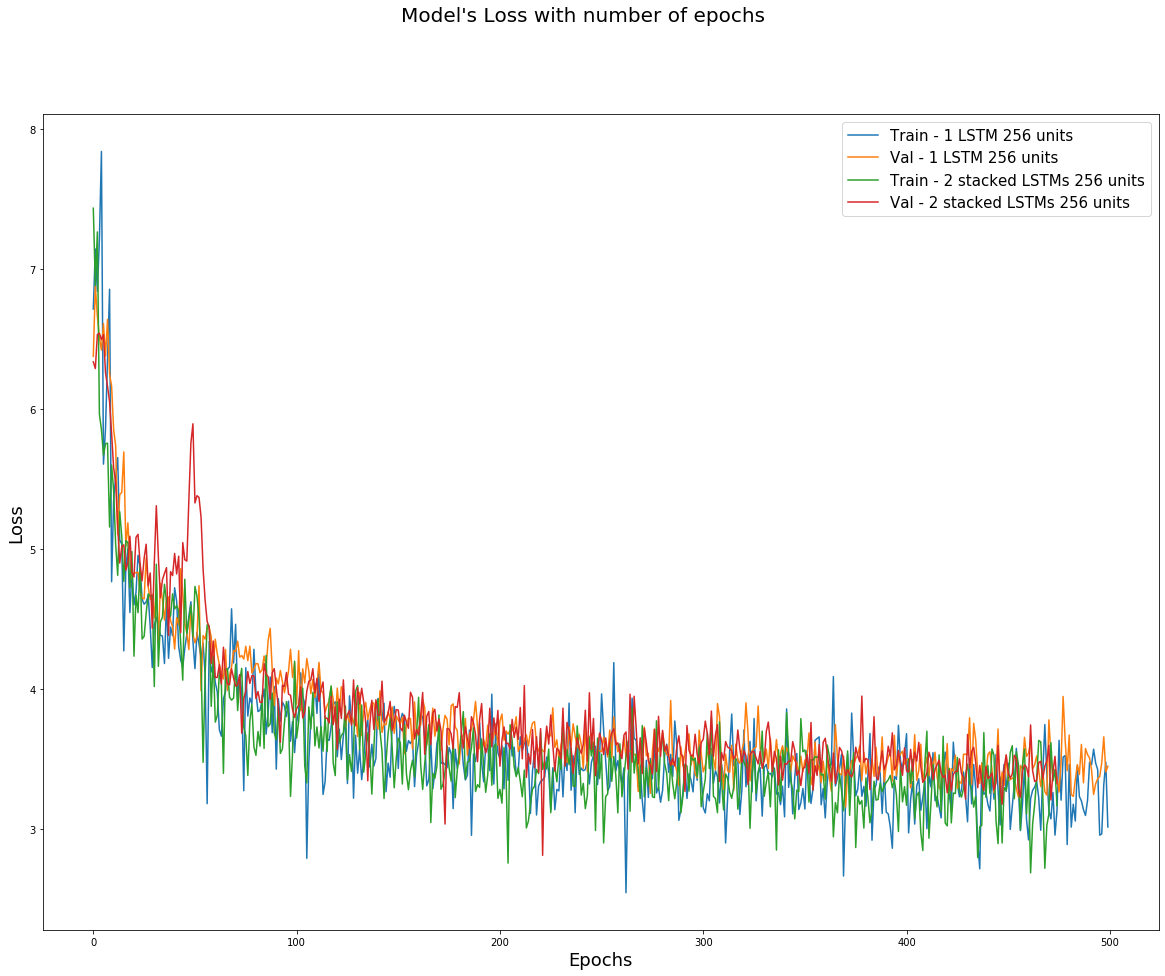

In [8]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, len(train_loss_no_pt_embed))
x_axis_2 = range(0, len(train_loss_2LSTM256))
ax.plot(x_axis, train_loss_no_pt_embed, label='Train - 1 LSTM 256 units')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val - 1 LSTM 256 units')
ax.plot(x_axis_2, train_loss_2LSTM256, label='Train - 2 stacked LSTMs 256 units')
ax.plot(x_axis_2, val_loss_2LSTM256, label='Val - 2 stacked LSTMs 256 units')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig(CURR_RES + 'Loss_with_Epochs_compare_FatVsDeep_256.jpg')
plt.show()

### Plot Model's Accuracy for both models, with and without any pre-training

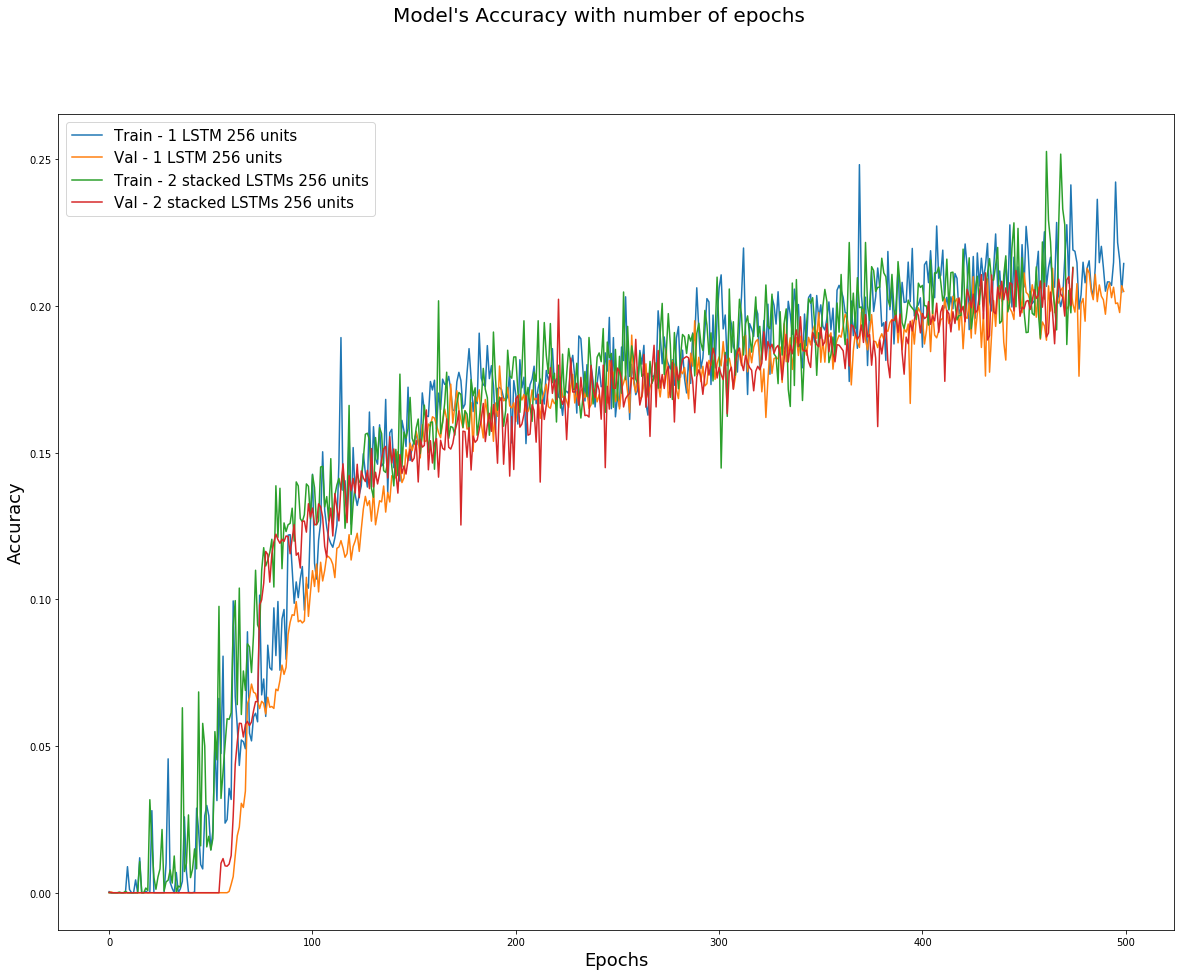

In [7]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, len(train_accuracy_no_pt_embed))
x_axis_2 = range(0, len(train_accuracy_2LSTM256))
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train - 1 LSTM 256 units')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val - 1 LSTM 256 units')
ax.plot(x_axis_2, train_accuracy_2LSTM256, label='Train - 2 stacked LSTMs 256 units')
ax.plot(x_axis_2, val_accuracy_2LSTM256, label='Val - 2 stacked LSTMs 256 units')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig(CURR_RES + 'Accuracy_with_Epochs_compare_FatVsDeep_256.jpg')
plt.show()